# Stock Predict Model

## Set Up

### Import Modules

In [941]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# For Graph
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

# Yahoo API
import yfinance as yf

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

### Configurations

In [942]:
device = 'cpu' if torch.backends.mps.is_available() else 'cpu'
scaler = StandardScaler()
config = {
    'seed': 666999,
    'select_all': False,
    'valid_ratio': 0.2,
    'test_ratio': 0.2,
    'n_epochs': 3000,
    'learning_rate': 1e-5,
    'early_stop': 300,
    'save_path': './models/stock.ckpt',
    'data_loader': {
        'batch_size': 130,
        'pin_memory': True,
        'num_workers': 0
    }
}

### Utility Functions

In [943]:
def same_seed(seed):
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

def predict(test_loader, model, device):
    model.eval()
    result = {'features': [], 'preds': [], 'ans': []}
    for x, y in tqdm(test_loader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            result['features'].append(x.detach().cpu())
            result['preds'].append(pred.detach().cpu())
            result['ans'].append(y.detach().cpu())

    # Combination tensor
    result['features'] = torch.cat(result['features'], 0).numpy()
    result['preds'] = torch.cat(result['preds'], 0).numpy()
    result['ans'] = torch.cat(result['ans'], 0).numpy()

    predstack = np.column_stack((result['features'], result['preds']))
    targetstack = np.column_stack((result['features'], result['ans']))

    return np.column_stack((predstack[:, -1], targetstack[:, -1]))

def plot_error_rate(pred, target):
    '''Plot error rate.'''
    errors = (np.absolute(pred - target) / target) * 100
    plt.plot(errors, '-r')

    plt.xlabel('')
    plt.ylabel('Percentage')
    plt.title('Error Rate')

    plt.show()

def plot_pred(pred, target):
    '''Plot predict.'''
    plt.plot(pred, '-g', label='Prediction')
    plt.plot(target, '--r', label='Target')

    plt.xlabel('Predictions')
    plt.ylabel('Targets')
    plt.title('Predictions')
    plt.legend()

    plt.show()

def plot_trend(pred, target):
    X = np.array(pred).reshape(-1, 1)
    y = np.array(target)

    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)

    plt.scatter(pred, target, c='b', label='Data')
    plt.plot(pred, y_pred, c='r', label='Trend Line')

    plt.xlabel('Predictions')
    plt.ylabel('Targets')
    plt.title('Trend')
    plt.legend()

    plt.show()



## Data

### Dataset

In [944]:
class Stock_Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None, normalized=False, initscaler=True):
        # Normalized
        stack = np.column_stack((x, y))

        if (normalized):
            normalstack = scaler.fit_transform(stack) if initscaler else scaler.transform(stack)
            x = normalstack[:, :-1]
            y = y if y is None else normalstack[:, -1]

        self.y = y if y is None else torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

### DataLoader

In [945]:
def stock_dataloader(config, x, y=None, normalized=True, initscaler=True):
    ''' Generates a dataset, then is put into a dataloader. '''

    x = np.array(x)
    y = np.array(y) if y is not None else y

    dataset = Stock_Dataset(x, y, normalized, initscaler)
    dataloader = DataLoader(dataset, **config['data_loader'])

    return dataloader

### Feature Selection

In [946]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid, y_test = train_data[:,-1], valid_data[:,-1], test_data[:, -1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:, :-1], valid_data[:, :-1], test_data[:, :-1]

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = [0,1,2,3] # TODO: Select suitable feature columns.

    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid, y_test

### Set Data

In [947]:
same_seed(config['seed'])

# re-index
index = ["Open", "High", "Low", "Adj Close", "Volume", "Close"]
raw_data = pd.DataFrame(yf.download('2330.TW', start='2000-01-01', end='2023-12-31'))
# raw_data.to_csv("raw.csv", index=False)
train_data, test_data = train_test_split(
    raw_data[index].values,
    test_size=config['test_ratio'],
    random_state=config['seed'],
    shuffle=False
)

train_data, valid_data = train_test_split(
    train_data,
    test_size=config['valid_ratio'],
    random_state=config['seed'],
    shuffle=True
)

# Print out the data size.
print(f"""train_data size: {train_data.shape}
valid_data size: {valid_data.shape}
test_data size: {test_data.shape}""")

# Select features
x_train, x_valid, x_test, y_train, y_valid, y_test = select_feat(train_data, valid_data, test_data, config['select_all'])

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

# Pytorch data loader loads pytorch dataset into batches.
train_loader = stock_dataloader(config, x_train, y_train)
valid_loader = stock_dataloader(config, x_valid, y_valid, initscaler=False)
test_loader = stock_dataloader(config, x_test, y_test, initscaler=False)

[*********************100%***********************]  1 of 1 completed
train_data size: (3736, 6)
valid_data size: (934, 6)
test_data size: (1168, 6)
number of features: 4


## Neural Network

### Model

In [948]:
class Stock_Model(nn.Module):
    def __init__(self, input_dim):
        super(Stock_Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1)
        return x

### Training Loop

In [949]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.7)

    writer = SummaryWriter()

    if not os.path.isdir('./models'):
        os.mkdir('./models')

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train()
        loss_record = []

        train_pbar = tqdm(train_loader, position=0, leave=True)
        for x, y in train_pbar:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            step += 1
            loss_record.append(loss.detach().item())

            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})
        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval()
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())

        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

## Training

In [950]:
model = Stock_Model(input_dim=x_train.shape[1]).to(device)
trainer(train_loader, valid_loader, model, config, device)

# with torch.profiler.profile(
#     activities=[torch.profiler.ProfilerActivity.CPU],
#     schedule = torch.profiler.schedule(
#         wait=0,
#         warmup=0,
#         active=1
#     ),
#     on_trace_ready=torch.profiler.tensorboard_trace_handler('./log')
# ) as prof:
#     trainer(train_loader, valid_loader, model, config, device)
#     prof.step()

Epoch [1/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.91it/s, loss=1.04] 


Epoch [1/3000]: Train loss: 0.8547, Valid loss: 0.6530
Saving model with loss 0.653...


Epoch [2/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.33it/s, loss=1.02] 


Epoch [2/3000]: Train loss: 0.8383, Valid loss: 0.7054


Epoch [3/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.07it/s, loss=1]    


Epoch [3/3000]: Train loss: 0.8219, Valid loss: 0.7296


Epoch [4/3000]: 100%|██████████| 29/29 [00:00<00:00, 60.87it/s, loss=0.985]


Epoch [4/3000]: Train loss: 0.8057, Valid loss: 0.7180


Epoch [5/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.46it/s, loss=0.966]


Epoch [5/3000]: Train loss: 0.7895, Valid loss: 0.7033


Epoch [6/3000]: 100%|██████████| 29/29 [00:00<00:00, 138.78it/s, loss=0.947]


Epoch [6/3000]: Train loss: 0.7735, Valid loss: 0.6884


Epoch [7/3000]: 100%|██████████| 29/29 [00:00<00:00, 62.03it/s, loss=0.928]


Epoch [7/3000]: Train loss: 0.7575, Valid loss: 0.6734


Epoch [8/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.64it/s, loss=0.909]


Epoch [8/3000]: Train loss: 0.7414, Valid loss: 0.6583


Epoch [9/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.44it/s, loss=0.889]


Epoch [9/3000]: Train loss: 0.7251, Valid loss: 0.6428
Saving model with loss 0.643...


Epoch [10/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.82it/s, loss=0.869]


Epoch [10/3000]: Train loss: 0.7086, Valid loss: 0.6269
Saving model with loss 0.627...


Epoch [11/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.00it/s, loss=0.847]


Epoch [11/3000]: Train loss: 0.6916, Valid loss: 0.6103
Saving model with loss 0.610...


Epoch [12/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.03it/s, loss=0.825]


Epoch [12/3000]: Train loss: 0.6739, Valid loss: 0.5932
Saving model with loss 0.593...


Epoch [13/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.44it/s, loss=0.804]


Epoch [13/3000]: Train loss: 0.6545, Valid loss: 0.5756
Saving model with loss 0.576...


Epoch [14/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.61it/s, loss=0.768]


Epoch [14/3000]: Train loss: 0.6308, Valid loss: 0.5576
Saving model with loss 0.558...


Epoch [15/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.44it/s, loss=0.751]


Epoch [15/3000]: Train loss: 0.6025, Valid loss: 0.5321
Saving model with loss 0.532...


Epoch [16/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.53it/s, loss=0.738]


Epoch [16/3000]: Train loss: 0.5901, Valid loss: 0.5191
Saving model with loss 0.519...


Epoch [17/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.71it/s, loss=0.724]


Epoch [17/3000]: Train loss: 0.5790, Valid loss: 0.5088
Saving model with loss 0.509...


Epoch [18/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.67it/s, loss=0.71] 


Epoch [18/3000]: Train loss: 0.5676, Valid loss: 0.4981
Saving model with loss 0.498...


Epoch [19/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.27it/s, loss=0.697]


Epoch [19/3000]: Train loss: 0.5559, Valid loss: 0.4877
Saving model with loss 0.488...


Epoch [20/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.84it/s, loss=0.683]


Epoch [20/3000]: Train loss: 0.5438, Valid loss: 0.4779
Saving model with loss 0.478...


Epoch [21/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.94it/s, loss=0.669]


Epoch [21/3000]: Train loss: 0.5311, Valid loss: 0.4674
Saving model with loss 0.467...


Epoch [22/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.68it/s, loss=0.654]


Epoch [22/3000]: Train loss: 0.5171, Valid loss: 0.4560
Saving model with loss 0.456...


Epoch [23/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.29it/s, loss=0.637]


Epoch [23/3000]: Train loss: 0.5018, Valid loss: 0.4429
Saving model with loss 0.443...


Epoch [24/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.24it/s, loss=0.603]


Epoch [24/3000]: Train loss: 0.4811, Valid loss: 0.4230
Saving model with loss 0.423...


Epoch [25/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.07it/s, loss=0.569]


Epoch [25/3000]: Train loss: 0.4513, Valid loss: 0.3933
Saving model with loss 0.393...


Epoch [26/3000]: 100%|██████████| 29/29 [00:00<00:00, 60.51it/s, loss=0.54] 


Epoch [26/3000]: Train loss: 0.4170, Valid loss: 0.3610
Saving model with loss 0.361...


Epoch [27/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.63it/s, loss=0.52] 


Epoch [27/3000]: Train loss: 0.3896, Valid loss: 0.3416
Saving model with loss 0.342...


Epoch [28/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.53it/s, loss=0.505]


Epoch [28/3000]: Train loss: 0.3718, Valid loss: 0.3284
Saving model with loss 0.328...


Epoch [29/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.21it/s, loss=0.493]


Epoch [29/3000]: Train loss: 0.3586, Valid loss: 0.3180
Saving model with loss 0.318...


Epoch [30/3000]: 100%|██████████| 29/29 [00:00<00:00, 67.38it/s, loss=0.483] 


Epoch [30/3000]: Train loss: 0.3478, Valid loss: 0.3091
Saving model with loss 0.309...


Epoch [31/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.56it/s, loss=0.474] 


Epoch [31/3000]: Train loss: 0.3385, Valid loss: 0.3013
Saving model with loss 0.301...


Epoch [32/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.73it/s, loss=0.465]


Epoch [32/3000]: Train loss: 0.3301, Valid loss: 0.2941
Saving model with loss 0.294...


Epoch [33/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.65it/s, loss=0.457]


Epoch [33/3000]: Train loss: 0.3225, Valid loss: 0.2875
Saving model with loss 0.288...


Epoch [34/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.28it/s, loss=0.449]


Epoch [34/3000]: Train loss: 0.3153, Valid loss: 0.2813
Saving model with loss 0.281...


Epoch [35/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.82it/s, loss=0.442]


Epoch [35/3000]: Train loss: 0.3086, Valid loss: 0.2754
Saving model with loss 0.275...


Epoch [36/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.69it/s, loss=0.435]


Epoch [36/3000]: Train loss: 0.3022, Valid loss: 0.2697
Saving model with loss 0.270...


Epoch [37/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.44it/s, loss=0.428] 


Epoch [37/3000]: Train loss: 0.2961, Valid loss: 0.2643
Saving model with loss 0.264...


Epoch [38/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.14it/s, loss=0.421]


Epoch [38/3000]: Train loss: 0.2903, Valid loss: 0.2591
Saving model with loss 0.259...


Epoch [39/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.32it/s, loss=0.415] 


Epoch [39/3000]: Train loss: 0.2846, Valid loss: 0.2541
Saving model with loss 0.254...


Epoch [40/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.87it/s, loss=0.408] 


Epoch [40/3000]: Train loss: 0.2791, Valid loss: 0.2492
Saving model with loss 0.249...


Epoch [41/3000]: 100%|██████████| 29/29 [00:00<00:00, 84.79it/s, loss=0.402] 


Epoch [41/3000]: Train loss: 0.2738, Valid loss: 0.2444
Saving model with loss 0.244...


Epoch [42/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.11it/s, loss=0.396] 


Epoch [42/3000]: Train loss: 0.2687, Valid loss: 0.2398
Saving model with loss 0.240...


Epoch [43/3000]: 100%|██████████| 29/29 [00:00<00:00, 64.79it/s, loss=0.39]  


Epoch [43/3000]: Train loss: 0.2637, Valid loss: 0.2353
Saving model with loss 0.235...


Epoch [44/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.65it/s, loss=0.384] 


Epoch [44/3000]: Train loss: 0.2589, Valid loss: 0.2309
Saving model with loss 0.231...


Epoch [45/3000]: 100%|██████████| 29/29 [00:00<00:00, 63.66it/s, loss=0.378] 


Epoch [45/3000]: Train loss: 0.2541, Valid loss: 0.2267
Saving model with loss 0.227...


Epoch [46/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.87it/s, loss=0.372] 


Epoch [46/3000]: Train loss: 0.2495, Valid loss: 0.2225
Saving model with loss 0.222...


Epoch [47/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.29it/s, loss=0.367] 


Epoch [47/3000]: Train loss: 0.2450, Valid loss: 0.2184
Saving model with loss 0.218...


Epoch [48/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.41it/s, loss=0.362] 


Epoch [48/3000]: Train loss: 0.2406, Valid loss: 0.2144
Saving model with loss 0.214...


Epoch [49/3000]: 100%|██████████| 29/29 [00:00<00:00, 58.89it/s, loss=0.356] 


Epoch [49/3000]: Train loss: 0.2363, Valid loss: 0.2105
Saving model with loss 0.211...


Epoch [50/3000]: 100%|██████████| 29/29 [00:00<00:00, 70.13it/s, loss=0.351] 


Epoch [50/3000]: Train loss: 0.2321, Valid loss: 0.2067
Saving model with loss 0.207...


Epoch [51/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.10it/s, loss=0.346] 


Epoch [51/3000]: Train loss: 0.2279, Valid loss: 0.2030
Saving model with loss 0.203...


Epoch [52/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.31it/s, loss=0.341] 


Epoch [52/3000]: Train loss: 0.2239, Valid loss: 0.1993
Saving model with loss 0.199...


Epoch [53/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.89it/s, loss=0.336] 


Epoch [53/3000]: Train loss: 0.2199, Valid loss: 0.1957
Saving model with loss 0.196...


Epoch [54/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.13it/s, loss=0.332] 


Epoch [54/3000]: Train loss: 0.2161, Valid loss: 0.1922
Saving model with loss 0.192...


Epoch [55/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.82it/s, loss=0.327] 


Epoch [55/3000]: Train loss: 0.2123, Valid loss: 0.1887
Saving model with loss 0.189...


Epoch [56/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.57it/s, loss=0.323] 


Epoch [56/3000]: Train loss: 0.2086, Valid loss: 0.1853
Saving model with loss 0.185...


Epoch [57/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.35it/s, loss=0.318] 


Epoch [57/3000]: Train loss: 0.2049, Valid loss: 0.1820
Saving model with loss 0.182...


Epoch [58/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.73it/s, loss=0.314] 


Epoch [58/3000]: Train loss: 0.2013, Valid loss: 0.1787
Saving model with loss 0.179...


Epoch [59/3000]: 100%|██████████| 29/29 [00:00<00:00, 61.01it/s, loss=0.31]  


Epoch [59/3000]: Train loss: 0.1978, Valid loss: 0.1755
Saving model with loss 0.175...


Epoch [60/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.48it/s, loss=0.306] 


Epoch [60/3000]: Train loss: 0.1944, Valid loss: 0.1723
Saving model with loss 0.172...


Epoch [61/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.01it/s, loss=0.301] 


Epoch [61/3000]: Train loss: 0.1910, Valid loss: 0.1692
Saving model with loss 0.169...


Epoch [62/3000]: 100%|██████████| 29/29 [00:00<00:00, 197.86it/s, loss=0.297] 


Epoch [62/3000]: Train loss: 0.1877, Valid loss: 0.1662
Saving model with loss 0.166...


Epoch [63/3000]: 100%|██████████| 29/29 [00:00<00:00, 186.10it/s, loss=0.293] 


Epoch [63/3000]: Train loss: 0.1845, Valid loss: 0.1632
Saving model with loss 0.163...


Epoch [64/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.43it/s, loss=0.289]  


Epoch [64/3000]: Train loss: 0.1813, Valid loss: 0.1603
Saving model with loss 0.160...


Epoch [65/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.71it/s, loss=0.286] 


Epoch [65/3000]: Train loss: 0.1782, Valid loss: 0.1574
Saving model with loss 0.157...


Epoch [66/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.16it/s, loss=0.282] 


Epoch [66/3000]: Train loss: 0.1751, Valid loss: 0.1546
Saving model with loss 0.155...


Epoch [67/3000]: 100%|██████████| 29/29 [00:00<00:00, 143.26it/s, loss=0.278] 


Epoch [67/3000]: Train loss: 0.1721, Valid loss: 0.1518
Saving model with loss 0.152...


Epoch [68/3000]: 100%|██████████| 29/29 [00:00<00:00, 66.29it/s, loss=0.274]  


Epoch [68/3000]: Train loss: 0.1692, Valid loss: 0.1491
Saving model with loss 0.149...


Epoch [69/3000]: 100%|██████████| 29/29 [00:00<00:00, 150.41it/s, loss=0.271] 


Epoch [69/3000]: Train loss: 0.1663, Valid loss: 0.1464
Saving model with loss 0.146...


Epoch [70/3000]: 100%|██████████| 29/29 [00:00<00:00, 167.77it/s, loss=0.267] 


Epoch [70/3000]: Train loss: 0.1635, Valid loss: 0.1438
Saving model with loss 0.144...


Epoch [71/3000]: 100%|██████████| 29/29 [00:00<00:00, 70.34it/s, loss=0.264] 


Epoch [71/3000]: Train loss: 0.1608, Valid loss: 0.1413
Saving model with loss 0.141...


Epoch [72/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.69it/s, loss=0.26]  


Epoch [72/3000]: Train loss: 0.1581, Valid loss: 0.1388
Saving model with loss 0.139...


Epoch [73/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.61it/s, loss=0.257] 


Epoch [73/3000]: Train loss: 0.1554, Valid loss: 0.1364
Saving model with loss 0.136...


Epoch [74/3000]: 100%|██████████| 29/29 [00:00<00:00, 138.19it/s, loss=0.254] 


Epoch [74/3000]: Train loss: 0.1528, Valid loss: 0.1340
Saving model with loss 0.134...


Epoch [75/3000]: 100%|██████████| 29/29 [00:00<00:00, 181.94it/s, loss=0.25]  


Epoch [75/3000]: Train loss: 0.1503, Valid loss: 0.1316
Saving model with loss 0.132...


Epoch [76/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.54it/s, loss=0.247] 


Epoch [76/3000]: Train loss: 0.1478, Valid loss: 0.1293
Saving model with loss 0.129...


Epoch [77/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.52it/s, loss=0.244] 


Epoch [77/3000]: Train loss: 0.1454, Valid loss: 0.1271
Saving model with loss 0.127...


Epoch [78/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.67it/s, loss=0.241]  


Epoch [78/3000]: Train loss: 0.1430, Valid loss: 0.1249
Saving model with loss 0.125...


Epoch [79/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.91it/s, loss=0.238] 


Epoch [79/3000]: Train loss: 0.1407, Valid loss: 0.1227
Saving model with loss 0.123...


Epoch [80/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.82it/s, loss=0.235] 


Epoch [80/3000]: Train loss: 0.1384, Valid loss: 0.1206
Saving model with loss 0.121...


Epoch [81/3000]: 100%|██████████| 29/29 [00:00<00:00, 93.75it/s, loss=0.232] 


Epoch [81/3000]: Train loss: 0.1361, Valid loss: 0.1185
Saving model with loss 0.118...


Epoch [82/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.45it/s, loss=0.229] 


Epoch [82/3000]: Train loss: 0.1340, Valid loss: 0.1165
Saving model with loss 0.116...


Epoch [83/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.59it/s, loss=0.226] 


Epoch [83/3000]: Train loss: 0.1318, Valid loss: 0.1145
Saving model with loss 0.114...


Epoch [84/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.89it/s, loss=0.223] 


Epoch [84/3000]: Train loss: 0.1297, Valid loss: 0.1125
Saving model with loss 0.112...


Epoch [85/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.35it/s, loss=0.221] 


Epoch [85/3000]: Train loss: 0.1276, Valid loss: 0.1106
Saving model with loss 0.111...


Epoch [86/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.12it/s, loss=0.218] 


Epoch [86/3000]: Train loss: 0.1256, Valid loss: 0.1087
Saving model with loss 0.109...


Epoch [87/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.69it/s, loss=0.215] 


Epoch [87/3000]: Train loss: 0.1236, Valid loss: 0.1069
Saving model with loss 0.107...


Epoch [88/3000]: 100%|██████████| 29/29 [00:00<00:00, 60.29it/s, loss=0.213]  


Epoch [88/3000]: Train loss: 0.1217, Valid loss: 0.1050
Saving model with loss 0.105...


Epoch [89/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.50it/s, loss=0.21]  


Epoch [89/3000]: Train loss: 0.1198, Valid loss: 0.1033
Saving model with loss 0.103...


Epoch [90/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.18it/s, loss=0.208] 


Epoch [90/3000]: Train loss: 0.1179, Valid loss: 0.1015
Saving model with loss 0.102...


Epoch [91/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.48it/s, loss=0.205] 


Epoch [91/3000]: Train loss: 0.1161, Valid loss: 0.0998
Saving model with loss 0.100...


Epoch [92/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.27it/s, loss=0.203] 


Epoch [92/3000]: Train loss: 0.1143, Valid loss: 0.0982
Saving model with loss 0.098...


Epoch [93/3000]: 100%|██████████| 29/29 [00:00<00:00, 146.38it/s, loss=0.2]   


Epoch [93/3000]: Train loss: 0.1125, Valid loss: 0.0965
Saving model with loss 0.097...


Epoch [94/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.00it/s, loss=0.198] 


Epoch [94/3000]: Train loss: 0.1108, Valid loss: 0.0949
Saving model with loss 0.095...


Epoch [95/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.49it/s, loss=0.195] 


Epoch [95/3000]: Train loss: 0.1091, Valid loss: 0.0934
Saving model with loss 0.093...


Epoch [96/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.72it/s, loss=0.193] 


Epoch [96/3000]: Train loss: 0.1075, Valid loss: 0.0918
Saving model with loss 0.092...


Epoch [97/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.10it/s, loss=0.191] 


Epoch [97/3000]: Train loss: 0.1058, Valid loss: 0.0903
Saving model with loss 0.090...


Epoch [98/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.77it/s, loss=0.189] 


Epoch [98/3000]: Train loss: 0.1043, Valid loss: 0.0888
Saving model with loss 0.089...


Epoch [99/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.36it/s, loss=0.187]  


Epoch [99/3000]: Train loss: 0.1027, Valid loss: 0.0874
Saving model with loss 0.087...


Epoch [100/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.23it/s, loss=0.184]  


Epoch [100/3000]: Train loss: 0.1012, Valid loss: 0.0860
Saving model with loss 0.086...


Epoch [101/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.93it/s, loss=0.182] 


Epoch [101/3000]: Train loss: 0.0997, Valid loss: 0.0846
Saving model with loss 0.085...


Epoch [102/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.17it/s, loss=0.18]  


Epoch [102/3000]: Train loss: 0.0982, Valid loss: 0.0832
Saving model with loss 0.083...


Epoch [103/3000]: 100%|██████████| 29/29 [00:00<00:00, 61.96it/s, loss=0.178] 


Epoch [103/3000]: Train loss: 0.0967, Valid loss: 0.0819
Saving model with loss 0.082...


Epoch [104/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.98it/s, loss=0.176] 


Epoch [104/3000]: Train loss: 0.0953, Valid loss: 0.0805
Saving model with loss 0.081...


Epoch [105/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.91it/s, loss=0.174] 


Epoch [105/3000]: Train loss: 0.0939, Valid loss: 0.0793
Saving model with loss 0.079...


Epoch [106/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.39it/s, loss=0.172]  


Epoch [106/3000]: Train loss: 0.0926, Valid loss: 0.0780
Saving model with loss 0.078...


Epoch [107/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.81it/s, loss=0.17]  


Epoch [107/3000]: Train loss: 0.0912, Valid loss: 0.0767
Saving model with loss 0.077...


Epoch [108/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.07it/s, loss=0.168] 


Epoch [108/3000]: Train loss: 0.0899, Valid loss: 0.0755
Saving model with loss 0.076...


Epoch [109/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.18it/s, loss=0.166] 


Epoch [109/3000]: Train loss: 0.0886, Valid loss: 0.0743
Saving model with loss 0.074...


Epoch [110/3000]: 100%|██████████| 29/29 [00:00<00:00, 62.32it/s, loss=0.165]  


Epoch [110/3000]: Train loss: 0.0874, Valid loss: 0.0732
Saving model with loss 0.073...


Epoch [111/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.63it/s, loss=0.163] 


Epoch [111/3000]: Train loss: 0.0861, Valid loss: 0.0720
Saving model with loss 0.072...


Epoch [112/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.58it/s, loss=0.161] 


Epoch [112/3000]: Train loss: 0.0849, Valid loss: 0.0709
Saving model with loss 0.071...


Epoch [113/3000]: 100%|██████████| 29/29 [00:00<00:00, 79.00it/s, loss=0.159] 


Epoch [113/3000]: Train loss: 0.0837, Valid loss: 0.0698
Saving model with loss 0.070...


Epoch [114/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.93it/s, loss=0.158]


Epoch [114/3000]: Train loss: 0.0826, Valid loss: 0.0687
Saving model with loss 0.069...


Epoch [115/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.12it/s, loss=0.156] 


Epoch [115/3000]: Train loss: 0.0814, Valid loss: 0.0676
Saving model with loss 0.068...


Epoch [116/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.99it/s, loss=0.154] 


Epoch [116/3000]: Train loss: 0.0803, Valid loss: 0.0666
Saving model with loss 0.067...


Epoch [117/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.71it/s, loss=0.153] 


Epoch [117/3000]: Train loss: 0.0792, Valid loss: 0.0655
Saving model with loss 0.066...


Epoch [118/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.01it/s, loss=0.151]  


Epoch [118/3000]: Train loss: 0.0781, Valid loss: 0.0645
Saving model with loss 0.065...


Epoch [119/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.53it/s, loss=0.149] 


Epoch [119/3000]: Train loss: 0.0770, Valid loss: 0.0635
Saving model with loss 0.064...


Epoch [120/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.26it/s, loss=0.148]  


Epoch [120/3000]: Train loss: 0.0760, Valid loss: 0.0626
Saving model with loss 0.063...


Epoch [121/3000]: 100%|██████████| 29/29 [00:00<00:00, 88.96it/s, loss=0.146]  


Epoch [121/3000]: Train loss: 0.0750, Valid loss: 0.0616
Saving model with loss 0.062...


Epoch [122/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.23it/s, loss=0.145] 


Epoch [122/3000]: Train loss: 0.0740, Valid loss: 0.0607
Saving model with loss 0.061...


Epoch [123/3000]: 100%|██████████| 29/29 [00:00<00:00, 56.61it/s, loss=0.143] 


Epoch [123/3000]: Train loss: 0.0730, Valid loss: 0.0598
Saving model with loss 0.060...


Epoch [124/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.64it/s, loss=0.142]  


Epoch [124/3000]: Train loss: 0.0720, Valid loss: 0.0588
Saving model with loss 0.059...


Epoch [125/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.64it/s, loss=0.14]  


Epoch [125/3000]: Train loss: 0.0710, Valid loss: 0.0580
Saving model with loss 0.058...


Epoch [126/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.90it/s, loss=0.139] 


Epoch [126/3000]: Train loss: 0.0701, Valid loss: 0.0571
Saving model with loss 0.057...


Epoch [127/3000]: 100%|██████████| 29/29 [00:00<00:00, 60.66it/s, loss=0.137]  


Epoch [127/3000]: Train loss: 0.0692, Valid loss: 0.0562
Saving model with loss 0.056...


Epoch [128/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.27it/s, loss=0.136] 


Epoch [128/3000]: Train loss: 0.0683, Valid loss: 0.0554
Saving model with loss 0.055...


Epoch [129/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.98it/s, loss=0.135] 


Epoch [129/3000]: Train loss: 0.0674, Valid loss: 0.0546
Saving model with loss 0.055...


Epoch [130/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.85it/s, loss=0.133] 


Epoch [130/3000]: Train loss: 0.0665, Valid loss: 0.0538
Saving model with loss 0.054...


Epoch [131/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.20it/s, loss=0.132] 


Epoch [131/3000]: Train loss: 0.0657, Valid loss: 0.0530
Saving model with loss 0.053...


Epoch [132/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.81it/s, loss=0.131] 


Epoch [132/3000]: Train loss: 0.0648, Valid loss: 0.0522
Saving model with loss 0.052...


Epoch [133/3000]: 100%|██████████| 29/29 [00:00<00:00, 66.58it/s, loss=0.13]   


Epoch [133/3000]: Train loss: 0.0640, Valid loss: 0.0514
Saving model with loss 0.051...


Epoch [134/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.91it/s, loss=0.128] 


Epoch [134/3000]: Train loss: 0.0632, Valid loss: 0.0507
Saving model with loss 0.051...


Epoch [135/3000]: 100%|██████████| 29/29 [00:00<00:00, 158.96it/s, loss=0.127] 


Epoch [135/3000]: Train loss: 0.0624, Valid loss: 0.0499
Saving model with loss 0.050...


Epoch [136/3000]: 100%|██████████| 29/29 [00:00<00:00, 69.70it/s, loss=0.126] 


Epoch [136/3000]: Train loss: 0.0616, Valid loss: 0.0492
Saving model with loss 0.049...


Epoch [137/3000]: 100%|██████████| 29/29 [00:00<00:00, 163.58it/s, loss=0.125] 


Epoch [137/3000]: Train loss: 0.0609, Valid loss: 0.0485
Saving model with loss 0.048...


Epoch [138/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.75it/s, loss=0.123] 


Epoch [138/3000]: Train loss: 0.0601, Valid loss: 0.0478
Saving model with loss 0.048...


Epoch [139/3000]: 100%|██████████| 29/29 [00:00<00:00, 159.63it/s, loss=0.122] 


Epoch [139/3000]: Train loss: 0.0594, Valid loss: 0.0471
Saving model with loss 0.047...


Epoch [140/3000]: 100%|██████████| 29/29 [00:00<00:00, 150.48it/s, loss=0.121] 


Epoch [140/3000]: Train loss: 0.0586, Valid loss: 0.0464
Saving model with loss 0.046...


Epoch [141/3000]: 100%|██████████| 29/29 [00:00<00:00, 155.16it/s, loss=0.12]  


Epoch [141/3000]: Train loss: 0.0579, Valid loss: 0.0457
Saving model with loss 0.046...


Epoch [142/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.12it/s, loss=0.119] 


Epoch [142/3000]: Train loss: 0.0572, Valid loss: 0.0451
Saving model with loss 0.045...


Epoch [143/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.28it/s, loss=0.118] 


Epoch [143/3000]: Train loss: 0.0565, Valid loss: 0.0444
Saving model with loss 0.044...


Epoch [144/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.01it/s, loss=0.117] 


Epoch [144/3000]: Train loss: 0.0559, Valid loss: 0.0438
Saving model with loss 0.044...


Epoch [145/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.79it/s, loss=0.116] 


Epoch [145/3000]: Train loss: 0.0552, Valid loss: 0.0432
Saving model with loss 0.043...


Epoch [146/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.18it/s, loss=0.115] 


Epoch [146/3000]: Train loss: 0.0545, Valid loss: 0.0426
Saving model with loss 0.043...


Epoch [147/3000]: 100%|██████████| 29/29 [00:00<00:00, 176.41it/s, loss=0.114] 


Epoch [147/3000]: Train loss: 0.0539, Valid loss: 0.0420
Saving model with loss 0.042...


Epoch [148/3000]: 100%|██████████| 29/29 [00:00<00:00, 170.41it/s, loss=0.113] 

Epoch [148/3000]: Train loss: 0.0533, Valid loss: 0.0414
Saving model with loss 0.041...



Epoch [149/3000]: 100%|██████████| 29/29 [00:00<00:00, 159.95it/s, loss=0.112] 


Epoch [149/3000]: Train loss: 0.0527, Valid loss: 0.0408
Saving model with loss 0.041...


Epoch [150/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.59it/s, loss=0.111] 


Epoch [150/3000]: Train loss: 0.0520, Valid loss: 0.0402
Saving model with loss 0.040...


Epoch [151/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.32it/s, loss=0.11]  


Epoch [151/3000]: Train loss: 0.0515, Valid loss: 0.0397
Saving model with loss 0.040...


Epoch [152/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.13it/s, loss=0.109] 


Epoch [152/3000]: Train loss: 0.0509, Valid loss: 0.0391
Saving model with loss 0.039...


Epoch [153/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.92it/s, loss=0.108] 


Epoch [153/3000]: Train loss: 0.0503, Valid loss: 0.0386
Saving model with loss 0.039...


Epoch [154/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.35it/s, loss=0.107]


Epoch [154/3000]: Train loss: 0.0497, Valid loss: 0.0380
Saving model with loss 0.038...


Epoch [155/3000]: 100%|██████████| 29/29 [00:00<00:00, 84.93it/s, loss=0.106] 


Epoch [155/3000]: Train loss: 0.0492, Valid loss: 0.0375
Saving model with loss 0.038...


Epoch [156/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.05it/s, loss=0.105] 


Epoch [156/3000]: Train loss: 0.0486, Valid loss: 0.0370
Saving model with loss 0.037...


Epoch [157/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.31it/s, loss=0.104] 


Epoch [157/3000]: Train loss: 0.0481, Valid loss: 0.0365
Saving model with loss 0.037...


Epoch [158/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.36it/s, loss=0.103] 


Epoch [158/3000]: Train loss: 0.0475, Valid loss: 0.0360
Saving model with loss 0.036...


Epoch [159/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.62it/s, loss=0.102] 


Epoch [159/3000]: Train loss: 0.0470, Valid loss: 0.0355
Saving model with loss 0.036...


Epoch [160/3000]: 100%|██████████| 29/29 [00:00<00:00, 52.05it/s, loss=0.101] 


Epoch [160/3000]: Train loss: 0.0465, Valid loss: 0.0350
Saving model with loss 0.035...


Epoch [161/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.53it/s, loss=0.1]   


Epoch [161/3000]: Train loss: 0.0460, Valid loss: 0.0346
Saving model with loss 0.035...


Epoch [162/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.27it/s, loss=0.0997]


Epoch [162/3000]: Train loss: 0.0455, Valid loss: 0.0341
Saving model with loss 0.034...


Epoch [163/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.89it/s, loss=0.0988]


Epoch [163/3000]: Train loss: 0.0450, Valid loss: 0.0336
Saving model with loss 0.034...


Epoch [164/3000]: 100%|██████████| 29/29 [00:00<00:00, 143.81it/s, loss=0.098] 


Epoch [164/3000]: Train loss: 0.0446, Valid loss: 0.0332
Saving model with loss 0.033...


Epoch [165/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.14it/s, loss=0.0972]


Epoch [165/3000]: Train loss: 0.0441, Valid loss: 0.0328
Saving model with loss 0.033...


Epoch [166/3000]: 100%|██████████| 29/29 [00:00<00:00, 157.67it/s, loss=0.0964]


Epoch [166/3000]: Train loss: 0.0436, Valid loss: 0.0323
Saving model with loss 0.032...


Epoch [167/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.45it/s, loss=0.0956]


Epoch [167/3000]: Train loss: 0.0432, Valid loss: 0.0319
Saving model with loss 0.032...


Epoch [168/3000]: 100%|██████████| 29/29 [00:00<00:00, 176.02it/s, loss=0.0949]


Epoch [168/3000]: Train loss: 0.0427, Valid loss: 0.0315
Saving model with loss 0.031...


Epoch [169/3000]: 100%|██████████| 29/29 [00:00<00:00, 72.68it/s, loss=0.0941]


Epoch [169/3000]: Train loss: 0.0423, Valid loss: 0.0311
Saving model with loss 0.031...


Epoch [170/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.68it/s, loss=0.0934]


Epoch [170/3000]: Train loss: 0.0419, Valid loss: 0.0307
Saving model with loss 0.031...


Epoch [171/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.38it/s, loss=0.0926]


Epoch [171/3000]: Train loss: 0.0414, Valid loss: 0.0303
Saving model with loss 0.030...


Epoch [172/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.60it/s, loss=0.0919]


Epoch [172/3000]: Train loss: 0.0410, Valid loss: 0.0299
Saving model with loss 0.030...


Epoch [173/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.16it/s, loss=0.0912]


Epoch [173/3000]: Train loss: 0.0406, Valid loss: 0.0295
Saving model with loss 0.029...


Epoch [174/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.91it/s, loss=0.0905] 


Epoch [174/3000]: Train loss: 0.0402, Valid loss: 0.0291
Saving model with loss 0.029...


Epoch [175/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.98it/s, loss=0.0898]


Epoch [175/3000]: Train loss: 0.0398, Valid loss: 0.0287
Saving model with loss 0.029...


Epoch [176/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.68it/s, loss=0.0891]


Epoch [176/3000]: Train loss: 0.0394, Valid loss: 0.0283
Saving model with loss 0.028...


Epoch [177/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.60it/s, loss=0.0884]


Epoch [177/3000]: Train loss: 0.0390, Valid loss: 0.0280
Saving model with loss 0.028...


Epoch [178/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.86it/s, loss=0.0877]


Epoch [178/3000]: Train loss: 0.0387, Valid loss: 0.0276
Saving model with loss 0.028...


Epoch [179/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.54it/s, loss=0.0871]


Epoch [179/3000]: Train loss: 0.0383, Valid loss: 0.0273
Saving model with loss 0.027...


Epoch [180/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.44it/s, loss=0.0864]


Epoch [180/3000]: Train loss: 0.0379, Valid loss: 0.0269
Saving model with loss 0.027...


Epoch [181/3000]: 100%|██████████| 29/29 [00:00<00:00, 55.35it/s, loss=0.0858]


Epoch [181/3000]: Train loss: 0.0376, Valid loss: 0.0266
Saving model with loss 0.027...


Epoch [182/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.11it/s, loss=0.0851]


Epoch [182/3000]: Train loss: 0.0372, Valid loss: 0.0263
Saving model with loss 0.026...


Epoch [183/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.99it/s, loss=0.0845]


Epoch [183/3000]: Train loss: 0.0369, Valid loss: 0.0259
Saving model with loss 0.026...


Epoch [184/3000]: 100%|██████████| 29/29 [00:00<00:00, 75.11it/s, loss=0.0839]


Epoch [184/3000]: Train loss: 0.0365, Valid loss: 0.0256
Saving model with loss 0.026...


Epoch [185/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.09it/s, loss=0.0833]


Epoch [185/3000]: Train loss: 0.0362, Valid loss: 0.0253
Saving model with loss 0.025...


Epoch [186/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.53it/s, loss=0.0827]


Epoch [186/3000]: Train loss: 0.0359, Valid loss: 0.0250
Saving model with loss 0.025...


Epoch [187/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.83it/s, loss=0.0821]


Epoch [187/3000]: Train loss: 0.0355, Valid loss: 0.0247
Saving model with loss 0.025...


Epoch [188/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.69it/s, loss=0.0815]


Epoch [188/3000]: Train loss: 0.0352, Valid loss: 0.0244
Saving model with loss 0.024...


Epoch [189/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.72it/s, loss=0.0809]


Epoch [189/3000]: Train loss: 0.0349, Valid loss: 0.0241
Saving model with loss 0.024...


Epoch [190/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.97it/s, loss=0.0804]


Epoch [190/3000]: Train loss: 0.0346, Valid loss: 0.0238
Saving model with loss 0.024...


Epoch [191/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.02it/s, loss=0.0798]


Epoch [191/3000]: Train loss: 0.0343, Valid loss: 0.0235
Saving model with loss 0.023...


Epoch [192/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.71it/s, loss=0.0792]


Epoch [192/3000]: Train loss: 0.0340, Valid loss: 0.0232
Saving model with loss 0.023...


Epoch [193/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.33it/s, loss=0.0787]


Epoch [193/3000]: Train loss: 0.0337, Valid loss: 0.0229
Saving model with loss 0.023...


Epoch [194/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.53it/s, loss=0.0782]


Epoch [194/3000]: Train loss: 0.0334, Valid loss: 0.0226
Saving model with loss 0.023...


Epoch [195/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.28it/s, loss=0.0776]


Epoch [195/3000]: Train loss: 0.0331, Valid loss: 0.0224
Saving model with loss 0.022...


Epoch [196/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.80it/s, loss=0.0771]


Epoch [196/3000]: Train loss: 0.0328, Valid loss: 0.0221
Saving model with loss 0.022...


Epoch [197/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.35it/s, loss=0.0766]


Epoch [197/3000]: Train loss: 0.0326, Valid loss: 0.0218
Saving model with loss 0.022...


Epoch [198/3000]: 100%|██████████| 29/29 [00:00<00:00, 65.75it/s, loss=0.0761]


Epoch [198/3000]: Train loss: 0.0323, Valid loss: 0.0216
Saving model with loss 0.022...


Epoch [199/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.53it/s, loss=0.0756]


Epoch [199/3000]: Train loss: 0.0320, Valid loss: 0.0213
Saving model with loss 0.021...


Epoch [200/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.08it/s, loss=0.0751] 


Epoch [200/3000]: Train loss: 0.0318, Valid loss: 0.0211
Saving model with loss 0.021...


Epoch [201/3000]: 100%|██████████| 29/29 [00:00<00:00, 82.86it/s, loss=0.0746]


Epoch [201/3000]: Train loss: 0.0315, Valid loss: 0.0208
Saving model with loss 0.021...


Epoch [202/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.51it/s, loss=0.0741]


Epoch [202/3000]: Train loss: 0.0313, Valid loss: 0.0206
Saving model with loss 0.021...


Epoch [203/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.44it/s, loss=0.0736]


Epoch [203/3000]: Train loss: 0.0310, Valid loss: 0.0204
Saving model with loss 0.020...


Epoch [204/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.64it/s, loss=0.0731]


Epoch [204/3000]: Train loss: 0.0308, Valid loss: 0.0201
Saving model with loss 0.020...


Epoch [205/3000]: 100%|██████████| 29/29 [00:00<00:00, 48.46it/s, loss=0.0726] 


Epoch [205/3000]: Train loss: 0.0305, Valid loss: 0.0199
Saving model with loss 0.020...


Epoch [206/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.64it/s, loss=0.0722]


Epoch [206/3000]: Train loss: 0.0303, Valid loss: 0.0197
Saving model with loss 0.020...


Epoch [207/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.61it/s, loss=0.0717]


Epoch [207/3000]: Train loss: 0.0301, Valid loss: 0.0194
Saving model with loss 0.019...


Epoch [208/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.04it/s, loss=0.0713]


Epoch [208/3000]: Train loss: 0.0298, Valid loss: 0.0192
Saving model with loss 0.019...


Epoch [209/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.76it/s, loss=0.0708]


Epoch [209/3000]: Train loss: 0.0296, Valid loss: 0.0190
Saving model with loss 0.019...


Epoch [210/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.21it/s, loss=0.0704]


Epoch [210/3000]: Train loss: 0.0294, Valid loss: 0.0188
Saving model with loss 0.019...


Epoch [211/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.48it/s, loss=0.07]  


Epoch [211/3000]: Train loss: 0.0292, Valid loss: 0.0186
Saving model with loss 0.019...


Epoch [212/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.58it/s, loss=0.0695] 


Epoch [212/3000]: Train loss: 0.0289, Valid loss: 0.0184
Saving model with loss 0.018...


Epoch [213/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.17it/s, loss=0.0691] 


Epoch [213/3000]: Train loss: 0.0287, Valid loss: 0.0182
Saving model with loss 0.018...


Epoch [214/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.67it/s, loss=0.0687]  


Epoch [214/3000]: Train loss: 0.0285, Valid loss: 0.0180
Saving model with loss 0.018...


Epoch [215/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.24it/s, loss=0.0683] 


Epoch [215/3000]: Train loss: 0.0283, Valid loss: 0.0178
Saving model with loss 0.018...


Epoch [216/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.69it/s, loss=0.0679] 


Epoch [216/3000]: Train loss: 0.0281, Valid loss: 0.0176
Saving model with loss 0.018...


Epoch [217/3000]: 100%|██████████| 29/29 [00:00<00:00, 43.33it/s, loss=0.0675] 


Epoch [217/3000]: Train loss: 0.0279, Valid loss: 0.0174
Saving model with loss 0.017...


Epoch [218/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.26it/s, loss=0.0671] 


Epoch [218/3000]: Train loss: 0.0277, Valid loss: 0.0172
Saving model with loss 0.017...


Epoch [219/3000]: 100%|██████████| 29/29 [00:00<00:00, 83.96it/s, loss=0.0667] 


Epoch [219/3000]: Train loss: 0.0275, Valid loss: 0.0170
Saving model with loss 0.017...


Epoch [220/3000]: 100%|██████████| 29/29 [00:00<00:00, 67.51it/s, loss=0.0663] 


Epoch [220/3000]: Train loss: 0.0273, Valid loss: 0.0168
Saving model with loss 0.017...


Epoch [221/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.12it/s, loss=0.0659] 


Epoch [221/3000]: Train loss: 0.0271, Valid loss: 0.0166
Saving model with loss 0.017...


Epoch [222/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.86it/s, loss=0.0655] 


Epoch [222/3000]: Train loss: 0.0270, Valid loss: 0.0164
Saving model with loss 0.016...


Epoch [223/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.92it/s, loss=0.0651] 


Epoch [223/3000]: Train loss: 0.0268, Valid loss: 0.0163
Saving model with loss 0.016...


Epoch [224/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.85it/s, loss=0.0648] 


Epoch [224/3000]: Train loss: 0.0266, Valid loss: 0.0161
Saving model with loss 0.016...


Epoch [225/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.06it/s, loss=0.0644] 


Epoch [225/3000]: Train loss: 0.0264, Valid loss: 0.0159
Saving model with loss 0.016...


Epoch [226/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.20it/s, loss=0.064]   


Epoch [226/3000]: Train loss: 0.0262, Valid loss: 0.0158
Saving model with loss 0.016...


Epoch [227/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.32it/s, loss=0.0637] 


Epoch [227/3000]: Train loss: 0.0261, Valid loss: 0.0156
Saving model with loss 0.016...


Epoch [228/3000]: 100%|██████████| 29/29 [00:00<00:00, 56.02it/s, loss=0.0633]  


Epoch [228/3000]: Train loss: 0.0259, Valid loss: 0.0154
Saving model with loss 0.015...


Epoch [229/3000]: 100%|██████████| 29/29 [00:00<00:00, 93.49it/s, loss=0.063]   


Epoch [229/3000]: Train loss: 0.0257, Valid loss: 0.0153
Saving model with loss 0.015...


Epoch [230/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.16it/s, loss=0.0626] 


Epoch [230/3000]: Train loss: 0.0256, Valid loss: 0.0151
Saving model with loss 0.015...


Epoch [231/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.93it/s, loss=0.0623] 


Epoch [231/3000]: Train loss: 0.0254, Valid loss: 0.0150
Saving model with loss 0.015...


Epoch [232/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.58it/s, loss=0.062]   


Epoch [232/3000]: Train loss: 0.0253, Valid loss: 0.0148
Saving model with loss 0.015...


Epoch [233/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.15it/s, loss=0.0616]


Epoch [233/3000]: Train loss: 0.0251, Valid loss: 0.0147
Saving model with loss 0.015...


Epoch [234/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.64it/s, loss=0.0613] 


Epoch [234/3000]: Train loss: 0.0250, Valid loss: 0.0145
Saving model with loss 0.015...


Epoch [235/3000]: 100%|██████████| 29/29 [00:00<00:00, 65.20it/s, loss=0.061]  


Epoch [235/3000]: Train loss: 0.0248, Valid loss: 0.0144
Saving model with loss 0.014...


Epoch [236/3000]: 100%|██████████| 29/29 [00:00<00:00, 86.44it/s, loss=0.0607]  


Epoch [236/3000]: Train loss: 0.0247, Valid loss: 0.0142
Saving model with loss 0.014...


Epoch [237/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.95it/s, loss=0.0603] 


Epoch [237/3000]: Train loss: 0.0245, Valid loss: 0.0141
Saving model with loss 0.014...


Epoch [238/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.46it/s, loss=0.06]   


Epoch [238/3000]: Train loss: 0.0244, Valid loss: 0.0139
Saving model with loss 0.014...


Epoch [239/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.11it/s, loss=0.0597]  


Epoch [239/3000]: Train loss: 0.0242, Valid loss: 0.0138
Saving model with loss 0.014...


Epoch [240/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.41it/s, loss=0.0594]


Epoch [240/3000]: Train loss: 0.0241, Valid loss: 0.0137
Saving model with loss 0.014...


Epoch [241/3000]: 100%|██████████| 29/29 [00:00<00:00, 54.94it/s, loss=0.0591] 


Epoch [241/3000]: Train loss: 0.0239, Valid loss: 0.0135
Saving model with loss 0.014...


Epoch [242/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.40it/s, loss=0.0588] 


Epoch [242/3000]: Train loss: 0.0238, Valid loss: 0.0134
Saving model with loss 0.013...


Epoch [243/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.42it/s, loss=0.0585] 


Epoch [243/3000]: Train loss: 0.0237, Valid loss: 0.0133
Saving model with loss 0.013...


Epoch [244/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.97it/s, loss=0.0582] 


Epoch [244/3000]: Train loss: 0.0235, Valid loss: 0.0131
Saving model with loss 0.013...


Epoch [245/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.08it/s, loss=0.058] 


Epoch [245/3000]: Train loss: 0.0234, Valid loss: 0.0130
Saving model with loss 0.013...


Epoch [246/3000]: 100%|██████████| 29/29 [00:00<00:00, 48.36it/s, loss=0.0577]  


Epoch [246/3000]: Train loss: 0.0233, Valid loss: 0.0129
Saving model with loss 0.013...


Epoch [247/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.84it/s, loss=0.0574]


Epoch [247/3000]: Train loss: 0.0232, Valid loss: 0.0128
Saving model with loss 0.013...


Epoch [248/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.98it/s, loss=0.0571]


Epoch [248/3000]: Train loss: 0.0230, Valid loss: 0.0126
Saving model with loss 0.013...


Epoch [249/3000]: 100%|██████████| 29/29 [00:00<00:00, 79.36it/s, loss=0.0568] 


Epoch [249/3000]: Train loss: 0.0229, Valid loss: 0.0125
Saving model with loss 0.013...


Epoch [250/3000]: 100%|██████████| 29/29 [00:00<00:00, 181.28it/s, loss=0.0566] 


Epoch [250/3000]: Train loss: 0.0228, Valid loss: 0.0124
Saving model with loss 0.012...


Epoch [251/3000]: 100%|██████████| 29/29 [00:00<00:00, 81.95it/s, loss=0.0563]


Epoch [251/3000]: Train loss: 0.0227, Valid loss: 0.0123
Saving model with loss 0.012...


Epoch [252/3000]: 100%|██████████| 29/29 [00:00<00:00, 163.78it/s, loss=0.056]  


Epoch [252/3000]: Train loss: 0.0226, Valid loss: 0.0122
Saving model with loss 0.012...


Epoch [253/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.22it/s, loss=0.0558] 


Epoch [253/3000]: Train loss: 0.0225, Valid loss: 0.0121
Saving model with loss 0.012...


Epoch [254/3000]: 100%|██████████| 29/29 [00:00<00:00, 165.83it/s, loss=0.0555] 


Epoch [254/3000]: Train loss: 0.0223, Valid loss: 0.0120
Saving model with loss 0.012...


Epoch [255/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.16it/s, loss=0.0553]  


Epoch [255/3000]: Train loss: 0.0222, Valid loss: 0.0118
Saving model with loss 0.012...


Epoch [256/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.90it/s, loss=0.055]  


Epoch [256/3000]: Train loss: 0.0221, Valid loss: 0.0117
Saving model with loss 0.012...


Epoch [257/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.01it/s, loss=0.0548] 


Epoch [257/3000]: Train loss: 0.0220, Valid loss: 0.0116
Saving model with loss 0.012...


Epoch [258/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.92it/s, loss=0.0545] 


Epoch [258/3000]: Train loss: 0.0219, Valid loss: 0.0115
Saving model with loss 0.012...


Epoch [259/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.55it/s, loss=0.0543] 


Epoch [259/3000]: Train loss: 0.0218, Valid loss: 0.0114
Saving model with loss 0.011...


Epoch [260/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.08it/s, loss=0.054]  


Epoch [260/3000]: Train loss: 0.0217, Valid loss: 0.0113
Saving model with loss 0.011...


Epoch [261/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.55it/s, loss=0.0538] 


Epoch [261/3000]: Train loss: 0.0216, Valid loss: 0.0112
Saving model with loss 0.011...


Epoch [262/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.28it/s, loss=0.0536] 


Epoch [262/3000]: Train loss: 0.0215, Valid loss: 0.0111
Saving model with loss 0.011...


Epoch [263/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.90it/s, loss=0.0533]


Epoch [263/3000]: Train loss: 0.0214, Valid loss: 0.0110
Saving model with loss 0.011...


Epoch [264/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.30it/s, loss=0.0531]  


Epoch [264/3000]: Train loss: 0.0213, Valid loss: 0.0109
Saving model with loss 0.011...


Epoch [265/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.43it/s, loss=0.0529] 


Epoch [265/3000]: Train loss: 0.0212, Valid loss: 0.0108
Saving model with loss 0.011...


Epoch [266/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.58it/s, loss=0.0527] 


Epoch [266/3000]: Train loss: 0.0211, Valid loss: 0.0107
Saving model with loss 0.011...


Epoch [267/3000]: 100%|██████████| 29/29 [00:00<00:00, 75.28it/s, loss=0.0524]  


Epoch [267/3000]: Train loss: 0.0210, Valid loss: 0.0106
Saving model with loss 0.011...


Epoch [268/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.79it/s, loss=0.0522] 


Epoch [268/3000]: Train loss: 0.0209, Valid loss: 0.0106
Saving model with loss 0.011...


Epoch [269/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.49it/s, loss=0.052]  


Epoch [269/3000]: Train loss: 0.0208, Valid loss: 0.0105
Saving model with loss 0.010...


Epoch [270/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.12it/s, loss=0.0518] 


Epoch [270/3000]: Train loss: 0.0207, Valid loss: 0.0104
Saving model with loss 0.010...


Epoch [271/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.29it/s, loss=0.0516] 


Epoch [271/3000]: Train loss: 0.0207, Valid loss: 0.0103
Saving model with loss 0.010...


Epoch [272/3000]: 100%|██████████| 29/29 [00:00<00:00, 79.51it/s, loss=0.0514] 


Epoch [272/3000]: Train loss: 0.0206, Valid loss: 0.0102
Saving model with loss 0.010...


Epoch [273/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.22it/s, loss=0.0512] 


Epoch [273/3000]: Train loss: 0.0205, Valid loss: 0.0101
Saving model with loss 0.010...


Epoch [274/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.36it/s, loss=0.051]  


Epoch [274/3000]: Train loss: 0.0204, Valid loss: 0.0100
Saving model with loss 0.010...


Epoch [275/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.09it/s, loss=0.0508] 


Epoch [275/3000]: Train loss: 0.0203, Valid loss: 0.0100
Saving model with loss 0.010...


Epoch [276/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.02it/s, loss=0.0506]


Epoch [276/3000]: Train loss: 0.0202, Valid loss: 0.0099
Saving model with loss 0.010...


Epoch [277/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.96it/s, loss=0.0504] 


Epoch [277/3000]: Train loss: 0.0202, Valid loss: 0.0098
Saving model with loss 0.010...


Epoch [278/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.59it/s, loss=0.0502] 


Epoch [278/3000]: Train loss: 0.0201, Valid loss: 0.0097
Saving model with loss 0.010...


Epoch [279/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.01it/s, loss=0.05]   


Epoch [279/3000]: Train loss: 0.0200, Valid loss: 0.0096
Saving model with loss 0.010...


Epoch [280/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.35it/s, loss=0.0498] 


Epoch [280/3000]: Train loss: 0.0199, Valid loss: 0.0096
Saving model with loss 0.010...


Epoch [281/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.93it/s, loss=0.0496]  


Epoch [281/3000]: Train loss: 0.0198, Valid loss: 0.0095
Saving model with loss 0.009...


Epoch [282/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.24it/s, loss=0.0494]  


Epoch [282/3000]: Train loss: 0.0198, Valid loss: 0.0094
Saving model with loss 0.009...


Epoch [283/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.84it/s, loss=0.0492] 


Epoch [283/3000]: Train loss: 0.0197, Valid loss: 0.0093
Saving model with loss 0.009...


Epoch [284/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.28it/s, loss=0.049]   


Epoch [284/3000]: Train loss: 0.0196, Valid loss: 0.0093
Saving model with loss 0.009...


Epoch [285/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.42it/s, loss=0.0489] 


Epoch [285/3000]: Train loss: 0.0196, Valid loss: 0.0092
Saving model with loss 0.009...


Epoch [286/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.97it/s, loss=0.0487] 


Epoch [286/3000]: Train loss: 0.0195, Valid loss: 0.0091
Saving model with loss 0.009...


Epoch [287/3000]: 100%|██████████| 29/29 [00:00<00:00, 45.44it/s, loss=0.0485] 


Epoch [287/3000]: Train loss: 0.0194, Valid loss: 0.0090
Saving model with loss 0.009...


Epoch [288/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.90it/s, loss=0.0483] 


Epoch [288/3000]: Train loss: 0.0193, Valid loss: 0.0090
Saving model with loss 0.009...


Epoch [289/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.33it/s, loss=0.0482] 


Epoch [289/3000]: Train loss: 0.0193, Valid loss: 0.0089
Saving model with loss 0.009...


Epoch [290/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.95it/s, loss=0.048]   


Epoch [290/3000]: Train loss: 0.0192, Valid loss: 0.0088
Saving model with loss 0.009...


Epoch [291/3000]: 100%|██████████| 29/29 [00:00<00:00, 93.53it/s, loss=0.0478] 


Epoch [291/3000]: Train loss: 0.0191, Valid loss: 0.0088
Saving model with loss 0.009...


Epoch [292/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.28it/s, loss=0.0476] 


Epoch [292/3000]: Train loss: 0.0191, Valid loss: 0.0087
Saving model with loss 0.009...


Epoch [293/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.92it/s, loss=0.0475] 


Epoch [293/3000]: Train loss: 0.0190, Valid loss: 0.0086
Saving model with loss 0.009...


Epoch [294/3000]: 100%|██████████| 29/29 [00:00<00:00, 86.83it/s, loss=0.0473] 


Epoch [294/3000]: Train loss: 0.0190, Valid loss: 0.0086
Saving model with loss 0.009...


Epoch [295/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.87it/s, loss=0.0472] 


Epoch [295/3000]: Train loss: 0.0189, Valid loss: 0.0085
Saving model with loss 0.009...


Epoch [296/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.61it/s, loss=0.047]  


Epoch [296/3000]: Train loss: 0.0188, Valid loss: 0.0085
Saving model with loss 0.008...


Epoch [297/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.28it/s, loss=0.0468] 


Epoch [297/3000]: Train loss: 0.0188, Valid loss: 0.0084
Saving model with loss 0.008...


Epoch [298/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.34it/s, loss=0.0467] 


Epoch [298/3000]: Train loss: 0.0187, Valid loss: 0.0083
Saving model with loss 0.008...


Epoch [299/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.95it/s, loss=0.0465] 


Epoch [299/3000]: Train loss: 0.0186, Valid loss: 0.0083
Saving model with loss 0.008...


Epoch [300/3000]: 100%|██████████| 29/29 [00:00<00:00, 59.64it/s, loss=0.0464]  


Epoch [300/3000]: Train loss: 0.0186, Valid loss: 0.0082
Saving model with loss 0.008...


Epoch [301/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.78it/s, loss=0.0462] 


Epoch [301/3000]: Train loss: 0.0185, Valid loss: 0.0082
Saving model with loss 0.008...


Epoch [302/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.08it/s, loss=0.0461] 


Epoch [302/3000]: Train loss: 0.0185, Valid loss: 0.0081
Saving model with loss 0.008...


Epoch [303/3000]: 100%|██████████| 29/29 [00:00<00:00, 63.02it/s, loss=0.0459] 


Epoch [303/3000]: Train loss: 0.0184, Valid loss: 0.0080
Saving model with loss 0.008...


Epoch [304/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.49it/s, loss=0.0458] 


Epoch [304/3000]: Train loss: 0.0184, Valid loss: 0.0080
Saving model with loss 0.008...


Epoch [305/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.36it/s, loss=0.0456]  


Epoch [305/3000]: Train loss: 0.0183, Valid loss: 0.0079
Saving model with loss 0.008...


Epoch [306/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.28it/s, loss=0.0455] 


Epoch [306/3000]: Train loss: 0.0183, Valid loss: 0.0079
Saving model with loss 0.008...


Epoch [307/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.66it/s, loss=0.0454] 


Epoch [307/3000]: Train loss: 0.0182, Valid loss: 0.0078
Saving model with loss 0.008...


Epoch [308/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.01it/s, loss=0.0452] 


Epoch [308/3000]: Train loss: 0.0182, Valid loss: 0.0078
Saving model with loss 0.008...


Epoch [309/3000]: 100%|██████████| 29/29 [00:00<00:00, 163.69it/s, loss=0.0451] 


Epoch [309/3000]: Train loss: 0.0181, Valid loss: 0.0077
Saving model with loss 0.008...


Epoch [310/3000]: 100%|██████████| 29/29 [00:00<00:00, 152.31it/s, loss=0.0449] 


Epoch [310/3000]: Train loss: 0.0180, Valid loss: 0.0077
Saving model with loss 0.008...


Epoch [311/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.09it/s, loss=0.0448] 


Epoch [311/3000]: Train loss: 0.0180, Valid loss: 0.0076
Saving model with loss 0.008...


Epoch [312/3000]: 100%|██████████| 29/29 [00:00<00:00, 140.94it/s, loss=0.0447] 


Epoch [312/3000]: Train loss: 0.0179, Valid loss: 0.0076
Saving model with loss 0.008...


Epoch [313/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.08it/s, loss=0.0445] 


Epoch [313/3000]: Train loss: 0.0179, Valid loss: 0.0075
Saving model with loss 0.008...


Epoch [314/3000]: 100%|██████████| 29/29 [00:00<00:00, 154.07it/s, loss=0.0444] 


Epoch [314/3000]: Train loss: 0.0179, Valid loss: 0.0075
Saving model with loss 0.007...


Epoch [315/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.61it/s, loss=0.0443]  


Epoch [315/3000]: Train loss: 0.0178, Valid loss: 0.0074
Saving model with loss 0.007...


Epoch [316/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.24it/s, loss=0.0442]


Epoch [316/3000]: Train loss: 0.0178, Valid loss: 0.0074
Saving model with loss 0.007...


Epoch [317/3000]: 100%|██████████| 29/29 [00:00<00:00, 170.09it/s, loss=0.044]  


Epoch [317/3000]: Train loss: 0.0177, Valid loss: 0.0073
Saving model with loss 0.007...


Epoch [318/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.16it/s, loss=0.0439]


Epoch [318/3000]: Train loss: 0.0177, Valid loss: 0.0073
Saving model with loss 0.007...


Epoch [319/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.85it/s, loss=0.0438] 


Epoch [319/3000]: Train loss: 0.0176, Valid loss: 0.0072
Saving model with loss 0.007...


Epoch [320/3000]: 100%|██████████| 29/29 [00:00<00:00, 79.72it/s, loss=0.0437]  


Epoch [320/3000]: Train loss: 0.0176, Valid loss: 0.0072
Saving model with loss 0.007...


Epoch [321/3000]: 100%|██████████| 29/29 [00:00<00:00, 153.14it/s, loss=0.0435] 


Epoch [321/3000]: Train loss: 0.0175, Valid loss: 0.0071
Saving model with loss 0.007...


Epoch [322/3000]: 100%|██████████| 29/29 [00:00<00:00, 181.95it/s, loss=0.0434] 


Epoch [322/3000]: Train loss: 0.0175, Valid loss: 0.0071
Saving model with loss 0.007...


Epoch [323/3000]: 100%|██████████| 29/29 [00:00<00:00, 156.81it/s, loss=0.0433] 


Epoch [323/3000]: Train loss: 0.0174, Valid loss: 0.0070
Saving model with loss 0.007...


Epoch [324/3000]: 100%|██████████| 29/29 [00:00<00:00, 172.99it/s, loss=0.0432] 


Epoch [324/3000]: Train loss: 0.0174, Valid loss: 0.0070
Saving model with loss 0.007...


Epoch [325/3000]: 100%|██████████| 29/29 [00:00<00:00, 176.51it/s, loss=0.0431] 


Epoch [325/3000]: Train loss: 0.0174, Valid loss: 0.0070
Saving model with loss 0.007...


Epoch [326/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.52it/s, loss=0.0429] 


Epoch [326/3000]: Train loss: 0.0173, Valid loss: 0.0069
Saving model with loss 0.007...


Epoch [327/3000]: 100%|██████████| 29/29 [00:00<00:00, 154.62it/s, loss=0.0428] 


Epoch [327/3000]: Train loss: 0.0173, Valid loss: 0.0069
Saving model with loss 0.007...


Epoch [328/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.76it/s, loss=0.0427] 


Epoch [328/3000]: Train loss: 0.0172, Valid loss: 0.0068
Saving model with loss 0.007...


Epoch [329/3000]: 100%|██████████| 29/29 [00:00<00:00, 160.17it/s, loss=0.0426] 


Epoch [329/3000]: Train loss: 0.0172, Valid loss: 0.0068
Saving model with loss 0.007...


Epoch [330/3000]: 100%|██████████| 29/29 [00:00<00:00, 85.30it/s, loss=0.0425] 


Epoch [330/3000]: Train loss: 0.0172, Valid loss: 0.0068
Saving model with loss 0.007...


Epoch [331/3000]: 100%|██████████| 29/29 [00:00<00:00, 179.57it/s, loss=0.0424] 


Epoch [331/3000]: Train loss: 0.0171, Valid loss: 0.0067
Saving model with loss 0.007...


Epoch [332/3000]: 100%|██████████| 29/29 [00:00<00:00, 169.68it/s, loss=0.0423] 


Epoch [332/3000]: Train loss: 0.0171, Valid loss: 0.0067
Saving model with loss 0.007...


Epoch [333/3000]: 100%|██████████| 29/29 [00:00<00:00, 80.46it/s, loss=0.0422]  


Epoch [333/3000]: Train loss: 0.0170, Valid loss: 0.0066
Saving model with loss 0.007...


Epoch [334/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.83it/s, loss=0.0421] 


Epoch [334/3000]: Train loss: 0.0170, Valid loss: 0.0066
Saving model with loss 0.007...


Epoch [335/3000]: 100%|██████████| 29/29 [00:00<00:00, 175.14it/s, loss=0.042]  


Epoch [335/3000]: Train loss: 0.0170, Valid loss: 0.0066
Saving model with loss 0.007...


Epoch [336/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.04it/s, loss=0.0418] 


Epoch [336/3000]: Train loss: 0.0169, Valid loss: 0.0065
Saving model with loss 0.007...


Epoch [337/3000]: 100%|██████████| 29/29 [00:00<00:00, 153.69it/s, loss=0.0417] 


Epoch [337/3000]: Train loss: 0.0169, Valid loss: 0.0065
Saving model with loss 0.006...


Epoch [338/3000]: 100%|██████████| 29/29 [00:00<00:00, 227.54it/s, loss=0.0416] 


Epoch [338/3000]: Train loss: 0.0169, Valid loss: 0.0064
Saving model with loss 0.006...


Epoch [339/3000]: 100%|██████████| 29/29 [00:00<00:00, 221.13it/s, loss=0.0415] 


Epoch [339/3000]: Train loss: 0.0168, Valid loss: 0.0064
Saving model with loss 0.006...


Epoch [340/3000]: 100%|██████████| 29/29 [00:00<00:00, 209.72it/s, loss=0.0414] 


Epoch [340/3000]: Train loss: 0.0168, Valid loss: 0.0064
Saving model with loss 0.006...


Epoch [341/3000]: 100%|██████████| 29/29 [00:00<00:00, 176.83it/s, loss=0.0413] 


Epoch [341/3000]: Train loss: 0.0168, Valid loss: 0.0063
Saving model with loss 0.006...


Epoch [342/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.49it/s, loss=0.0412] 


Epoch [342/3000]: Train loss: 0.0167, Valid loss: 0.0063
Saving model with loss 0.006...


Epoch [343/3000]: 100%|██████████| 29/29 [00:00<00:00, 168.24it/s, loss=0.0411] 


Epoch [343/3000]: Train loss: 0.0167, Valid loss: 0.0063
Saving model with loss 0.006...


Epoch [344/3000]: 100%|██████████| 29/29 [00:00<00:00, 196.92it/s, loss=0.0411] 


Epoch [344/3000]: Train loss: 0.0167, Valid loss: 0.0062
Saving model with loss 0.006...


Epoch [345/3000]: 100%|██████████| 29/29 [00:00<00:00, 147.08it/s, loss=0.041]  


Epoch [345/3000]: Train loss: 0.0166, Valid loss: 0.0062
Saving model with loss 0.006...


Epoch [346/3000]: 100%|██████████| 29/29 [00:00<00:00, 195.62it/s, loss=0.0409] 


Epoch [346/3000]: Train loss: 0.0166, Valid loss: 0.0062
Saving model with loss 0.006...


Epoch [347/3000]: 100%|██████████| 29/29 [00:00<00:00, 180.47it/s, loss=0.0408] 


Epoch [347/3000]: Train loss: 0.0166, Valid loss: 0.0061
Saving model with loss 0.006...


Epoch [348/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.61it/s, loss=0.0407] 


Epoch [348/3000]: Train loss: 0.0165, Valid loss: 0.0061
Saving model with loss 0.006...


Epoch [349/3000]: 100%|██████████| 29/29 [00:00<00:00, 150.97it/s, loss=0.0406] 


Epoch [349/3000]: Train loss: 0.0165, Valid loss: 0.0061
Saving model with loss 0.006...


Epoch [350/3000]: 100%|██████████| 29/29 [00:00<00:00, 172.25it/s, loss=0.0405] 


Epoch [350/3000]: Train loss: 0.0165, Valid loss: 0.0060
Saving model with loss 0.006...


Epoch [351/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.21it/s, loss=0.0404] 


Epoch [351/3000]: Train loss: 0.0164, Valid loss: 0.0060
Saving model with loss 0.006...


Epoch [352/3000]: 100%|██████████| 29/29 [00:00<00:00, 193.01it/s, loss=0.0403] 


Epoch [352/3000]: Train loss: 0.0164, Valid loss: 0.0060
Saving model with loss 0.006...


Epoch [353/3000]: 100%|██████████| 29/29 [00:00<00:00, 147.51it/s, loss=0.0402] 


Epoch [353/3000]: Train loss: 0.0164, Valid loss: 0.0059
Saving model with loss 0.006...


Epoch [354/3000]: 100%|██████████| 29/29 [00:00<00:00, 190.29it/s, loss=0.0402] 


Epoch [354/3000]: Train loss: 0.0164, Valid loss: 0.0059
Saving model with loss 0.006...


Epoch [355/3000]: 100%|██████████| 29/29 [00:00<00:00, 151.58it/s, loss=0.0401] 


Epoch [355/3000]: Train loss: 0.0163, Valid loss: 0.0059
Saving model with loss 0.006...


Epoch [356/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.77it/s, loss=0.04]   


Epoch [356/3000]: Train loss: 0.0163, Valid loss: 0.0059
Saving model with loss 0.006...


Epoch [357/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.83it/s, loss=0.0399] 


Epoch [357/3000]: Train loss: 0.0163, Valid loss: 0.0058
Saving model with loss 0.006...


Epoch [358/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.32it/s, loss=0.0398] 


Epoch [358/3000]: Train loss: 0.0162, Valid loss: 0.0058
Saving model with loss 0.006...


Epoch [359/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.47it/s, loss=0.0397] 


Epoch [359/3000]: Train loss: 0.0162, Valid loss: 0.0058
Saving model with loss 0.006...


Epoch [360/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.58it/s, loss=0.0397] 


Epoch [360/3000]: Train loss: 0.0162, Valid loss: 0.0057
Saving model with loss 0.006...


Epoch [361/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.46it/s, loss=0.0396] 


Epoch [361/3000]: Train loss: 0.0162, Valid loss: 0.0057
Saving model with loss 0.006...


Epoch [362/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.54it/s, loss=0.0395] 


Epoch [362/3000]: Train loss: 0.0161, Valid loss: 0.0057
Saving model with loss 0.006...


Epoch [363/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.68it/s, loss=0.0394] 


Epoch [363/3000]: Train loss: 0.0161, Valid loss: 0.0057
Saving model with loss 0.006...


Epoch [364/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.29it/s, loss=0.0393] 


Epoch [364/3000]: Train loss: 0.0161, Valid loss: 0.0056
Saving model with loss 0.006...


Epoch [365/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.82it/s, loss=0.0393] 


Epoch [365/3000]: Train loss: 0.0161, Valid loss: 0.0056
Saving model with loss 0.006...


Epoch [366/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.65it/s, loss=0.0392] 


Epoch [366/3000]: Train loss: 0.0160, Valid loss: 0.0056
Saving model with loss 0.006...


Epoch [367/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.32it/s, loss=0.0391] 


Epoch [367/3000]: Train loss: 0.0160, Valid loss: 0.0055
Saving model with loss 0.006...


Epoch [368/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.81it/s, loss=0.039]  


Epoch [368/3000]: Train loss: 0.0160, Valid loss: 0.0055
Saving model with loss 0.006...


Epoch [369/3000]: 100%|██████████| 29/29 [00:00<00:00, 48.52it/s, loss=0.039]  


Epoch [369/3000]: Train loss: 0.0160, Valid loss: 0.0055
Saving model with loss 0.005...


Epoch [370/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.62it/s, loss=0.0389] 


Epoch [370/3000]: Train loss: 0.0159, Valid loss: 0.0055
Saving model with loss 0.005...


Epoch [371/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.43it/s, loss=0.0388] 


Epoch [371/3000]: Train loss: 0.0159, Valid loss: 0.0054
Saving model with loss 0.005...


Epoch [372/3000]: 100%|██████████| 29/29 [00:00<00:00, 62.34it/s, loss=0.0387] 


Epoch [372/3000]: Train loss: 0.0159, Valid loss: 0.0054
Saving model with loss 0.005...


Epoch [373/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.35it/s, loss=0.0387] 


Epoch [373/3000]: Train loss: 0.0159, Valid loss: 0.0054
Saving model with loss 0.005...


Epoch [374/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.30it/s, loss=0.0386] 


Epoch [374/3000]: Train loss: 0.0158, Valid loss: 0.0054
Saving model with loss 0.005...


Epoch [375/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.12it/s, loss=0.0385] 


Epoch [375/3000]: Train loss: 0.0158, Valid loss: 0.0053
Saving model with loss 0.005...


Epoch [376/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.22it/s, loss=0.0385] 


Epoch [376/3000]: Train loss: 0.0158, Valid loss: 0.0053
Saving model with loss 0.005...


Epoch [377/3000]: 100%|██████████| 29/29 [00:00<00:00, 73.34it/s, loss=0.0384] 


Epoch [377/3000]: Train loss: 0.0158, Valid loss: 0.0053
Saving model with loss 0.005...


Epoch [378/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.90it/s, loss=0.0383] 


Epoch [378/3000]: Train loss: 0.0158, Valid loss: 0.0053
Saving model with loss 0.005...


Epoch [379/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.20it/s, loss=0.0383] 


Epoch [379/3000]: Train loss: 0.0157, Valid loss: 0.0053
Saving model with loss 0.005...


Epoch [380/3000]: 100%|██████████| 29/29 [00:00<00:00, 70.71it/s, loss=0.0382] 


Epoch [380/3000]: Train loss: 0.0157, Valid loss: 0.0052
Saving model with loss 0.005...


Epoch [381/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.81it/s, loss=0.0381] 


Epoch [381/3000]: Train loss: 0.0157, Valid loss: 0.0052
Saving model with loss 0.005...


Epoch [382/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.12it/s, loss=0.0381] 


Epoch [382/3000]: Train loss: 0.0157, Valid loss: 0.0052
Saving model with loss 0.005...


Epoch [383/3000]: 100%|██████████| 29/29 [00:00<00:00, 158.06it/s, loss=0.038]  


Epoch [383/3000]: Train loss: 0.0157, Valid loss: 0.0052
Saving model with loss 0.005...


Epoch [384/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.35it/s, loss=0.0379] 


Epoch [384/3000]: Train loss: 0.0156, Valid loss: 0.0051
Saving model with loss 0.005...


Epoch [385/3000]: 100%|██████████| 29/29 [00:00<00:00, 152.46it/s, loss=0.0379] 


Epoch [385/3000]: Train loss: 0.0156, Valid loss: 0.0051
Saving model with loss 0.005...


Epoch [386/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.36it/s, loss=0.0378] 


Epoch [386/3000]: Train loss: 0.0156, Valid loss: 0.0051
Saving model with loss 0.005...


Epoch [387/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.09it/s, loss=0.0378] 


Epoch [387/3000]: Train loss: 0.0156, Valid loss: 0.0051
Saving model with loss 0.005...


Epoch [388/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.31it/s, loss=0.0377] 


Epoch [388/3000]: Train loss: 0.0156, Valid loss: 0.0051
Saving model with loss 0.005...


Epoch [389/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.02it/s, loss=0.0376] 


Epoch [389/3000]: Train loss: 0.0155, Valid loss: 0.0050
Saving model with loss 0.005...


Epoch [390/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.55it/s, loss=0.0376] 


Epoch [390/3000]: Train loss: 0.0155, Valid loss: 0.0050
Saving model with loss 0.005...


Epoch [391/3000]: 100%|██████████| 29/29 [00:00<00:00, 69.07it/s, loss=0.0375]  


Epoch [391/3000]: Train loss: 0.0155, Valid loss: 0.0050
Saving model with loss 0.005...


Epoch [392/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.58it/s, loss=0.0375] 


Epoch [392/3000]: Train loss: 0.0155, Valid loss: 0.0050
Saving model with loss 0.005...


Epoch [393/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.73it/s, loss=0.0374]  


Epoch [393/3000]: Train loss: 0.0155, Valid loss: 0.0050
Saving model with loss 0.005...


Epoch [394/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.08it/s, loss=0.0373] 


Epoch [394/3000]: Train loss: 0.0154, Valid loss: 0.0049
Saving model with loss 0.005...


Epoch [395/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.55it/s, loss=0.0373] 


Epoch [395/3000]: Train loss: 0.0154, Valid loss: 0.0049
Saving model with loss 0.005...


Epoch [396/3000]: 100%|██████████| 29/29 [00:00<00:00, 75.02it/s, loss=0.0372] 


Epoch [396/3000]: Train loss: 0.0154, Valid loss: 0.0049
Saving model with loss 0.005...


Epoch [397/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.39it/s, loss=0.0372] 


Epoch [397/3000]: Train loss: 0.0154, Valid loss: 0.0049
Saving model with loss 0.005...


Epoch [398/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.58it/s, loss=0.0371] 


Epoch [398/3000]: Train loss: 0.0154, Valid loss: 0.0049
Saving model with loss 0.005...


Epoch [399/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.28it/s, loss=0.0371] 


Epoch [399/3000]: Train loss: 0.0154, Valid loss: 0.0048
Saving model with loss 0.005...


Epoch [400/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.45it/s, loss=0.037]  


Epoch [400/3000]: Train loss: 0.0153, Valid loss: 0.0048
Saving model with loss 0.005...


Epoch [401/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.31it/s, loss=0.037]  


Epoch [401/3000]: Train loss: 0.0153, Valid loss: 0.0048
Saving model with loss 0.005...


Epoch [402/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.63it/s, loss=0.0369] 


Epoch [402/3000]: Train loss: 0.0153, Valid loss: 0.0048
Saving model with loss 0.005...


Epoch [403/3000]: 100%|██████████| 29/29 [00:00<00:00, 75.14it/s, loss=0.0368]  


Epoch [403/3000]: Train loss: 0.0153, Valid loss: 0.0048
Saving model with loss 0.005...


Epoch [404/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.49it/s, loss=0.0368] 


Epoch [404/3000]: Train loss: 0.0153, Valid loss: 0.0047
Saving model with loss 0.005...


Epoch [405/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.81it/s, loss=0.0367] 


Epoch [405/3000]: Train loss: 0.0153, Valid loss: 0.0047
Saving model with loss 0.005...


Epoch [406/3000]: 100%|██████████| 29/29 [00:00<00:00, 70.80it/s, loss=0.0367] 


Epoch [406/3000]: Train loss: 0.0152, Valid loss: 0.0047
Saving model with loss 0.005...


Epoch [407/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.93it/s, loss=0.0366] 


Epoch [407/3000]: Train loss: 0.0152, Valid loss: 0.0047
Saving model with loss 0.005...


Epoch [408/3000]: 100%|██████████| 29/29 [00:00<00:00, 67.72it/s, loss=0.0366] 


Epoch [408/3000]: Train loss: 0.0152, Valid loss: 0.0047
Saving model with loss 0.005...


Epoch [409/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.71it/s, loss=0.0365] 


Epoch [409/3000]: Train loss: 0.0152, Valid loss: 0.0047
Saving model with loss 0.005...


Epoch [410/3000]: 100%|██████████| 29/29 [00:00<00:00, 62.44it/s, loss=0.0365]  


Epoch [410/3000]: Train loss: 0.0152, Valid loss: 0.0046
Saving model with loss 0.005...


Epoch [411/3000]: 100%|██████████| 29/29 [00:00<00:00, 96.56it/s, loss=0.0364] 


Epoch [411/3000]: Train loss: 0.0152, Valid loss: 0.0046
Saving model with loss 0.005...


Epoch [412/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.34it/s, loss=0.0364]  


Epoch [412/3000]: Train loss: 0.0151, Valid loss: 0.0046
Saving model with loss 0.005...


Epoch [413/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.61it/s, loss=0.0363] 


Epoch [413/3000]: Train loss: 0.0151, Valid loss: 0.0046
Saving model with loss 0.005...


Epoch [414/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.97it/s, loss=0.0363]  


Epoch [414/3000]: Train loss: 0.0151, Valid loss: 0.0046
Saving model with loss 0.005...


Epoch [415/3000]: 100%|██████████| 29/29 [00:00<00:00, 83.94it/s, loss=0.0362] 


Epoch [415/3000]: Train loss: 0.0151, Valid loss: 0.0046
Saving model with loss 0.005...


Epoch [416/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.83it/s, loss=0.0362] 


Epoch [416/3000]: Train loss: 0.0151, Valid loss: 0.0045
Saving model with loss 0.005...


Epoch [417/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.85it/s, loss=0.0362] 


Epoch [417/3000]: Train loss: 0.0151, Valid loss: 0.0045
Saving model with loss 0.005...


Epoch [418/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.21it/s, loss=0.0361] 


Epoch [418/3000]: Train loss: 0.0151, Valid loss: 0.0045
Saving model with loss 0.005...


Epoch [419/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.18it/s, loss=0.0361] 


Epoch [419/3000]: Train loss: 0.0150, Valid loss: 0.0045
Saving model with loss 0.005...


Epoch [420/3000]: 100%|██████████| 29/29 [00:00<00:00, 55.70it/s, loss=0.036]  


Epoch [420/3000]: Train loss: 0.0150, Valid loss: 0.0045
Saving model with loss 0.004...


Epoch [421/3000]: 100%|██████████| 29/29 [00:00<00:00, 146.70it/s, loss=0.036]  


Epoch [421/3000]: Train loss: 0.0150, Valid loss: 0.0045
Saving model with loss 0.004...


Epoch [422/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.11it/s, loss=0.0359] 


Epoch [422/3000]: Train loss: 0.0150, Valid loss: 0.0045
Saving model with loss 0.004...


Epoch [423/3000]: 100%|██████████| 29/29 [00:00<00:00, 167.69it/s, loss=0.0359] 


Epoch [423/3000]: Train loss: 0.0150, Valid loss: 0.0044
Saving model with loss 0.004...


Epoch [424/3000]: 100%|██████████| 29/29 [00:00<00:00, 173.56it/s, loss=0.0358] 


Epoch [424/3000]: Train loss: 0.0150, Valid loss: 0.0044
Saving model with loss 0.004...


Epoch [425/3000]: 100%|██████████| 29/29 [00:00<00:00, 221.90it/s, loss=0.0358] 


Epoch [425/3000]: Train loss: 0.0150, Valid loss: 0.0044
Saving model with loss 0.004...


Epoch [426/3000]: 100%|██████████| 29/29 [00:00<00:00, 231.12it/s, loss=0.0358] 


Epoch [426/3000]: Train loss: 0.0150, Valid loss: 0.0044
Saving model with loss 0.004...


Epoch [427/3000]: 100%|██████████| 29/29 [00:00<00:00, 228.39it/s, loss=0.0357] 


Epoch [427/3000]: Train loss: 0.0149, Valid loss: 0.0044
Saving model with loss 0.004...


Epoch [428/3000]: 100%|██████████| 29/29 [00:00<00:00, 179.52it/s, loss=0.0357] 


Epoch [428/3000]: Train loss: 0.0149, Valid loss: 0.0044
Saving model with loss 0.004...


Epoch [429/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.17it/s, loss=0.0356] 


Epoch [429/3000]: Train loss: 0.0149, Valid loss: 0.0044
Saving model with loss 0.004...


Epoch [430/3000]: 100%|██████████| 29/29 [00:00<00:00, 197.86it/s, loss=0.0356] 


Epoch [430/3000]: Train loss: 0.0149, Valid loss: 0.0043
Saving model with loss 0.004...


Epoch [431/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.82it/s, loss=0.0355]


Epoch [431/3000]: Train loss: 0.0149, Valid loss: 0.0043
Saving model with loss 0.004...


Epoch [432/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.33it/s, loss=0.0355] 


Epoch [432/3000]: Train loss: 0.0149, Valid loss: 0.0043
Saving model with loss 0.004...


Epoch [433/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.86it/s, loss=0.0355]  


Epoch [433/3000]: Train loss: 0.0149, Valid loss: 0.0043
Saving model with loss 0.004...


Epoch [434/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.60it/s, loss=0.0354] 


Epoch [434/3000]: Train loss: 0.0148, Valid loss: 0.0043
Saving model with loss 0.004...


Epoch [435/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.79it/s, loss=0.0354] 


Epoch [435/3000]: Train loss: 0.0148, Valid loss: 0.0043
Saving model with loss 0.004...


Epoch [436/3000]: 100%|██████████| 29/29 [00:00<00:00, 159.84it/s, loss=0.0354] 


Epoch [436/3000]: Train loss: 0.0148, Valid loss: 0.0043
Saving model with loss 0.004...


Epoch [437/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.08it/s, loss=0.0353] 


Epoch [437/3000]: Train loss: 0.0148, Valid loss: 0.0042
Saving model with loss 0.004...


Epoch [438/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.83it/s, loss=0.0353]  


Epoch [438/3000]: Train loss: 0.0148, Valid loss: 0.0042
Saving model with loss 0.004...


Epoch [439/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.08it/s, loss=0.0352] 


Epoch [439/3000]: Train loss: 0.0148, Valid loss: 0.0042
Saving model with loss 0.004...


Epoch [440/3000]: 100%|██████████| 29/29 [00:00<00:00, 155.86it/s, loss=0.0352] 


Epoch [440/3000]: Train loss: 0.0148, Valid loss: 0.0042
Saving model with loss 0.004...


Epoch [441/3000]: 100%|██████████| 29/29 [00:00<00:00, 181.10it/s, loss=0.0352] 


Epoch [441/3000]: Train loss: 0.0148, Valid loss: 0.0042
Saving model with loss 0.004...


Epoch [442/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.85it/s, loss=0.0351] 


Epoch [442/3000]: Train loss: 0.0148, Valid loss: 0.0042
Saving model with loss 0.004...


Epoch [443/3000]: 100%|██████████| 29/29 [00:00<00:00, 179.42it/s, loss=0.0351] 


Epoch [443/3000]: Train loss: 0.0147, Valid loss: 0.0042
Saving model with loss 0.004...


Epoch [444/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.84it/s, loss=0.0351] 


Epoch [444/3000]: Train loss: 0.0147, Valid loss: 0.0042
Saving model with loss 0.004...


Epoch [445/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.41it/s, loss=0.035]  


Epoch [445/3000]: Train loss: 0.0147, Valid loss: 0.0041
Saving model with loss 0.004...


Epoch [446/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.94it/s, loss=0.035]  


Epoch [446/3000]: Train loss: 0.0147, Valid loss: 0.0041
Saving model with loss 0.004...


Epoch [447/3000]: 100%|██████████| 29/29 [00:00<00:00, 163.89it/s, loss=0.0349] 


Epoch [447/3000]: Train loss: 0.0147, Valid loss: 0.0041
Saving model with loss 0.004...


Epoch [448/3000]: 100%|██████████| 29/29 [00:00<00:00, 187.71it/s, loss=0.0349] 


Epoch [448/3000]: Train loss: 0.0147, Valid loss: 0.0041
Saving model with loss 0.004...


Epoch [449/3000]: 100%|██████████| 29/29 [00:00<00:00, 201.36it/s, loss=0.0349] 


Epoch [449/3000]: Train loss: 0.0147, Valid loss: 0.0041
Saving model with loss 0.004...


Epoch [450/3000]: 100%|██████████| 29/29 [00:00<00:00, 228.24it/s, loss=0.0348] 


Epoch [450/3000]: Train loss: 0.0147, Valid loss: 0.0041
Saving model with loss 0.004...


Epoch [451/3000]: 100%|██████████| 29/29 [00:00<00:00, 180.49it/s, loss=0.0348] 


Epoch [451/3000]: Train loss: 0.0147, Valid loss: 0.0041
Saving model with loss 0.004...


Epoch [452/3000]: 100%|██████████| 29/29 [00:00<00:00, 215.49it/s, loss=0.0348] 


Epoch [452/3000]: Train loss: 0.0146, Valid loss: 0.0041
Saving model with loss 0.004...


Epoch [453/3000]: 100%|██████████| 29/29 [00:00<00:00, 226.86it/s, loss=0.0347] 


Epoch [453/3000]: Train loss: 0.0146, Valid loss: 0.0040
Saving model with loss 0.004...


Epoch [454/3000]: 100%|██████████| 29/29 [00:00<00:00, 188.68it/s, loss=0.0347] 


Epoch [454/3000]: Train loss: 0.0146, Valid loss: 0.0040
Saving model with loss 0.004...


Epoch [455/3000]: 100%|██████████| 29/29 [00:00<00:00, 221.61it/s, loss=0.0347] 


Epoch [455/3000]: Train loss: 0.0146, Valid loss: 0.0040
Saving model with loss 0.004...


Epoch [456/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.49it/s, loss=0.0346] 


Epoch [456/3000]: Train loss: 0.0146, Valid loss: 0.0040
Saving model with loss 0.004...


Epoch [457/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.50it/s, loss=0.0346] 


Epoch [457/3000]: Train loss: 0.0146, Valid loss: 0.0040
Saving model with loss 0.004...


Epoch [458/3000]: 100%|██████████| 29/29 [00:00<00:00, 190.05it/s, loss=0.0346] 


Epoch [458/3000]: Train loss: 0.0146, Valid loss: 0.0040
Saving model with loss 0.004...


Epoch [459/3000]: 100%|██████████| 29/29 [00:00<00:00, 86.02it/s, loss=0.0345] 


Epoch [459/3000]: Train loss: 0.0146, Valid loss: 0.0040
Saving model with loss 0.004...


Epoch [460/3000]: 100%|██████████| 29/29 [00:00<00:00, 189.78it/s, loss=0.0345] 


Epoch [460/3000]: Train loss: 0.0146, Valid loss: 0.0040
Saving model with loss 0.004...


Epoch [461/3000]: 100%|██████████| 29/29 [00:00<00:00, 93.98it/s, loss=0.0345] 


Epoch [461/3000]: Train loss: 0.0146, Valid loss: 0.0040
Saving model with loss 0.004...


Epoch [462/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.76it/s, loss=0.0345] 


Epoch [462/3000]: Train loss: 0.0145, Valid loss: 0.0039
Saving model with loss 0.004...


Epoch [463/3000]: 100%|██████████| 29/29 [00:00<00:00, 81.62it/s, loss=0.0344]  


Epoch [463/3000]: Train loss: 0.0145, Valid loss: 0.0039
Saving model with loss 0.004...


Epoch [464/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.21it/s, loss=0.0344] 


Epoch [464/3000]: Train loss: 0.0145, Valid loss: 0.0039
Saving model with loss 0.004...


Epoch [465/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.69it/s, loss=0.0344] 


Epoch [465/3000]: Train loss: 0.0145, Valid loss: 0.0039
Saving model with loss 0.004...


Epoch [466/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.05it/s, loss=0.0343] 


Epoch [466/3000]: Train loss: 0.0145, Valid loss: 0.0039
Saving model with loss 0.004...


Epoch [467/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.42it/s, loss=0.0343] 


Epoch [467/3000]: Train loss: 0.0145, Valid loss: 0.0039
Saving model with loss 0.004...


Epoch [468/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.31it/s, loss=0.0343] 


Epoch [468/3000]: Train loss: 0.0145, Valid loss: 0.0039
Saving model with loss 0.004...


Epoch [469/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.45it/s, loss=0.0342] 


Epoch [469/3000]: Train loss: 0.0145, Valid loss: 0.0039
Saving model with loss 0.004...


Epoch [470/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.78it/s, loss=0.0342] 


Epoch [470/3000]: Train loss: 0.0145, Valid loss: 0.0039
Saving model with loss 0.004...


Epoch [471/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.38it/s, loss=0.0342] 


Epoch [471/3000]: Train loss: 0.0145, Valid loss: 0.0039
Saving model with loss 0.004...


Epoch [472/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.20it/s, loss=0.0342] 


Epoch [472/3000]: Train loss: 0.0145, Valid loss: 0.0038
Saving model with loss 0.004...


Epoch [473/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.71it/s, loss=0.0341] 


Epoch [473/3000]: Train loss: 0.0144, Valid loss: 0.0038
Saving model with loss 0.004...


Epoch [474/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.88it/s, loss=0.0341] 


Epoch [474/3000]: Train loss: 0.0144, Valid loss: 0.0038
Saving model with loss 0.004...


Epoch [475/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.91it/s, loss=0.0341] 


Epoch [475/3000]: Train loss: 0.0144, Valid loss: 0.0038
Saving model with loss 0.004...


Epoch [476/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.51it/s, loss=0.034]  


Epoch [476/3000]: Train loss: 0.0144, Valid loss: 0.0038
Saving model with loss 0.004...


Epoch [477/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.32it/s, loss=0.034]  


Epoch [477/3000]: Train loss: 0.0144, Valid loss: 0.0038
Saving model with loss 0.004...


Epoch [478/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.42it/s, loss=0.034]  


Epoch [478/3000]: Train loss: 0.0144, Valid loss: 0.0038
Saving model with loss 0.004...


Epoch [479/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.46it/s, loss=0.034]  


Epoch [479/3000]: Train loss: 0.0144, Valid loss: 0.0038
Saving model with loss 0.004...


Epoch [480/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.46it/s, loss=0.0339] 


Epoch [480/3000]: Train loss: 0.0144, Valid loss: 0.0038
Saving model with loss 0.004...


Epoch [481/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.01it/s, loss=0.0339] 


Epoch [481/3000]: Train loss: 0.0144, Valid loss: 0.0038
Saving model with loss 0.004...


Epoch [482/3000]: 100%|██████████| 29/29 [00:00<00:00, 163.06it/s, loss=0.0339] 


Epoch [482/3000]: Train loss: 0.0144, Valid loss: 0.0038
Saving model with loss 0.004...


Epoch [483/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.55it/s, loss=0.0339] 


Epoch [483/3000]: Train loss: 0.0144, Valid loss: 0.0037
Saving model with loss 0.004...


Epoch [484/3000]: 100%|██████████| 29/29 [00:00<00:00, 154.99it/s, loss=0.0338] 


Epoch [484/3000]: Train loss: 0.0144, Valid loss: 0.0037
Saving model with loss 0.004...


Epoch [485/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.95it/s, loss=0.0338] 


Epoch [485/3000]: Train loss: 0.0143, Valid loss: 0.0037
Saving model with loss 0.004...


Epoch [486/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.94it/s, loss=0.0338] 


Epoch [486/3000]: Train loss: 0.0143, Valid loss: 0.0037
Saving model with loss 0.004...


Epoch [487/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.51it/s, loss=0.0338] 


Epoch [487/3000]: Train loss: 0.0143, Valid loss: 0.0037
Saving model with loss 0.004...


Epoch [488/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.95it/s, loss=0.0337] 


Epoch [488/3000]: Train loss: 0.0143, Valid loss: 0.0037
Saving model with loss 0.004...


Epoch [489/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.76it/s, loss=0.0337] 


Epoch [489/3000]: Train loss: 0.0143, Valid loss: 0.0037
Saving model with loss 0.004...


Epoch [490/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.15it/s, loss=0.0337] 


Epoch [490/3000]: Train loss: 0.0143, Valid loss: 0.0037
Saving model with loss 0.004...


Epoch [491/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.78it/s, loss=0.0337] 


Epoch [491/3000]: Train loss: 0.0143, Valid loss: 0.0037
Saving model with loss 0.004...


Epoch [492/3000]: 100%|██████████| 29/29 [00:00<00:00, 61.58it/s, loss=0.0336] 


Epoch [492/3000]: Train loss: 0.0143, Valid loss: 0.0037
Saving model with loss 0.004...


Epoch [493/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.34it/s, loss=0.0336] 


Epoch [493/3000]: Train loss: 0.0143, Valid loss: 0.0037
Saving model with loss 0.004...


Epoch [494/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.80it/s, loss=0.0336] 


Epoch [494/3000]: Train loss: 0.0143, Valid loss: 0.0036
Saving model with loss 0.004...


Epoch [495/3000]: 100%|██████████| 29/29 [00:00<00:00, 69.25it/s, loss=0.0336] 


Epoch [495/3000]: Train loss: 0.0143, Valid loss: 0.0036
Saving model with loss 0.004...


Epoch [496/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.58it/s, loss=0.0335] 


Epoch [496/3000]: Train loss: 0.0143, Valid loss: 0.0036
Saving model with loss 0.004...


Epoch [497/3000]: 100%|██████████| 29/29 [00:00<00:00, 64.39it/s, loss=0.0335] 


Epoch [497/3000]: Train loss: 0.0143, Valid loss: 0.0036
Saving model with loss 0.004...


Epoch [498/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.34it/s, loss=0.0335] 


Epoch [498/3000]: Train loss: 0.0143, Valid loss: 0.0036
Saving model with loss 0.004...


Epoch [499/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.16it/s, loss=0.0335]  


Epoch [499/3000]: Train loss: 0.0142, Valid loss: 0.0036
Saving model with loss 0.004...


Epoch [500/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.10it/s, loss=0.0335]


Epoch [500/3000]: Train loss: 0.0142, Valid loss: 0.0036
Saving model with loss 0.004...


Epoch [501/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.25it/s, loss=0.0334] 


Epoch [501/3000]: Train loss: 0.0142, Valid loss: 0.0036
Saving model with loss 0.004...


Epoch [502/3000]: 100%|██████████| 29/29 [00:00<00:00, 51.54it/s, loss=0.0334] 


Epoch [502/3000]: Train loss: 0.0142, Valid loss: 0.0036
Saving model with loss 0.004...


Epoch [503/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.80it/s, loss=0.0334] 


Epoch [503/3000]: Train loss: 0.0142, Valid loss: 0.0036
Saving model with loss 0.004...


Epoch [504/3000]: 100%|██████████| 29/29 [00:00<00:00, 79.91it/s, loss=0.0334] 


Epoch [504/3000]: Train loss: 0.0142, Valid loss: 0.0036
Saving model with loss 0.004...


Epoch [505/3000]: 100%|██████████| 29/29 [00:00<00:00, 88.22it/s, loss=0.0333] 


Epoch [505/3000]: Train loss: 0.0142, Valid loss: 0.0036
Saving model with loss 0.004...


Epoch [506/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.21it/s, loss=0.0333] 


Epoch [506/3000]: Train loss: 0.0142, Valid loss: 0.0035
Saving model with loss 0.004...


Epoch [507/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.05it/s, loss=0.0333] 


Epoch [507/3000]: Train loss: 0.0142, Valid loss: 0.0035
Saving model with loss 0.004...


Epoch [508/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.76it/s, loss=0.0333] 


Epoch [508/3000]: Train loss: 0.0142, Valid loss: 0.0035
Saving model with loss 0.004...


Epoch [509/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.65it/s, loss=0.0333] 


Epoch [509/3000]: Train loss: 0.0142, Valid loss: 0.0035
Saving model with loss 0.004...


Epoch [510/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.41it/s, loss=0.0332] 


Epoch [510/3000]: Train loss: 0.0142, Valid loss: 0.0035
Saving model with loss 0.004...


Epoch [511/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.63it/s, loss=0.0332] 


Epoch [511/3000]: Train loss: 0.0142, Valid loss: 0.0035
Saving model with loss 0.004...


Epoch [512/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.19it/s, loss=0.0332] 


Epoch [512/3000]: Train loss: 0.0142, Valid loss: 0.0035
Saving model with loss 0.004...


Epoch [513/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.25it/s, loss=0.0332] 


Epoch [513/3000]: Train loss: 0.0141, Valid loss: 0.0035
Saving model with loss 0.003...


Epoch [514/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.24it/s, loss=0.0332] 


Epoch [514/3000]: Train loss: 0.0141, Valid loss: 0.0035
Saving model with loss 0.003...


Epoch [515/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.44it/s, loss=0.0331] 


Epoch [515/3000]: Train loss: 0.0141, Valid loss: 0.0035
Saving model with loss 0.003...


Epoch [516/3000]: 100%|██████████| 29/29 [00:00<00:00, 150.45it/s, loss=0.0331] 


Epoch [516/3000]: Train loss: 0.0141, Valid loss: 0.0035
Saving model with loss 0.003...


Epoch [517/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.80it/s, loss=0.0331] 


Epoch [517/3000]: Train loss: 0.0141, Valid loss: 0.0035
Saving model with loss 0.003...


Epoch [518/3000]: 100%|██████████| 29/29 [00:00<00:00, 208.07it/s, loss=0.0331] 


Epoch [518/3000]: Train loss: 0.0141, Valid loss: 0.0035
Saving model with loss 0.003...


Epoch [519/3000]: 100%|██████████| 29/29 [00:00<00:00, 235.97it/s, loss=0.0331] 


Epoch [519/3000]: Train loss: 0.0141, Valid loss: 0.0035
Saving model with loss 0.003...


Epoch [520/3000]: 100%|██████████| 29/29 [00:00<00:00, 229.51it/s, loss=0.033]  


Epoch [520/3000]: Train loss: 0.0141, Valid loss: 0.0034
Saving model with loss 0.003...


Epoch [521/3000]: 100%|██████████| 29/29 [00:00<00:00, 234.76it/s, loss=0.033]  


Epoch [521/3000]: Train loss: 0.0141, Valid loss: 0.0034
Saving model with loss 0.003...


Epoch [522/3000]: 100%|██████████| 29/29 [00:00<00:00, 225.85it/s, loss=0.033]  


Epoch [522/3000]: Train loss: 0.0141, Valid loss: 0.0034
Saving model with loss 0.003...


Epoch [523/3000]: 100%|██████████| 29/29 [00:00<00:00, 237.10it/s, loss=0.033]  


Epoch [523/3000]: Train loss: 0.0141, Valid loss: 0.0034
Saving model with loss 0.003...


Epoch [524/3000]: 100%|██████████| 29/29 [00:00<00:00, 233.91it/s, loss=0.033]  


Epoch [524/3000]: Train loss: 0.0141, Valid loss: 0.0034
Saving model with loss 0.003...


Epoch [525/3000]: 100%|██████████| 29/29 [00:00<00:00, 231.71it/s, loss=0.0329] 


Epoch [525/3000]: Train loss: 0.0141, Valid loss: 0.0034
Saving model with loss 0.003...


Epoch [526/3000]: 100%|██████████| 29/29 [00:00<00:00, 157.35it/s, loss=0.0329] 


Epoch [526/3000]: Train loss: 0.0141, Valid loss: 0.0034
Saving model with loss 0.003...


Epoch [527/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.85it/s, loss=0.0329] 


Epoch [527/3000]: Train loss: 0.0141, Valid loss: 0.0034
Saving model with loss 0.003...


Epoch [528/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.93it/s, loss=0.0329] 


Epoch [528/3000]: Train loss: 0.0141, Valid loss: 0.0034
Saving model with loss 0.003...


Epoch [529/3000]: 100%|██████████| 29/29 [00:00<00:00, 96.98it/s, loss=0.0329] 


Epoch [529/3000]: Train loss: 0.0140, Valid loss: 0.0034
Saving model with loss 0.003...


Epoch [530/3000]: 100%|██████████| 29/29 [00:00<00:00, 197.22it/s, loss=0.0329] 


Epoch [530/3000]: Train loss: 0.0140, Valid loss: 0.0034
Saving model with loss 0.003...


Epoch [531/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.19it/s, loss=0.0328] 


Epoch [531/3000]: Train loss: 0.0140, Valid loss: 0.0034
Saving model with loss 0.003...


Epoch [532/3000]: 100%|██████████| 29/29 [00:00<00:00, 170.57it/s, loss=0.0328] 


Epoch [532/3000]: Train loss: 0.0140, Valid loss: 0.0034
Saving model with loss 0.003...


Epoch [533/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.06it/s, loss=0.0328] 


Epoch [533/3000]: Train loss: 0.0140, Valid loss: 0.0034
Saving model with loss 0.003...


Epoch [534/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.34it/s, loss=0.0328] 


Epoch [534/3000]: Train loss: 0.0140, Valid loss: 0.0033
Saving model with loss 0.003...


Epoch [535/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.32it/s, loss=0.0328] 


Epoch [535/3000]: Train loss: 0.0140, Valid loss: 0.0033
Saving model with loss 0.003...


Epoch [536/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.05it/s, loss=0.0328] 


Epoch [536/3000]: Train loss: 0.0140, Valid loss: 0.0033
Saving model with loss 0.003...


Epoch [537/3000]: 100%|██████████| 29/29 [00:00<00:00, 202.82it/s, loss=0.0327] 


Epoch [537/3000]: Train loss: 0.0140, Valid loss: 0.0033
Saving model with loss 0.003...


Epoch [538/3000]: 100%|██████████| 29/29 [00:00<00:00, 93.69it/s, loss=0.0327] 


Epoch [538/3000]: Train loss: 0.0140, Valid loss: 0.0033
Saving model with loss 0.003...


Epoch [539/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.30it/s, loss=0.0327]


Epoch [539/3000]: Train loss: 0.0140, Valid loss: 0.0033
Saving model with loss 0.003...


Epoch [540/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.73it/s, loss=0.0327] 


Epoch [540/3000]: Train loss: 0.0140, Valid loss: 0.0033
Saving model with loss 0.003...


Epoch [541/3000]: 100%|██████████| 29/29 [00:00<00:00, 161.32it/s, loss=0.0327] 

Epoch [541/3000]: Train loss: 0.0140, Valid loss: 0.0033


Saving model with loss 0.003...


Epoch [542/3000]: 100%|██████████| 29/29 [00:00<00:00, 202.58it/s, loss=0.0327] 


Epoch [542/3000]: Train loss: 0.0140, Valid loss: 0.0033
Saving model with loss 0.003...


Epoch [543/3000]: 100%|██████████| 29/29 [00:00<00:00, 85.76it/s, loss=0.0326] 


Epoch [543/3000]: Train loss: 0.0140, Valid loss: 0.0033
Saving model with loss 0.003...


Epoch [544/3000]: 100%|██████████| 29/29 [00:00<00:00, 200.30it/s, loss=0.0326] 


Epoch [544/3000]: Train loss: 0.0140, Valid loss: 0.0033
Saving model with loss 0.003...


Epoch [545/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.14it/s, loss=0.0326]


Epoch [545/3000]: Train loss: 0.0140, Valid loss: 0.0033
Saving model with loss 0.003...


Epoch [546/3000]: 100%|██████████| 29/29 [00:00<00:00, 179.94it/s, loss=0.0326] 


Epoch [546/3000]: Train loss: 0.0139, Valid loss: 0.0033
Saving model with loss 0.003...


Epoch [547/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.18it/s, loss=0.0326] 


Epoch [547/3000]: Train loss: 0.0139, Valid loss: 0.0033
Saving model with loss 0.003...


Epoch [548/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.31it/s, loss=0.0326]  


Epoch [548/3000]: Train loss: 0.0139, Valid loss: 0.0033
Saving model with loss 0.003...


Epoch [549/3000]: 100%|██████████| 29/29 [00:00<00:00, 146.13it/s, loss=0.0325] 


Epoch [549/3000]: Train loss: 0.0139, Valid loss: 0.0033
Saving model with loss 0.003...


Epoch [550/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.61it/s, loss=0.0325] 


Epoch [550/3000]: Train loss: 0.0139, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [551/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.54it/s, loss=0.0325] 


Epoch [551/3000]: Train loss: 0.0139, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [552/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.32it/s, loss=0.0325] 


Epoch [552/3000]: Train loss: 0.0139, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [553/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.00it/s, loss=0.0325]  


Epoch [553/3000]: Train loss: 0.0139, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [554/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.76it/s, loss=0.0325] 


Epoch [554/3000]: Train loss: 0.0139, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [555/3000]: 100%|██████████| 29/29 [00:00<00:00, 150.33it/s, loss=0.0325] 


Epoch [555/3000]: Train loss: 0.0139, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [556/3000]: 100%|██████████| 29/29 [00:00<00:00, 167.74it/s, loss=0.0324] 


Epoch [556/3000]: Train loss: 0.0139, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [557/3000]: 100%|██████████| 29/29 [00:00<00:00, 192.71it/s, loss=0.0324] 


Epoch [557/3000]: Train loss: 0.0139, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [558/3000]: 100%|██████████| 29/29 [00:00<00:00, 219.14it/s, loss=0.0324] 


Epoch [558/3000]: Train loss: 0.0139, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [559/3000]: 100%|██████████| 29/29 [00:00<00:00, 217.86it/s, loss=0.0324] 


Epoch [559/3000]: Train loss: 0.0139, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [560/3000]: 100%|██████████| 29/29 [00:00<00:00, 228.14it/s, loss=0.0324] 


Epoch [560/3000]: Train loss: 0.0139, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [561/3000]: 100%|██████████| 29/29 [00:00<00:00, 211.98it/s, loss=0.0324] 


Epoch [561/3000]: Train loss: 0.0139, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [562/3000]: 100%|██████████| 29/29 [00:00<00:00, 204.49it/s, loss=0.0324] 


Epoch [562/3000]: Train loss: 0.0139, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [563/3000]: 100%|██████████| 29/29 [00:00<00:00, 233.80it/s, loss=0.0323] 


Epoch [563/3000]: Train loss: 0.0139, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [564/3000]: 100%|██████████| 29/29 [00:00<00:00, 188.29it/s, loss=0.0323] 


Epoch [564/3000]: Train loss: 0.0139, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [565/3000]: 100%|██████████| 29/29 [00:00<00:00, 236.91it/s, loss=0.0323] 


Epoch [565/3000]: Train loss: 0.0139, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [566/3000]: 100%|██████████| 29/29 [00:00<00:00, 214.37it/s, loss=0.0323] 


Epoch [566/3000]: Train loss: 0.0138, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [567/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.57it/s, loss=0.0323] 


Epoch [567/3000]: Train loss: 0.0138, Valid loss: 0.0032
Saving model with loss 0.003...


Epoch [568/3000]: 100%|██████████| 29/29 [00:00<00:00, 172.65it/s, loss=0.0323] 


Epoch [568/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [569/3000]: 100%|██████████| 29/29 [00:00<00:00, 156.22it/s, loss=0.0323] 


Epoch [569/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [570/3000]: 100%|██████████| 29/29 [00:00<00:00, 82.47it/s, loss=0.0322] 


Epoch [570/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [571/3000]: 100%|██████████| 29/29 [00:00<00:00, 199.62it/s, loss=0.0322] 


Epoch [571/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [572/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.51it/s, loss=0.0322] 


Epoch [572/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [573/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.11it/s, loss=0.0322] 


Epoch [573/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [574/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.89it/s, loss=0.0322]  


Epoch [574/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [575/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.75it/s, loss=0.0322] 


Epoch [575/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [576/3000]: 100%|██████████| 29/29 [00:00<00:00, 88.16it/s, loss=0.0322]  


Epoch [576/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [577/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.57it/s, loss=0.0322]  


Epoch [577/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [578/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.44it/s, loss=0.0321] 


Epoch [578/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [579/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.42it/s, loss=0.0321]  


Epoch [579/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [580/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.10it/s, loss=0.0321] 


Epoch [580/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [581/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.96it/s, loss=0.0321] 


Epoch [581/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [582/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.53it/s, loss=0.0321] 


Epoch [582/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [583/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.86it/s, loss=0.0321] 


Epoch [583/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [584/3000]: 100%|██████████| 29/29 [00:00<00:00, 66.37it/s, loss=0.0321]  


Epoch [584/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [585/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.31it/s, loss=0.0321] 


Epoch [585/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [586/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.66it/s, loss=0.032]  


Epoch [586/3000]: Train loss: 0.0138, Valid loss: 0.0031
Saving model with loss 0.003...


Epoch [587/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.51it/s, loss=0.032]  


Epoch [587/3000]: Train loss: 0.0138, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [588/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.26it/s, loss=0.032]  


Epoch [588/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [589/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.45it/s, loss=0.032]  


Epoch [589/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [590/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.28it/s, loss=0.032]   


Epoch [590/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [591/3000]: 100%|██████████| 29/29 [00:00<00:00, 96.85it/s, loss=0.032]  


Epoch [591/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [592/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.79it/s, loss=0.032]  


Epoch [592/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [593/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.61it/s, loss=0.032]  


Epoch [593/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [594/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.01it/s, loss=0.0319] 


Epoch [594/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [595/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.49it/s, loss=0.0319] 


Epoch [595/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [596/3000]: 100%|██████████| 29/29 [00:00<00:00, 150.42it/s, loss=0.0319] 


Epoch [596/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [597/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.30it/s, loss=0.0319] 


Epoch [597/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [598/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.60it/s, loss=0.0319] 


Epoch [598/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [599/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.72it/s, loss=0.0319] 


Epoch [599/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [600/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.75it/s, loss=0.0319] 


Epoch [600/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [601/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.49it/s, loss=0.0319] 


Epoch [601/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [602/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.33it/s, loss=0.0319] 


Epoch [602/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [603/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.66it/s, loss=0.0318] 


Epoch [603/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [604/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.11it/s, loss=0.0318] 


Epoch [604/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [605/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.04it/s, loss=0.0318] 


Epoch [605/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [606/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.19it/s, loss=0.0318] 


Epoch [606/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [607/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.23it/s, loss=0.0318] 


Epoch [607/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [608/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.83it/s, loss=0.0318]  


Epoch [608/3000]: Train loss: 0.0137, Valid loss: 0.0030
Saving model with loss 0.003...


Epoch [609/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.94it/s, loss=0.0318] 


Epoch [609/3000]: Train loss: 0.0137, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [610/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.53it/s, loss=0.0318] 


Epoch [610/3000]: Train loss: 0.0137, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [611/3000]: 100%|██████████| 29/29 [00:00<00:00, 80.51it/s, loss=0.0318] 


Epoch [611/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [612/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.52it/s, loss=0.0318] 


Epoch [612/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [613/3000]: 100%|██████████| 29/29 [00:00<00:00, 80.68it/s, loss=0.0317] 


Epoch [613/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [614/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.54it/s, loss=0.0317] 


Epoch [614/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [615/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.83it/s, loss=0.0317]  


Epoch [615/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [616/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.11it/s, loss=0.0317] 


Epoch [616/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [617/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.16it/s, loss=0.0317] 


Epoch [617/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [618/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.52it/s, loss=0.0317] 


Epoch [618/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [619/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.83it/s, loss=0.0317] 


Epoch [619/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [620/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.60it/s, loss=0.0317] 


Epoch [620/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [621/3000]: 100%|██████████| 29/29 [00:00<00:00, 60.45it/s, loss=0.0317] 


Epoch [621/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [622/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.62it/s, loss=0.0317] 


Epoch [622/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [623/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.33it/s, loss=0.0316] 


Epoch [623/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [624/3000]: 100%|██████████| 29/29 [00:00<00:00, 80.49it/s, loss=0.0316] 


Epoch [624/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [625/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.92it/s, loss=0.0316] 


Epoch [625/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [626/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.33it/s, loss=0.0316] 


Epoch [626/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [627/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.51it/s, loss=0.0316] 


Epoch [627/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [628/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.56it/s, loss=0.0316] 


Epoch [628/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [629/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.43it/s, loss=0.0316] 


Epoch [629/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [630/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.22it/s, loss=0.0316]


Epoch [630/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [631/3000]: 100%|██████████| 29/29 [00:00<00:00, 69.27it/s, loss=0.0316]  


Epoch [631/3000]: Train loss: 0.0136, Valid loss: 0.0029
Saving model with loss 0.003...


Epoch [632/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.55it/s, loss=0.0316]


Epoch [632/3000]: Train loss: 0.0136, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [633/3000]: 100%|██████████| 29/29 [00:00<00:00, 168.55it/s, loss=0.0315] 


Epoch [633/3000]: Train loss: 0.0136, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [634/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.71it/s, loss=0.0315] 


Epoch [634/3000]: Train loss: 0.0136, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [635/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.87it/s, loss=0.0315] 


Epoch [635/3000]: Train loss: 0.0136, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [636/3000]: 100%|██████████| 29/29 [00:00<00:00, 199.94it/s, loss=0.0315] 


Epoch [636/3000]: Train loss: 0.0136, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [637/3000]: 100%|██████████| 29/29 [00:00<00:00, 215.11it/s, loss=0.0315] 


Epoch [637/3000]: Train loss: 0.0136, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [638/3000]: 100%|██████████| 29/29 [00:00<00:00, 210.12it/s, loss=0.0315] 


Epoch [638/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [639/3000]: 100%|██████████| 29/29 [00:00<00:00, 224.34it/s, loss=0.0315] 


Epoch [639/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [640/3000]: 100%|██████████| 29/29 [00:00<00:00, 236.95it/s, loss=0.0315] 


Epoch [640/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [641/3000]: 100%|██████████| 29/29 [00:00<00:00, 238.05it/s, loss=0.0315] 


Epoch [641/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [642/3000]: 100%|██████████| 29/29 [00:00<00:00, 230.94it/s, loss=0.0315] 


Epoch [642/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [643/3000]: 100%|██████████| 29/29 [00:00<00:00, 235.75it/s, loss=0.0315] 


Epoch [643/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [644/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.22it/s, loss=0.0315] 


Epoch [644/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [645/3000]: 100%|██████████| 29/29 [00:00<00:00, 157.66it/s, loss=0.0314] 


Epoch [645/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [646/3000]: 100%|██████████| 29/29 [00:00<00:00, 215.75it/s, loss=0.0314] 


Epoch [646/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [647/3000]: 100%|██████████| 29/29 [00:00<00:00, 205.09it/s, loss=0.0314] 


Epoch [647/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [648/3000]: 100%|██████████| 29/29 [00:00<00:00, 217.58it/s, loss=0.0314] 


Epoch [648/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [649/3000]: 100%|██████████| 29/29 [00:00<00:00, 205.77it/s, loss=0.0314] 


Epoch [649/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [650/3000]: 100%|██████████| 29/29 [00:00<00:00, 209.17it/s, loss=0.0314] 


Epoch [650/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [651/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.28it/s, loss=0.0314]


Epoch [651/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [652/3000]: 100%|██████████| 29/29 [00:00<00:00, 157.82it/s, loss=0.0314] 


Epoch [652/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [653/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.88it/s, loss=0.0314]  


Epoch [653/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [654/3000]: 100%|██████████| 29/29 [00:00<00:00, 157.39it/s, loss=0.0314] 


Epoch [654/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [655/3000]: 100%|██████████| 29/29 [00:00<00:00, 195.38it/s, loss=0.0314] 


Epoch [655/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [656/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.05it/s, loss=0.0314] 


Epoch [656/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [657/3000]: 100%|██████████| 29/29 [00:00<00:00, 153.07it/s, loss=0.0313] 


Epoch [657/3000]: Train loss: 0.0135, Valid loss: 0.0028
Saving model with loss 0.003...


Epoch [658/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.04it/s, loss=0.0313] 


Epoch [658/3000]: Train loss: 0.0135, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [659/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.51it/s, loss=0.0313]


Epoch [659/3000]: Train loss: 0.0135, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [660/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.85it/s, loss=0.0313] 


Epoch [660/3000]: Train loss: 0.0135, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [661/3000]: 100%|██████████| 29/29 [00:00<00:00, 177.05it/s, loss=0.0313] 


Epoch [661/3000]: Train loss: 0.0135, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [662/3000]: 100%|██████████| 29/29 [00:00<00:00, 173.84it/s, loss=0.0313] 

Epoch [662/3000]: Train loss: 0.0135, Valid loss: 0.0027
Saving model with loss 0.003...



Epoch [663/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.48it/s, loss=0.0313]


Epoch [663/3000]: Train loss: 0.0135, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [664/3000]: 100%|██████████| 29/29 [00:00<00:00, 196.23it/s, loss=0.0313] 


Epoch [664/3000]: Train loss: 0.0135, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [665/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.31it/s, loss=0.0313] 


Epoch [665/3000]: Train loss: 0.0135, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [666/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.62it/s, loss=0.0313] 


Epoch [666/3000]: Train loss: 0.0135, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [667/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.69it/s, loss=0.0313] 


Epoch [667/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [668/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.07it/s, loss=0.0313] 


Epoch [668/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [669/3000]: 100%|██████████| 29/29 [00:00<00:00, 96.07it/s, loss=0.0313]  


Epoch [669/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [670/3000]: 100%|██████████| 29/29 [00:00<00:00, 160.50it/s, loss=0.0312] 


Epoch [670/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [671/3000]: 100%|██████████| 29/29 [00:00<00:00, 184.28it/s, loss=0.0312] 


Epoch [671/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [672/3000]: 100%|██████████| 29/29 [00:00<00:00, 80.18it/s, loss=0.0312]  


Epoch [672/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [673/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.14it/s, loss=0.0312] 


Epoch [673/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [674/3000]: 100%|██████████| 29/29 [00:00<00:00, 160.23it/s, loss=0.0312] 


Epoch [674/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [675/3000]: 100%|██████████| 29/29 [00:00<00:00, 152.46it/s, loss=0.0312] 


Epoch [675/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [676/3000]: 100%|██████████| 29/29 [00:00<00:00, 143.85it/s, loss=0.0312] 


Epoch [676/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [677/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.02it/s, loss=0.0312]  


Epoch [677/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [678/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.40it/s, loss=0.0312] 


Epoch [678/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [679/3000]: 100%|██████████| 29/29 [00:00<00:00, 143.36it/s, loss=0.0312] 


Epoch [679/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [680/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.19it/s, loss=0.0312] 


Epoch [680/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [681/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.75it/s, loss=0.0312] 


Epoch [681/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [682/3000]: 100%|██████████| 29/29 [00:00<00:00, 200.56it/s, loss=0.0312] 


Epoch [682/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [683/3000]: 100%|██████████| 29/29 [00:00<00:00, 150.85it/s, loss=0.0311] 


Epoch [683/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [684/3000]: 100%|██████████| 29/29 [00:00<00:00, 187.49it/s, loss=0.0311] 


Epoch [684/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [685/3000]: 100%|██████████| 29/29 [00:00<00:00, 214.98it/s, loss=0.0311] 


Epoch [685/3000]: Train loss: 0.0134, Valid loss: 0.0027
Saving model with loss 0.003...


Epoch [686/3000]: 100%|██████████| 29/29 [00:00<00:00, 163.82it/s, loss=0.0311] 

Epoch [686/3000]: Train loss: 0.0134, Valid loss: 0.0026


Saving model with loss 0.003...


Epoch [687/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.30it/s, loss=0.0311] 


Epoch [687/3000]: Train loss: 0.0134, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [688/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.76it/s, loss=0.0311] 


Epoch [688/3000]: Train loss: 0.0134, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [689/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.14it/s, loss=0.0311] 


Epoch [689/3000]: Train loss: 0.0134, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [690/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.82it/s, loss=0.0311] 


Epoch [690/3000]: Train loss: 0.0134, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [691/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.70it/s, loss=0.0311] 


Epoch [691/3000]: Train loss: 0.0134, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [692/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.10it/s, loss=0.0311] 


Epoch [692/3000]: Train loss: 0.0134, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [693/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.08it/s, loss=0.0311] 


Epoch [693/3000]: Train loss: 0.0134, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [694/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.38it/s, loss=0.0311]  


Epoch [694/3000]: Train loss: 0.0134, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [695/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.82it/s, loss=0.0311] 


Epoch [695/3000]: Train loss: 0.0134, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [696/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.56it/s, loss=0.0311] 


Epoch [696/3000]: Train loss: 0.0134, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [697/3000]: 100%|██████████| 29/29 [00:00<00:00, 62.22it/s, loss=0.0311]  


Epoch [697/3000]: Train loss: 0.0134, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [698/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.01it/s, loss=0.031]  


Epoch [698/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [699/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.30it/s, loss=0.031]  


Epoch [699/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [700/3000]: 100%|██████████| 29/29 [00:00<00:00, 79.50it/s, loss=0.031]  


Epoch [700/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [701/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.18it/s, loss=0.031]  


Epoch [701/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [702/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.70it/s, loss=0.031]  


Epoch [702/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [703/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.10it/s, loss=0.031]  


Epoch [703/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [704/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.72it/s, loss=0.031]  


Epoch [704/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [705/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.48it/s, loss=0.031]  


Epoch [705/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [706/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.18it/s, loss=0.031]   


Epoch [706/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [707/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.34it/s, loss=0.031] 


Epoch [707/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [708/3000]: 100%|██████████| 29/29 [00:00<00:00, 83.89it/s, loss=0.031]   


Epoch [708/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [709/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.51it/s, loss=0.031]  


Epoch [709/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [710/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.09it/s, loss=0.031]  


Epoch [710/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [711/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.41it/s, loss=0.031]  


Epoch [711/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [712/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.40it/s, loss=0.031]  


Epoch [712/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [713/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.78it/s, loss=0.0309]  


Epoch [713/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [714/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.44it/s, loss=0.0309] 


Epoch [714/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [715/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.35it/s, loss=0.0309] 


Epoch [715/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [716/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.63it/s, loss=0.0309] 


Epoch [716/3000]: Train loss: 0.0133, Valid loss: 0.0026
Saving model with loss 0.003...


Epoch [717/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.66it/s, loss=0.0309]  


Epoch [717/3000]: Train loss: 0.0133, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [718/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.64it/s, loss=0.0309] 


Epoch [718/3000]: Train loss: 0.0133, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [719/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.44it/s, loss=0.0309] 


Epoch [719/3000]: Train loss: 0.0133, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [720/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.17it/s, loss=0.0309] 


Epoch [720/3000]: Train loss: 0.0133, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [721/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.25it/s, loss=0.0309] 


Epoch [721/3000]: Train loss: 0.0133, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [722/3000]: 100%|██████████| 29/29 [00:00<00:00, 62.02it/s, loss=0.0309] 


Epoch [722/3000]: Train loss: 0.0133, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [723/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.48it/s, loss=0.0309] 


Epoch [723/3000]: Train loss: 0.0133, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [724/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.32it/s, loss=0.0309] 


Epoch [724/3000]: Train loss: 0.0133, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [725/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.21it/s, loss=0.0309] 


Epoch [725/3000]: Train loss: 0.0133, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [726/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.68it/s, loss=0.0309] 


Epoch [726/3000]: Train loss: 0.0133, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [727/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.64it/s, loss=0.0309] 


Epoch [727/3000]: Train loss: 0.0133, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [728/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.40it/s, loss=0.0309] 


Epoch [728/3000]: Train loss: 0.0133, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [729/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.04it/s, loss=0.0309] 


Epoch [729/3000]: Train loss: 0.0133, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [730/3000]: 100%|██████████| 29/29 [00:00<00:00, 156.02it/s, loss=0.0308] 


Epoch [730/3000]: Train loss: 0.0133, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [731/3000]: 100%|██████████| 29/29 [00:00<00:00, 93.48it/s, loss=0.0308]  


Epoch [731/3000]: Train loss: 0.0133, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [732/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.19it/s, loss=0.0308] 


Epoch [732/3000]: Train loss: 0.0133, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [733/3000]: 100%|██████████| 29/29 [00:00<00:00, 146.42it/s, loss=0.0308] 


Epoch [733/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.003...


Epoch [734/3000]: 100%|██████████| 29/29 [00:00<00:00, 143.18it/s, loss=0.0308] 


Epoch [734/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [735/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.08it/s, loss=0.0308] 


Epoch [735/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [736/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.01it/s, loss=0.0308] 


Epoch [736/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [737/3000]: 100%|██████████| 29/29 [00:00<00:00, 150.39it/s, loss=0.0308] 


Epoch [737/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [738/3000]: 100%|██████████| 29/29 [00:00<00:00, 150.98it/s, loss=0.0308] 


Epoch [738/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [739/3000]: 100%|██████████| 29/29 [00:00<00:00, 138.03it/s, loss=0.0308] 


Epoch [739/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [740/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.06it/s, loss=0.0308] 


Epoch [740/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [741/3000]: 100%|██████████| 29/29 [00:00<00:00, 155.55it/s, loss=0.0308] 


Epoch [741/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [742/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.48it/s, loss=0.0308] 


Epoch [742/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [743/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.30it/s, loss=0.0308]  


Epoch [743/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [744/3000]: 100%|██████████| 29/29 [00:00<00:00, 81.83it/s, loss=0.0308] 


Epoch [744/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [745/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.65it/s, loss=0.0308] 


Epoch [745/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [746/3000]: 100%|██████████| 29/29 [00:00<00:00, 81.72it/s, loss=0.0308]  


Epoch [746/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [747/3000]: 100%|██████████| 29/29 [00:00<00:00, 138.27it/s, loss=0.0307] 


Epoch [747/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [748/3000]: 100%|██████████| 29/29 [00:00<00:00, 75.46it/s, loss=0.0307] 


Epoch [748/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [749/3000]: 100%|██████████| 29/29 [00:00<00:00, 140.67it/s, loss=0.0307] 


Epoch [749/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [750/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.73it/s, loss=0.0307]  


Epoch [750/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [751/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.68it/s, loss=0.0307]


Epoch [751/3000]: Train loss: 0.0132, Valid loss: 0.0025
Saving model with loss 0.002...


Epoch [752/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.06it/s, loss=0.0307] 


Epoch [752/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [753/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.45it/s, loss=0.0307] 


Epoch [753/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [754/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.80it/s, loss=0.0307]  


Epoch [754/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [755/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.13it/s, loss=0.0307] 


Epoch [755/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [756/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.30it/s, loss=0.0307] 


Epoch [756/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [757/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.90it/s, loss=0.0307] 


Epoch [757/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [758/3000]: 100%|██████████| 29/29 [00:00<00:00, 193.39it/s, loss=0.0307] 


Epoch [758/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [759/3000]: 100%|██████████| 29/29 [00:00<00:00, 86.35it/s, loss=0.0307] 


Epoch [759/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [760/3000]: 100%|██████████| 29/29 [00:00<00:00, 173.83it/s, loss=0.0307] 


Epoch [760/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [761/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.77it/s, loss=0.0307] 


Epoch [761/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [762/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.74it/s, loss=0.0307] 


Epoch [762/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [763/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.91it/s, loss=0.0307]


Epoch [763/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [764/3000]: 100%|██████████| 29/29 [00:00<00:00, 146.08it/s, loss=0.0307] 


Epoch [764/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [765/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.04it/s, loss=0.0306] 


Epoch [765/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [766/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.06it/s, loss=0.0306] 


Epoch [766/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [767/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.19it/s, loss=0.0306]  


Epoch [767/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [768/3000]: 100%|██████████| 29/29 [00:00<00:00, 86.80it/s, loss=0.0306] 


Epoch [768/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [769/3000]: 100%|██████████| 29/29 [00:00<00:00, 162.83it/s, loss=0.0306] 


Epoch [769/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [770/3000]: 100%|██████████| 29/29 [00:00<00:00, 164.39it/s, loss=0.0306] 


Epoch [770/3000]: Train loss: 0.0132, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [771/3000]: 100%|██████████| 29/29 [00:00<00:00, 86.64it/s, loss=0.0306]  


Epoch [771/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [772/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.00it/s, loss=0.0306] 


Epoch [772/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [773/3000]: 100%|██████████| 29/29 [00:00<00:00, 216.18it/s, loss=0.0306] 


Epoch [773/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [774/3000]: 100%|██████████| 29/29 [00:00<00:00, 227.51it/s, loss=0.0306] 


Epoch [774/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [775/3000]: 100%|██████████| 29/29 [00:00<00:00, 180.96it/s, loss=0.0306] 


Epoch [775/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [776/3000]: 100%|██████████| 29/29 [00:00<00:00, 188.51it/s, loss=0.0306] 


Epoch [776/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [777/3000]: 100%|██████████| 29/29 [00:00<00:00, 225.26it/s, loss=0.0306] 


Epoch [777/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [778/3000]: 100%|██████████| 29/29 [00:00<00:00, 215.18it/s, loss=0.0306] 


Epoch [778/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [779/3000]: 100%|██████████| 29/29 [00:00<00:00, 221.04it/s, loss=0.0306] 


Epoch [779/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [780/3000]: 100%|██████████| 29/29 [00:00<00:00, 192.26it/s, loss=0.0306] 


Epoch [780/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [781/3000]: 100%|██████████| 29/29 [00:00<00:00, 184.34it/s, loss=0.0306] 


Epoch [781/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [782/3000]: 100%|██████████| 29/29 [00:00<00:00, 223.90it/s, loss=0.0306] 


Epoch [782/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [783/3000]: 100%|██████████| 29/29 [00:00<00:00, 232.32it/s, loss=0.0306]


Epoch [783/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [784/3000]: 100%|██████████| 29/29 [00:00<00:00, 223.23it/s, loss=0.0306] 


Epoch [784/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [785/3000]: 100%|██████████| 29/29 [00:00<00:00, 228.23it/s, loss=0.0305] 


Epoch [785/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [786/3000]: 100%|██████████| 29/29 [00:00<00:00, 220.31it/s, loss=0.0305] 


Epoch [786/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [787/3000]: 100%|██████████| 29/29 [00:00<00:00, 155.44it/s, loss=0.0305] 


Epoch [787/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [788/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.90it/s, loss=0.0305]  


Epoch [788/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [789/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.95it/s, loss=0.0305] 


Epoch [789/3000]: Train loss: 0.0131, Valid loss: 0.0024
Saving model with loss 0.002...


Epoch [790/3000]: 100%|██████████| 29/29 [00:00<00:00, 156.23it/s, loss=0.0305] 


Epoch [790/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [791/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.79it/s, loss=0.0305] 


Epoch [791/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [792/3000]: 100%|██████████| 29/29 [00:00<00:00, 179.59it/s, loss=0.0305] 


Epoch [792/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [793/3000]: 100%|██████████| 29/29 [00:00<00:00, 81.02it/s, loss=0.0305]  


Epoch [793/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [794/3000]: 100%|██████████| 29/29 [00:00<00:00, 73.37it/s, loss=0.0305] 


Epoch [794/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [795/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.71it/s, loss=0.0305] 


Epoch [795/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [796/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.51it/s, loss=0.0305]  


Epoch [796/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [797/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.10it/s, loss=0.0305] 


Epoch [797/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [798/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.26it/s, loss=0.0305] 


Epoch [798/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [799/3000]: 100%|██████████| 29/29 [00:00<00:00, 65.91it/s, loss=0.0305]  


Epoch [799/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [800/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.53it/s, loss=0.0305] 


Epoch [800/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [801/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.20it/s, loss=0.0305] 


Epoch [801/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [802/3000]: 100%|██████████| 29/29 [00:00<00:00, 60.48it/s, loss=0.0305] 


Epoch [802/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [803/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.39it/s, loss=0.0305] 


Epoch [803/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [804/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.00it/s, loss=0.0305]  


Epoch [804/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [805/3000]: 100%|██████████| 29/29 [00:00<00:00, 80.54it/s, loss=0.0305] 


Epoch [805/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [806/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.07it/s, loss=0.0304] 


Epoch [806/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [807/3000]: 100%|██████████| 29/29 [00:00<00:00, 65.89it/s, loss=0.0304]  


Epoch [807/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [808/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.32it/s, loss=0.0304] 


Epoch [808/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [809/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.93it/s, loss=0.0304] 


Epoch [809/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [810/3000]: 100%|██████████| 29/29 [00:00<00:00, 65.40it/s, loss=0.0304]  


Epoch [810/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [811/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.65it/s, loss=0.0304] 


Epoch [811/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [812/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.16it/s, loss=0.0304] 


Epoch [812/3000]: Train loss: 0.0131, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [813/3000]: 100%|██████████| 29/29 [00:00<00:00, 63.95it/s, loss=0.0304] 


Epoch [813/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [814/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.35it/s, loss=0.0304] 


Epoch [814/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [815/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.80it/s, loss=0.0304] 


Epoch [815/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [816/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.85it/s, loss=0.0304]  


Epoch [816/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [817/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.95it/s, loss=0.0304] 


Epoch [817/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [818/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.13it/s, loss=0.0304]  


Epoch [818/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [819/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.64it/s, loss=0.0304] 


Epoch [819/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [820/3000]: 100%|██████████| 29/29 [00:00<00:00, 66.45it/s, loss=0.0304] 


Epoch [820/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [821/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.61it/s, loss=0.0304] 


Epoch [821/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [822/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.73it/s, loss=0.0304] 


Epoch [822/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [823/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.37it/s, loss=0.0304] 


Epoch [823/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [824/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.85it/s, loss=0.0304] 


Epoch [824/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [825/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.06it/s, loss=0.0304] 


Epoch [825/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [826/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.08it/s, loss=0.0304] 


Epoch [826/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [827/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.17it/s, loss=0.0304]  


Epoch [827/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [828/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.15it/s, loss=0.0304] 


Epoch [828/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [829/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.26it/s, loss=0.0304] 


Epoch [829/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [830/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.49it/s, loss=0.0303] 


Epoch [830/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [831/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.07it/s, loss=0.0303] 


Epoch [831/3000]: Train loss: 0.0130, Valid loss: 0.0023
Saving model with loss 0.002...


Epoch [832/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.41it/s, loss=0.0303] 


Epoch [832/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [833/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.05it/s, loss=0.0303] 


Epoch [833/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [834/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.73it/s, loss=0.0303] 


Epoch [834/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [835/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.38it/s, loss=0.0303] 


Epoch [835/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [836/3000]: 100%|██████████| 29/29 [00:00<00:00, 159.74it/s, loss=0.0303] 


Epoch [836/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [837/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.12it/s, loss=0.0303] 


Epoch [837/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [838/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.20it/s, loss=0.0303] 


Epoch [838/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [839/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.16it/s, loss=0.0303] 


Epoch [839/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [840/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.50it/s, loss=0.0303] 


Epoch [840/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [841/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.44it/s, loss=0.0303] 


Epoch [841/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [842/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.08it/s, loss=0.0303] 


Epoch [842/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [843/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.68it/s, loss=0.0303] 


Epoch [843/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [844/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.17it/s, loss=0.0303] 


Epoch [844/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [845/3000]: 100%|██████████| 29/29 [00:00<00:00, 158.51it/s, loss=0.0303] 

Epoch [845/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...



Epoch [846/3000]: 100%|██████████| 29/29 [00:00<00:00, 157.92it/s, loss=0.0303] 


Epoch [846/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [847/3000]: 100%|██████████| 29/29 [00:00<00:00, 140.90it/s, loss=0.0303] 


Epoch [847/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [848/3000]: 100%|██████████| 29/29 [00:00<00:00, 163.19it/s, loss=0.0303] 


Epoch [848/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [849/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.95it/s, loss=0.0303] 


Epoch [849/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [850/3000]: 100%|██████████| 29/29 [00:00<00:00, 181.67it/s, loss=0.0303] 


Epoch [850/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [851/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.51it/s, loss=0.0303]


Epoch [851/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [852/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.92it/s, loss=0.0303] 


Epoch [852/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [853/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.28it/s, loss=0.0303] 


Epoch [853/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [854/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.28it/s, loss=0.0302] 


Epoch [854/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [855/3000]: 100%|██████████| 29/29 [00:00<00:00, 204.54it/s, loss=0.0302] 


Epoch [855/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [856/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.78it/s, loss=0.0302]


Epoch [856/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [857/3000]: 100%|██████████| 29/29 [00:00<00:00, 165.61it/s, loss=0.0302] 


Epoch [857/3000]: Train loss: 0.0130, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [858/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.89it/s, loss=0.0302] 


Epoch [858/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [859/3000]: 100%|██████████| 29/29 [00:00<00:00, 156.09it/s, loss=0.0302] 


Epoch [859/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [860/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.62it/s, loss=0.0302]


Epoch [860/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [861/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.33it/s, loss=0.0302]


Epoch [861/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [862/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.81it/s, loss=0.0302]  


Epoch [862/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [863/3000]: 100%|██████████| 29/29 [00:00<00:00, 156.14it/s, loss=0.0302] 


Epoch [863/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [864/3000]: 100%|██████████| 29/29 [00:00<00:00, 207.37it/s, loss=0.0302] 


Epoch [864/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [865/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.20it/s, loss=0.0302] 


Epoch [865/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [866/3000]: 100%|██████████| 29/29 [00:00<00:00, 195.91it/s, loss=0.0302] 


Epoch [866/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [867/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.76it/s, loss=0.0302] 


Epoch [867/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [868/3000]: 100%|██████████| 29/29 [00:00<00:00, 174.03it/s, loss=0.0302] 


Epoch [868/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [869/3000]: 100%|██████████| 29/29 [00:00<00:00, 180.24it/s, loss=0.0302] 


Epoch [869/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [870/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.81it/s, loss=0.0302]  


Epoch [870/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [871/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.74it/s, loss=0.0302] 


Epoch [871/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [872/3000]: 100%|██████████| 29/29 [00:00<00:00, 168.85it/s, loss=0.0302] 


Epoch [872/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [873/3000]: 100%|██████████| 29/29 [00:00<00:00, 170.67it/s, loss=0.0302] 


Epoch [873/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [874/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.17it/s, loss=0.0302] 


Epoch [874/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [875/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.75it/s, loss=0.0302] 


Epoch [875/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [876/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.13it/s, loss=0.0302] 


Epoch [876/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [877/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.68it/s, loss=0.0302] 


Epoch [877/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [878/3000]: 100%|██████████| 29/29 [00:00<00:00, 150.92it/s, loss=0.0302] 


Epoch [878/3000]: Train loss: 0.0129, Valid loss: 0.0022
Saving model with loss 0.002...


Epoch [879/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.25it/s, loss=0.0302] 


Epoch [879/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [880/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.74it/s, loss=0.0301] 


Epoch [880/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [881/3000]: 100%|██████████| 29/29 [00:00<00:00, 171.53it/s, loss=0.0301] 


Epoch [881/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [882/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.88it/s, loss=0.0301] 


Epoch [882/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [883/3000]: 100%|██████████| 29/29 [00:00<00:00, 181.98it/s, loss=0.0301] 


Epoch [883/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [884/3000]: 100%|██████████| 29/29 [00:00<00:00, 205.87it/s, loss=0.0301] 


Epoch [884/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [885/3000]: 100%|██████████| 29/29 [00:00<00:00, 236.62it/s, loss=0.0301] 


Epoch [885/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [886/3000]: 100%|██████████| 29/29 [00:00<00:00, 234.00it/s, loss=0.0301] 


Epoch [886/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [887/3000]: 100%|██████████| 29/29 [00:00<00:00, 236.46it/s, loss=0.0301] 


Epoch [887/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [888/3000]: 100%|██████████| 29/29 [00:00<00:00, 182.92it/s, loss=0.0301] 


Epoch [888/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [889/3000]: 100%|██████████| 29/29 [00:00<00:00, 237.87it/s, loss=0.0301] 


Epoch [889/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [890/3000]: 100%|██████████| 29/29 [00:00<00:00, 209.24it/s, loss=0.0301] 


Epoch [890/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [891/3000]: 100%|██████████| 29/29 [00:00<00:00, 241.71it/s, loss=0.0301] 


Epoch [891/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [892/3000]: 100%|██████████| 29/29 [00:00<00:00, 236.24it/s, loss=0.0301] 


Epoch [892/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [893/3000]: 100%|██████████| 29/29 [00:00<00:00, 232.48it/s, loss=0.0301] 


Epoch [893/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [894/3000]: 100%|██████████| 29/29 [00:00<00:00, 205.76it/s, loss=0.0301] 


Epoch [894/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [895/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.24it/s, loss=0.0301] 


Epoch [895/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [896/3000]: 100%|██████████| 29/29 [00:00<00:00, 215.45it/s, loss=0.0301] 


Epoch [896/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [897/3000]: 100%|██████████| 29/29 [00:00<00:00, 195.38it/s, loss=0.0301] 


Epoch [897/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [898/3000]: 100%|██████████| 29/29 [00:00<00:00, 208.74it/s, loss=0.0301] 


Epoch [898/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [899/3000]: 100%|██████████| 29/29 [00:00<00:00, 209.15it/s, loss=0.0301] 


Epoch [899/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [900/3000]: 100%|██████████| 29/29 [00:00<00:00, 66.98it/s, loss=0.0301] 


Epoch [900/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [901/3000]: 100%|██████████| 29/29 [00:00<00:00, 169.43it/s, loss=0.0301] 


Epoch [901/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [902/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.04it/s, loss=0.0301]  


Epoch [902/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [903/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.22it/s, loss=0.0301] 


Epoch [903/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [904/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.53it/s, loss=0.0301] 


Epoch [904/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [905/3000]: 100%|██████████| 29/29 [00:00<00:00, 73.07it/s, loss=0.0301] 


Epoch [905/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [906/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.62it/s, loss=0.0301] 


Epoch [906/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [907/3000]: 100%|██████████| 29/29 [00:00<00:00, 59.55it/s, loss=0.0301]  


Epoch [907/3000]: Train loss: 0.0129, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [908/3000]: 100%|██████████| 29/29 [00:00<00:00, 73.11it/s, loss=0.03]   


Epoch [908/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [909/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.26it/s, loss=0.03]   


Epoch [909/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [910/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.99it/s, loss=0.03]   


Epoch [910/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [911/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.78it/s, loss=0.03]   


Epoch [911/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [912/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.32it/s, loss=0.03]   


Epoch [912/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [913/3000]: 100%|██████████| 29/29 [00:00<00:00, 62.08it/s, loss=0.03]    


Epoch [913/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [914/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.27it/s, loss=0.03]   


Epoch [914/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [915/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.34it/s, loss=0.03]   


Epoch [915/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [916/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.70it/s, loss=0.03]   


Epoch [916/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [917/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.26it/s, loss=0.03]   


Epoch [917/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [918/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.14it/s, loss=0.03]   


Epoch [918/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [919/3000]: 100%|██████████| 29/29 [00:00<00:00, 93.14it/s, loss=0.03]    


Epoch [919/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [920/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.36it/s, loss=0.03]   


Epoch [920/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [921/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.89it/s, loss=0.03]    


Epoch [921/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [922/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.45it/s, loss=0.03]   


Epoch [922/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [923/3000]: 100%|██████████| 29/29 [00:00<00:00, 154.22it/s, loss=0.03]   


Epoch [923/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [924/3000]: 100%|██████████| 29/29 [00:00<00:00, 70.23it/s, loss=0.03]   


Epoch [924/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [925/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.79it/s, loss=0.03]   


Epoch [925/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [926/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.19it/s, loss=0.03]   


Epoch [926/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [927/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.38it/s, loss=0.03]   


Epoch [927/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [928/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.18it/s, loss=0.03]   


Epoch [928/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [929/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.44it/s, loss=0.03]   


Epoch [929/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [930/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.18it/s, loss=0.03]   


Epoch [930/3000]: Train loss: 0.0128, Valid loss: 0.0021
Saving model with loss 0.002...


Epoch [931/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.62it/s, loss=0.03]   


Epoch [931/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [932/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.25it/s, loss=0.03]   


Epoch [932/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [933/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.94it/s, loss=0.03]   


Epoch [933/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [934/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.04it/s, loss=0.03]   


Epoch [934/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [935/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.06it/s, loss=0.03]   


Epoch [935/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [936/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.47it/s, loss=0.03]   


Epoch [936/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [937/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.64it/s, loss=0.03]   


Epoch [937/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [938/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.21it/s, loss=0.0299] 


Epoch [938/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [939/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.00it/s, loss=0.0299] 


Epoch [939/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [940/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.49it/s, loss=0.0299] 


Epoch [940/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [941/3000]: 100%|██████████| 29/29 [00:00<00:00, 147.09it/s, loss=0.0299] 


Epoch [941/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [942/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.85it/s, loss=0.0299] 


Epoch [942/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [943/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.42it/s, loss=0.0299] 


Epoch [943/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [944/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.58it/s, loss=0.0299] 


Epoch [944/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [945/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.78it/s, loss=0.0299] 


Epoch [945/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [946/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.48it/s, loss=0.0299] 


Epoch [946/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [947/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.80it/s, loss=0.0299] 


Epoch [947/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [948/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.21it/s, loss=0.0299] 


Epoch [948/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [949/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.89it/s, loss=0.0299] 


Epoch [949/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [950/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.58it/s, loss=0.0299] 


Epoch [950/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [951/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.35it/s, loss=0.0299] 


Epoch [951/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [952/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.79it/s, loss=0.0299] 


Epoch [952/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [953/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.85it/s, loss=0.0299] 


Epoch [953/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [954/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.19it/s, loss=0.0299] 


Epoch [954/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [955/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.24it/s, loss=0.0299] 


Epoch [955/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [956/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.14it/s, loss=0.0299] 


Epoch [956/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [957/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.53it/s, loss=0.0299] 


Epoch [957/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [958/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.13it/s, loss=0.0299] 


Epoch [958/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [959/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.24it/s, loss=0.0299] 


Epoch [959/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [960/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.61it/s, loss=0.0299] 


Epoch [960/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [961/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.21it/s, loss=0.0299] 


Epoch [961/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [962/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.05it/s, loss=0.0299] 


Epoch [962/3000]: Train loss: 0.0128, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [963/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.75it/s, loss=0.0299] 


Epoch [963/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [964/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.93it/s, loss=0.0299] 


Epoch [964/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [965/3000]: 100%|██████████| 29/29 [00:00<00:00, 147.63it/s, loss=0.0299] 


Epoch [965/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [966/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.09it/s, loss=0.0299] 


Epoch [966/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [967/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.53it/s, loss=0.0299] 


Epoch [967/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [968/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.52it/s, loss=0.0299] 


Epoch [968/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [969/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.68it/s, loss=0.0298] 


Epoch [969/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [970/3000]: 100%|██████████| 29/29 [00:00<00:00, 69.77it/s, loss=0.0298]  


Epoch [970/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [971/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.54it/s, loss=0.0298] 


Epoch [971/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [972/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.76it/s, loss=0.0298] 


Epoch [972/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [973/3000]: 100%|██████████| 29/29 [00:00<00:00, 81.26it/s, loss=0.0298] 


Epoch [973/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [974/3000]: 100%|██████████| 29/29 [00:00<00:00, 200.05it/s, loss=0.0298] 


Epoch [974/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [975/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.95it/s, loss=0.0298] 


Epoch [975/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [976/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.22it/s, loss=0.0298] 


Epoch [976/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [977/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.24it/s, loss=0.0298] 


Epoch [977/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [978/3000]: 100%|██████████| 29/29 [00:00<00:00, 164.01it/s, loss=0.0298] 


Epoch [978/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [979/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.54it/s, loss=0.0298]  


Epoch [979/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [980/3000]: 100%|██████████| 29/29 [00:00<00:00, 154.29it/s, loss=0.0298] 


Epoch [980/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [981/3000]: 100%|██████████| 29/29 [00:00<00:00, 196.77it/s, loss=0.0298] 


Epoch [981/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [982/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.59it/s, loss=0.0298]


Epoch [982/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [983/3000]: 100%|██████████| 29/29 [00:00<00:00, 174.85it/s, loss=0.0298] 


Epoch [983/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [984/3000]: 100%|██████████| 29/29 [00:00<00:00, 93.72it/s, loss=0.0298] 


Epoch [984/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [985/3000]: 100%|██████████| 29/29 [00:00<00:00, 179.81it/s, loss=0.0298] 


Epoch [985/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [986/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.88it/s, loss=0.0298]  


Epoch [986/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [987/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.37it/s, loss=0.0298]


Epoch [987/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [988/3000]: 100%|██████████| 29/29 [00:00<00:00, 88.39it/s, loss=0.0298]  


Epoch [988/3000]: Train loss: 0.0127, Valid loss: 0.0020
Saving model with loss 0.002...


Epoch [989/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.51it/s, loss=0.0298]


Epoch [989/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [990/3000]: 100%|██████████| 29/29 [00:00<00:00, 157.53it/s, loss=0.0298] 


Epoch [990/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [991/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.97it/s, loss=0.0298] 


Epoch [991/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [992/3000]: 100%|██████████| 29/29 [00:00<00:00, 159.23it/s, loss=0.0298] 


Epoch [992/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [993/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.36it/s, loss=0.0298] 


Epoch [993/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [994/3000]: 100%|██████████| 29/29 [00:00<00:00, 174.28it/s, loss=0.0298] 


Epoch [994/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [995/3000]: 100%|██████████| 29/29 [00:00<00:00, 159.93it/s, loss=0.0298] 


Epoch [995/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [996/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.96it/s, loss=0.0298] 


Epoch [996/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [997/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.66it/s, loss=0.0298] 


Epoch [997/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [998/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.09it/s, loss=0.0298] 


Epoch [998/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [999/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.09it/s, loss=0.0298] 


Epoch [999/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1000/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.54it/s, loss=0.0298] 


Epoch [1000/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1001/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.00it/s, loss=0.0298] 


Epoch [1001/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1002/3000]: 100%|██████████| 29/29 [00:00<00:00, 75.88it/s, loss=0.0297]  


Epoch [1002/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1003/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.04it/s, loss=0.0297] 


Epoch [1003/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1004/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.43it/s, loss=0.0297] 


Epoch [1004/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1005/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.49it/s, loss=0.0297] 


Epoch [1005/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1006/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.03it/s, loss=0.0297] 


Epoch [1006/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1007/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.52it/s, loss=0.0297] 


Epoch [1007/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1008/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.84it/s, loss=0.0297]  


Epoch [1008/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1009/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.81it/s, loss=0.0297]  


Epoch [1009/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1010/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.76it/s, loss=0.0297] 


Epoch [1010/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1011/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.45it/s, loss=0.0297] 


Epoch [1011/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1012/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.43it/s, loss=0.0297] 


Epoch [1012/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1013/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.75it/s, loss=0.0297] 


Epoch [1013/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1014/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.52it/s, loss=0.0297] 


Epoch [1014/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1015/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.92it/s, loss=0.0297] 


Epoch [1015/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1016/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.96it/s, loss=0.0297] 


Epoch [1016/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1017/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.62it/s, loss=0.0297] 


Epoch [1017/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1018/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.16it/s, loss=0.0297] 


Epoch [1018/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1019/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.54it/s, loss=0.0297] 


Epoch [1019/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1020/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.12it/s, loss=0.0297] 


Epoch [1020/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1021/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.72it/s, loss=0.0297] 


Epoch [1021/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1022/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.09it/s, loss=0.0297] 


Epoch [1022/3000]: Train loss: 0.0127, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1023/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.28it/s, loss=0.0297] 


Epoch [1023/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1024/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.39it/s, loss=0.0297] 


Epoch [1024/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1025/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.46it/s, loss=0.0297] 


Epoch [1025/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1026/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.11it/s, loss=0.0297] 


Epoch [1026/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1027/3000]: 100%|██████████| 29/29 [00:00<00:00, 67.48it/s, loss=0.0297] 


Epoch [1027/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1028/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.75it/s, loss=0.0297] 


Epoch [1028/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1029/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.67it/s, loss=0.0297] 


Epoch [1029/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1030/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.47it/s, loss=0.0297] 


Epoch [1030/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1031/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.04it/s, loss=0.0297] 


Epoch [1031/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1032/3000]: 100%|██████████| 29/29 [00:00<00:00, 138.60it/s, loss=0.0297] 


Epoch [1032/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1033/3000]: 100%|██████████| 29/29 [00:00<00:00, 75.88it/s, loss=0.0297] 


Epoch [1033/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1034/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.82it/s, loss=0.0297] 


Epoch [1034/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1035/3000]: 100%|██████████| 29/29 [00:00<00:00, 151.63it/s, loss=0.0297] 


Epoch [1035/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1036/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.00it/s, loss=0.0296] 


Epoch [1036/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1037/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.19it/s, loss=0.0296] 


Epoch [1037/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1038/3000]: 100%|██████████| 29/29 [00:00<00:00, 73.44it/s, loss=0.0296] 


Epoch [1038/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1039/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.68it/s, loss=0.0296] 


Epoch [1039/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1040/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.10it/s, loss=0.0296] 


Epoch [1040/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1041/3000]: 100%|██████████| 29/29 [00:00<00:00, 83.55it/s, loss=0.0296]  


Epoch [1041/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1042/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.73it/s, loss=0.0296] 


Epoch [1042/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1043/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.14it/s, loss=0.0296]


Epoch [1043/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1044/3000]: 100%|██████████| 29/29 [00:00<00:00, 58.86it/s, loss=0.0296] 


Epoch [1044/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1045/3000]: 100%|██████████| 29/29 [00:00<00:00, 138.04it/s, loss=0.0296] 


Epoch [1045/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1046/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.15it/s, loss=0.0296] 


Epoch [1046/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1047/3000]: 100%|██████████| 29/29 [00:00<00:00, 70.34it/s, loss=0.0296]  


Epoch [1047/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1048/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.02it/s, loss=0.0296] 


Epoch [1048/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1049/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.60it/s, loss=0.0296] 


Epoch [1049/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1050/3000]: 100%|██████████| 29/29 [00:00<00:00, 61.66it/s, loss=0.0296]  


Epoch [1050/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1051/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.44it/s, loss=0.0296] 


Epoch [1051/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1052/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.51it/s, loss=0.0296] 


Epoch [1052/3000]: Train loss: 0.0126, Valid loss: 0.0019
Saving model with loss 0.002...


Epoch [1053/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.82it/s, loss=0.0296] 


Epoch [1053/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1054/3000]: 100%|██████████| 29/29 [00:00<00:00, 59.56it/s, loss=0.0296] 


Epoch [1054/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1055/3000]: 100%|██████████| 29/29 [00:00<00:00, 82.49it/s, loss=0.0296]  


Epoch [1055/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1056/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.44it/s, loss=0.0296]


Epoch [1056/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1057/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.12it/s, loss=0.0296] 


Epoch [1057/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1058/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.52it/s, loss=0.0296] 


Epoch [1058/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1059/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.03it/s, loss=0.0296] 


Epoch [1059/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1060/3000]: 100%|██████████| 29/29 [00:00<00:00, 82.00it/s, loss=0.0296]  


Epoch [1060/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1061/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.89it/s, loss=0.0296] 


Epoch [1061/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1062/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.02it/s, loss=0.0296] 


Epoch [1062/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1063/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.47it/s, loss=0.0296] 


Epoch [1063/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1064/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.33it/s, loss=0.0296] 


Epoch [1064/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1065/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.29it/s, loss=0.0296] 


Epoch [1065/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1066/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.36it/s, loss=0.0296]


Epoch [1066/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1067/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.86it/s, loss=0.0296] 


Epoch [1067/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1068/3000]: 100%|██████████| 29/29 [00:00<00:00, 69.23it/s, loss=0.0296]  


Epoch [1068/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1069/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.03it/s, loss=0.0296] 


Epoch [1069/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1070/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.24it/s, loss=0.0296] 


Epoch [1070/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1071/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.52it/s, loss=0.0295] 


Epoch [1071/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1072/3000]: 100%|██████████| 29/29 [00:00<00:00, 162.73it/s, loss=0.0295] 


Epoch [1072/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1073/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.78it/s, loss=0.0295] 


Epoch [1073/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1074/3000]: 100%|██████████| 29/29 [00:00<00:00, 171.98it/s, loss=0.0295] 


Epoch [1074/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1075/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.79it/s, loss=0.0295] 


Epoch [1075/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1076/3000]: 100%|██████████| 29/29 [00:00<00:00, 151.12it/s, loss=0.0295] 


Epoch [1076/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1077/3000]: 100%|██████████| 29/29 [00:00<00:00, 164.42it/s, loss=0.0295] 


Epoch [1077/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1078/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.71it/s, loss=0.0295] 


Epoch [1078/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1079/3000]: 100%|██████████| 29/29 [00:00<00:00, 160.67it/s, loss=0.0295] 


Epoch [1079/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1080/3000]: 100%|██████████| 29/29 [00:00<00:00, 208.80it/s, loss=0.0295] 


Epoch [1080/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1081/3000]: 100%|██████████| 29/29 [00:00<00:00, 185.67it/s, loss=0.0295] 


Epoch [1081/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1082/3000]: 100%|██████████| 29/29 [00:00<00:00, 196.39it/s, loss=0.0295] 


Epoch [1082/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1083/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.59it/s, loss=0.0295] 


Epoch [1083/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1084/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.95it/s, loss=0.0295] 


Epoch [1084/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1085/3000]: 100%|██████████| 29/29 [00:00<00:00, 147.74it/s, loss=0.0295] 


Epoch [1085/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1086/3000]: 100%|██████████| 29/29 [00:00<00:00, 167.05it/s, loss=0.0295] 


Epoch [1086/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1087/3000]: 100%|██████████| 29/29 [00:00<00:00, 152.55it/s, loss=0.0295] 


Epoch [1087/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1088/3000]: 100%|██████████| 29/29 [00:00<00:00, 175.64it/s, loss=0.0295] 


Epoch [1088/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1089/3000]: 100%|██████████| 29/29 [00:00<00:00, 171.81it/s, loss=0.0295] 


Epoch [1089/3000]: Train loss: 0.0126, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1090/3000]: 100%|██████████| 29/29 [00:00<00:00, 196.30it/s, loss=0.0295] 


Epoch [1090/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1091/3000]: 100%|██████████| 29/29 [00:00<00:00, 206.28it/s, loss=0.0295] 


Epoch [1091/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1092/3000]: 100%|██████████| 29/29 [00:00<00:00, 150.42it/s, loss=0.0295] 


Epoch [1092/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1093/3000]: 100%|██████████| 29/29 [00:00<00:00, 151.30it/s, loss=0.0295] 


Epoch [1093/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1094/3000]: 100%|██████████| 29/29 [00:00<00:00, 219.56it/s, loss=0.0295] 


Epoch [1094/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1095/3000]: 100%|██████████| 29/29 [00:00<00:00, 175.30it/s, loss=0.0295] 


Epoch [1095/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1096/3000]: 100%|██████████| 29/29 [00:00<00:00, 156.29it/s, loss=0.0295] 


Epoch [1096/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1097/3000]: 100%|██████████| 29/29 [00:00<00:00, 153.66it/s, loss=0.0295] 


Epoch [1097/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1098/3000]: 100%|██████████| 29/29 [00:00<00:00, 152.16it/s, loss=0.0295] 


Epoch [1098/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1099/3000]: 100%|██████████| 29/29 [00:00<00:00, 161.40it/s, loss=0.0295] 


Epoch [1099/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1100/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.75it/s, loss=0.0295] 


Epoch [1100/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1101/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.71it/s, loss=0.0295] 


Epoch [1101/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1102/3000]: 100%|██████████| 29/29 [00:00<00:00, 93.34it/s, loss=0.0295] 


Epoch [1102/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1103/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.68it/s, loss=0.0295] 


Epoch [1103/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1104/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.95it/s, loss=0.0295] 


Epoch [1104/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1105/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.97it/s, loss=0.0295] 


Epoch [1105/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1106/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.28it/s, loss=0.0295] 


Epoch [1106/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1107/3000]: 100%|██████████| 29/29 [00:00<00:00, 63.38it/s, loss=0.0295]  


Epoch [1107/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1108/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.75it/s, loss=0.0295] 


Epoch [1108/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1109/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.89it/s, loss=0.0294] 


Epoch [1109/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1110/3000]: 100%|██████████| 29/29 [00:00<00:00, 52.46it/s, loss=0.0294] 


Epoch [1110/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1111/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.72it/s, loss=0.0294] 


Epoch [1111/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1112/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.77it/s, loss=0.0294] 


Epoch [1112/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1113/3000]: 100%|██████████| 29/29 [00:00<00:00, 73.08it/s, loss=0.0294] 


Epoch [1113/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1114/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.74it/s, loss=0.0294] 


Epoch [1114/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1115/3000]: 100%|██████████| 29/29 [00:00<00:00, 67.00it/s, loss=0.0294]  


Epoch [1115/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1116/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.67it/s, loss=0.0294] 


Epoch [1116/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1117/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.44it/s, loss=0.0294] 


Epoch [1117/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1118/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.28it/s, loss=0.0294] 


Epoch [1118/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1119/3000]: 100%|██████████| 29/29 [00:00<00:00, 138.29it/s, loss=0.0294] 


Epoch [1119/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1120/3000]: 100%|██████████| 29/29 [00:00<00:00, 67.72it/s, loss=0.0294] 


Epoch [1120/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1121/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.66it/s, loss=0.0294] 


Epoch [1121/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1122/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.90it/s, loss=0.0294] 


Epoch [1122/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1123/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.73it/s, loss=0.0294] 


Epoch [1123/3000]: Train loss: 0.0125, Valid loss: 0.0018
Saving model with loss 0.002...


Epoch [1124/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.54it/s, loss=0.0294] 


Epoch [1124/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1125/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.91it/s, loss=0.0294] 


Epoch [1125/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1126/3000]: 100%|██████████| 29/29 [00:00<00:00, 61.14it/s, loss=0.0294] 


Epoch [1126/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1127/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.35it/s, loss=0.0294] 


Epoch [1127/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1128/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.54it/s, loss=0.0294] 


Epoch [1128/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1129/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.85it/s, loss=0.0294] 


Epoch [1129/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1130/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.41it/s, loss=0.0294] 


Epoch [1130/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1131/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.57it/s, loss=0.0294] 


Epoch [1131/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1132/3000]: 100%|██████████| 29/29 [00:00<00:00, 69.53it/s, loss=0.0294]  


Epoch [1132/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1133/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.16it/s, loss=0.0294]  


Epoch [1133/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1134/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.01it/s, loss=0.0294] 


Epoch [1134/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1135/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.54it/s, loss=0.0294] 


Epoch [1135/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1136/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.65it/s, loss=0.0294] 


Epoch [1136/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1137/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.67it/s, loss=0.0294] 


Epoch [1137/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1138/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.07it/s, loss=0.0294] 


Epoch [1138/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1139/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.24it/s, loss=0.0294] 


Epoch [1139/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1140/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.00it/s, loss=0.0294] 


Epoch [1140/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1141/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.57it/s, loss=0.0294] 


Epoch [1141/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1142/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.49it/s, loss=0.0294] 


Epoch [1142/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1143/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.59it/s, loss=0.0294] 


Epoch [1143/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1144/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.61it/s, loss=0.0294] 


Epoch [1144/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1145/3000]: 100%|██████████| 29/29 [00:00<00:00, 59.65it/s, loss=0.0294] 


Epoch [1145/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1146/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.52it/s, loss=0.0294] 


Epoch [1146/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1147/3000]: 100%|██████████| 29/29 [00:00<00:00, 146.32it/s, loss=0.0294] 


Epoch [1147/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1148/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.18it/s, loss=0.0294] 


Epoch [1148/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1149/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.06it/s, loss=0.0293] 


Epoch [1149/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1150/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.51it/s, loss=0.0293] 


Epoch [1150/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1151/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.50it/s, loss=0.0293] 


Epoch [1151/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1152/3000]: 100%|██████████| 29/29 [00:00<00:00, 82.03it/s, loss=0.0293]  


Epoch [1152/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1153/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.06it/s, loss=0.0293] 


Epoch [1153/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1154/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.64it/s, loss=0.0293] 


Epoch [1154/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1155/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.20it/s, loss=0.0293] 


Epoch [1155/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1156/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.16it/s, loss=0.0293] 


Epoch [1156/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1157/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.68it/s, loss=0.0293] 


Epoch [1157/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1158/3000]: 100%|██████████| 29/29 [00:00<00:00, 80.89it/s, loss=0.0293]  


Epoch [1158/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1159/3000]: 100%|██████████| 29/29 [00:00<00:00, 61.14it/s, loss=0.0293]  


Epoch [1159/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1160/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.91it/s, loss=0.0293] 


Epoch [1160/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1161/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.11it/s, loss=0.0293]


Epoch [1161/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1162/3000]: 100%|██████████| 29/29 [00:00<00:00, 169.36it/s, loss=0.0293] 


Epoch [1162/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1163/3000]: 100%|██████████| 29/29 [00:00<00:00, 163.94it/s, loss=0.0293] 


Epoch [1163/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1164/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.40it/s, loss=0.0293] 


Epoch [1164/3000]: Train loss: 0.0125, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1165/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.83it/s, loss=0.0293] 


Epoch [1165/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1166/3000]: 100%|██████████| 29/29 [00:00<00:00, 177.52it/s, loss=0.0293] 


Epoch [1166/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1167/3000]: 100%|██████████| 29/29 [00:00<00:00, 140.38it/s, loss=0.0293] 


Epoch [1167/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1168/3000]: 100%|██████████| 29/29 [00:00<00:00, 213.16it/s, loss=0.0293] 


Epoch [1168/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1169/3000]: 100%|██████████| 29/29 [00:00<00:00, 147.27it/s, loss=0.0293] 


Epoch [1169/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1170/3000]: 100%|██████████| 29/29 [00:00<00:00, 159.07it/s, loss=0.0293] 


Epoch [1170/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1171/3000]: 100%|██████████| 29/29 [00:00<00:00, 167.81it/s, loss=0.0293] 


Epoch [1171/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1172/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.63it/s, loss=0.0293] 


Epoch [1172/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1173/3000]: 100%|██████████| 29/29 [00:00<00:00, 201.70it/s, loss=0.0293] 


Epoch [1173/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1174/3000]: 100%|██████████| 29/29 [00:00<00:00, 174.25it/s, loss=0.0293] 


Epoch [1174/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1175/3000]: 100%|██████████| 29/29 [00:00<00:00, 192.27it/s, loss=0.0293] 


Epoch [1175/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1176/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.39it/s, loss=0.0293] 


Epoch [1176/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1177/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.29it/s, loss=0.0293]


Epoch [1177/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1178/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.89it/s, loss=0.0293] 


Epoch [1178/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1179/3000]: 100%|██████████| 29/29 [00:00<00:00, 153.87it/s, loss=0.0293] 


Epoch [1179/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1180/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.67it/s, loss=0.0293] 


Epoch [1180/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1181/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.34it/s, loss=0.0293] 


Epoch [1181/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1182/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.99it/s, loss=0.0293] 


Epoch [1182/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1183/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.52it/s, loss=0.0293] 


Epoch [1183/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1184/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.56it/s, loss=0.0293] 


Epoch [1184/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1185/3000]: 100%|██████████| 29/29 [00:00<00:00, 188.14it/s, loss=0.0293] 


Epoch [1185/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1186/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.48it/s, loss=0.0293] 


Epoch [1186/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1187/3000]: 100%|██████████| 29/29 [00:00<00:00, 186.98it/s, loss=0.0293] 


Epoch [1187/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1188/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.15it/s, loss=0.0293] 


Epoch [1188/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1189/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.40it/s, loss=0.0293] 


Epoch [1189/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1190/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.19it/s, loss=0.0293] 


Epoch [1190/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1191/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.55it/s, loss=0.0292] 


Epoch [1191/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1192/3000]: 100%|██████████| 29/29 [00:00<00:00, 208.54it/s, loss=0.0292] 


Epoch [1192/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1193/3000]: 100%|██████████| 29/29 [00:00<00:00, 84.05it/s, loss=0.0292] 


Epoch [1193/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1194/3000]: 100%|██████████| 29/29 [00:00<00:00, 190.09it/s, loss=0.0292] 


Epoch [1194/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1195/3000]: 100%|██████████| 29/29 [00:00<00:00, 86.78it/s, loss=0.0292]  


Epoch [1195/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1196/3000]: 100%|██████████| 29/29 [00:00<00:00, 155.87it/s, loss=0.0292] 


Epoch [1196/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1197/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.57it/s, loss=0.0292] 


Epoch [1197/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1198/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.85it/s, loss=0.0292] 


Epoch [1198/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1199/3000]: 100%|██████████| 29/29 [00:00<00:00, 165.94it/s, loss=0.0292] 


Epoch [1199/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1200/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.40it/s, loss=0.0292]


Epoch [1200/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1201/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.73it/s, loss=0.0292] 


Epoch [1201/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1202/3000]: 100%|██████████| 29/29 [00:00<00:00, 75.39it/s, loss=0.0292] 


Epoch [1202/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1203/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.79it/s, loss=0.0292] 


Epoch [1203/3000]: Train loss: 0.0124, Valid loss: 0.0017
Saving model with loss 0.002...


Epoch [1204/3000]: 100%|██████████| 29/29 [00:00<00:00, 75.63it/s, loss=0.0292]  


Epoch [1204/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1205/3000]: 100%|██████████| 29/29 [00:00<00:00, 83.60it/s, loss=0.0292] 


Epoch [1205/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1206/3000]: 100%|██████████| 29/29 [00:00<00:00, 85.95it/s, loss=0.0292]  


Epoch [1206/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1207/3000]: 100%|██████████| 29/29 [00:00<00:00, 67.64it/s, loss=0.0292] 


Epoch [1207/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1208/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.76it/s, loss=0.0292]


Epoch [1208/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1209/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.75it/s, loss=0.0292] 


Epoch [1209/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1210/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.29it/s, loss=0.0292] 


Epoch [1210/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1211/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.31it/s, loss=0.0292] 


Epoch [1211/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1212/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.74it/s, loss=0.0292] 


Epoch [1212/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1213/3000]: 100%|██████████| 29/29 [00:00<00:00, 80.33it/s, loss=0.0292] 


Epoch [1213/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1214/3000]: 100%|██████████| 29/29 [00:00<00:00, 70.19it/s, loss=0.0292] 


Epoch [1214/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1215/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.12it/s, loss=0.0292]  


Epoch [1215/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1216/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.21it/s, loss=0.0292] 


Epoch [1216/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1217/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.14it/s, loss=0.0292] 


Epoch [1217/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1218/3000]: 100%|██████████| 29/29 [00:00<00:00, 46.84it/s, loss=0.0292] 


Epoch [1218/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1219/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.51it/s, loss=0.0292]  


Epoch [1219/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1220/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.40it/s, loss=0.0292] 


Epoch [1220/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1221/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.59it/s, loss=0.0292] 


Epoch [1221/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1222/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.06it/s, loss=0.0292] 


Epoch [1222/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1223/3000]: 100%|██████████| 29/29 [00:00<00:00, 58.07it/s, loss=0.0292] 


Epoch [1223/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1224/3000]: 100%|██████████| 29/29 [00:00<00:00, 52.59it/s, loss=0.0292] 


Epoch [1224/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1225/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.22it/s, loss=0.0292]


Epoch [1225/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1226/3000]: 100%|██████████| 29/29 [00:00<00:00, 58.14it/s, loss=0.0292]  


Epoch [1226/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1227/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.65it/s, loss=0.0292]  


Epoch [1227/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1228/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.56it/s, loss=0.0292] 


Epoch [1228/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1229/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.80it/s, loss=0.0292] 


Epoch [1229/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1230/3000]: 100%|██████████| 29/29 [00:00<00:00, 44.95it/s, loss=0.0292] 


Epoch [1230/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1231/3000]: 100%|██████████| 29/29 [00:00<00:00, 70.66it/s, loss=0.0292] 


Epoch [1231/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1232/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.53it/s, loss=0.0292] 


Epoch [1232/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1233/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.36it/s, loss=0.0292] 


Epoch [1233/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1234/3000]: 100%|██████████| 29/29 [00:00<00:00, 96.62it/s, loss=0.0292]  


Epoch [1234/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1235/3000]: 100%|██████████| 29/29 [00:00<00:00, 63.82it/s, loss=0.0291] 


Epoch [1235/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1236/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.24it/s, loss=0.0291] 


Epoch [1236/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1237/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.71it/s, loss=0.0291] 


Epoch [1237/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1238/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.54it/s, loss=0.0291] 


Epoch [1238/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1239/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.16it/s, loss=0.0291] 


Epoch [1239/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1240/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.10it/s, loss=0.0291] 


Epoch [1240/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1241/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.02it/s, loss=0.0291] 


Epoch [1241/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1242/3000]: 100%|██████████| 29/29 [00:00<00:00, 55.81it/s, loss=0.0291] 


Epoch [1242/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1243/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.55it/s, loss=0.0291] 


Epoch [1243/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1244/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.74it/s, loss=0.0291] 


Epoch [1244/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1245/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.77it/s, loss=0.0291] 


Epoch [1245/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1246/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.09it/s, loss=0.0291] 


Epoch [1246/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1247/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.37it/s, loss=0.0291] 


Epoch [1247/3000]: Train loss: 0.0124, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1248/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.08it/s, loss=0.0291] 


Epoch [1248/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1249/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.29it/s, loss=0.0291] 


Epoch [1249/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1250/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.59it/s, loss=0.0291] 


Epoch [1250/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1251/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.04it/s, loss=0.0291] 


Epoch [1251/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1252/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.17it/s, loss=0.0291]  


Epoch [1252/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1253/3000]: 100%|██████████| 29/29 [00:00<00:00, 85.09it/s, loss=0.0291] 


Epoch [1253/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1254/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.99it/s, loss=0.0291]  


Epoch [1254/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1255/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.53it/s, loss=0.0291] 


Epoch [1255/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1256/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.20it/s, loss=0.0291] 


Epoch [1256/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1257/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.84it/s, loss=0.0291] 


Epoch [1257/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1258/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.75it/s, loss=0.0291] 


Epoch [1258/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1259/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.65it/s, loss=0.0291] 


Epoch [1259/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1260/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.61it/s, loss=0.0291] 


Epoch [1260/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1261/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.30it/s, loss=0.0291] 


Epoch [1261/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1262/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.20it/s, loss=0.0291] 


Epoch [1262/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1263/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.65it/s, loss=0.0291] 


Epoch [1263/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1264/3000]: 100%|██████████| 29/29 [00:00<00:00, 86.52it/s, loss=0.0291] 


Epoch [1264/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1265/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.52it/s, loss=0.0291] 


Epoch [1265/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1266/3000]: 100%|██████████| 29/29 [00:00<00:00, 150.87it/s, loss=0.0291] 


Epoch [1266/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1267/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.45it/s, loss=0.0291] 


Epoch [1267/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1268/3000]: 100%|██████████| 29/29 [00:00<00:00, 82.69it/s, loss=0.0291] 


Epoch [1268/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1269/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.92it/s, loss=0.0291] 


Epoch [1269/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1270/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.69it/s, loss=0.0291] 


Epoch [1270/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1271/3000]: 100%|██████████| 29/29 [00:00<00:00, 51.83it/s, loss=0.0291] 


Epoch [1271/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1272/3000]: 100%|██████████| 29/29 [00:00<00:00, 158.50it/s, loss=0.0291] 


Epoch [1272/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1273/3000]: 100%|██████████| 29/29 [00:00<00:00, 88.23it/s, loss=0.0291]  


Epoch [1273/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1274/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.41it/s, loss=0.0291] 


Epoch [1274/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1275/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.87it/s, loss=0.0291]  


Epoch [1275/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1276/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.40it/s, loss=0.0291] 


Epoch [1276/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1277/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.60it/s, loss=0.0291] 


Epoch [1277/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1278/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.69it/s, loss=0.0291] 


Epoch [1278/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1279/3000]: 100%|██████████| 29/29 [00:00<00:00, 73.23it/s, loss=0.0291]  


Epoch [1279/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1280/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.29it/s, loss=0.0291]


Epoch [1280/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1281/3000]: 100%|██████████| 29/29 [00:00<00:00, 203.16it/s, loss=0.029]  


Epoch [1281/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1282/3000]: 100%|██████████| 29/29 [00:00<00:00, 158.76it/s, loss=0.029]  


Epoch [1282/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1283/3000]: 100%|██████████| 29/29 [00:00<00:00, 184.78it/s, loss=0.029]  


Epoch [1283/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1284/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.34it/s, loss=0.029]  


Epoch [1284/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1285/3000]: 100%|██████████| 29/29 [00:00<00:00, 165.21it/s, loss=0.029]  


Epoch [1285/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1286/3000]: 100%|██████████| 29/29 [00:00<00:00, 86.46it/s, loss=0.029]  


Epoch [1286/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1287/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.90it/s, loss=0.029]  


Epoch [1287/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1288/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.23it/s, loss=0.029]  


Epoch [1288/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1289/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.11it/s, loss=0.029]  


Epoch [1289/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1290/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.05it/s, loss=0.029]  


Epoch [1290/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1291/3000]: 100%|██████████| 29/29 [00:00<00:00, 69.13it/s, loss=0.029]   


Epoch [1291/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1292/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.79it/s, loss=0.029]  


Epoch [1292/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1293/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.16it/s, loss=0.029]  


Epoch [1293/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1294/3000]: 100%|██████████| 29/29 [00:00<00:00, 61.79it/s, loss=0.029]  


Epoch [1294/3000]: Train loss: 0.0123, Valid loss: 0.0016
Saving model with loss 0.002...


Epoch [1295/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.66it/s, loss=0.029]  


Epoch [1295/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1296/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.80it/s, loss=0.029]  


Epoch [1296/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1297/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.94it/s, loss=0.029]  


Epoch [1297/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1298/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.43it/s, loss=0.029]   


Epoch [1298/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1299/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.44it/s, loss=0.029]  


Epoch [1299/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1300/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.02it/s, loss=0.029]  


Epoch [1300/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1301/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.66it/s, loss=0.029]  


Epoch [1301/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1302/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.66it/s, loss=0.029]  


Epoch [1302/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1303/3000]: 100%|██████████| 29/29 [00:00<00:00, 61.20it/s, loss=0.029]  


Epoch [1303/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1304/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.09it/s, loss=0.029]  


Epoch [1304/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1305/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.61it/s, loss=0.029]  


Epoch [1305/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1306/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.17it/s, loss=0.029]  


Epoch [1306/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1307/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.50it/s, loss=0.029]  


Epoch [1307/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1308/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.54it/s, loss=0.029]  


Epoch [1308/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1309/3000]: 100%|██████████| 29/29 [00:00<00:00, 93.29it/s, loss=0.029]   


Epoch [1309/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1310/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.38it/s, loss=0.029]  


Epoch [1310/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1311/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.42it/s, loss=0.029]  


Epoch [1311/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1312/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.37it/s, loss=0.029]   


Epoch [1312/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1313/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.48it/s, loss=0.029]  


Epoch [1313/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1314/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.53it/s, loss=0.029]  


Epoch [1314/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1315/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.61it/s, loss=0.029]   


Epoch [1315/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1316/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.23it/s, loss=0.029]  


Epoch [1316/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1317/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.51it/s, loss=0.029]  


Epoch [1317/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1318/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.83it/s, loss=0.029]  


Epoch [1318/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1319/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.71it/s, loss=0.029]   


Epoch [1319/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1320/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.57it/s, loss=0.029]  


Epoch [1320/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1321/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.05it/s, loss=0.029]  


Epoch [1321/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1322/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.33it/s, loss=0.029]  


Epoch [1322/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1323/3000]: 100%|██████████| 29/29 [00:00<00:00, 72.43it/s, loss=0.029]   


Epoch [1323/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1324/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.48it/s, loss=0.029]  


Epoch [1324/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1325/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.35it/s, loss=0.029]  


Epoch [1325/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1326/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.45it/s, loss=0.029]  


Epoch [1326/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1327/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.97it/s, loss=0.029]  


Epoch [1327/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1328/3000]: 100%|██████████| 29/29 [00:00<00:00, 80.49it/s, loss=0.0289]  


Epoch [1328/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1329/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.03it/s, loss=0.0289] 


Epoch [1329/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1330/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.34it/s, loss=0.0289]  


Epoch [1330/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1331/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.82it/s, loss=0.0289] 


Epoch [1331/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1332/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.42it/s, loss=0.0289] 


Epoch [1332/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1333/3000]: 100%|██████████| 29/29 [00:00<00:00, 140.99it/s, loss=0.0289] 


Epoch [1333/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1334/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.29it/s, loss=0.0289] 


Epoch [1334/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1335/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.84it/s, loss=0.0289] 


Epoch [1335/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1336/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.54it/s, loss=0.0289]


Epoch [1336/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1337/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.71it/s, loss=0.0289] 


Epoch [1337/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1338/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.08it/s, loss=0.0289]


Epoch [1338/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1339/3000]: 100%|██████████| 29/29 [00:00<00:00, 179.87it/s, loss=0.0289] 


Epoch [1339/3000]: Train loss: 0.0123, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1340/3000]: 100%|██████████| 29/29 [00:00<00:00, 179.28it/s, loss=0.0289] 


Epoch [1340/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1341/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.50it/s, loss=0.0289] 


Epoch [1341/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1342/3000]: 100%|██████████| 29/29 [00:00<00:00, 181.78it/s, loss=0.0289] 


Epoch [1342/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1343/3000]: 100%|██████████| 29/29 [00:00<00:00, 174.10it/s, loss=0.0289] 


Epoch [1343/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1344/3000]: 100%|██████████| 29/29 [00:00<00:00, 173.65it/s, loss=0.0289] 


Epoch [1344/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.002...


Epoch [1345/3000]: 100%|██████████| 29/29 [00:00<00:00, 143.58it/s, loss=0.0289] 


Epoch [1345/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1346/3000]: 100%|██████████| 29/29 [00:00<00:00, 160.69it/s, loss=0.0289] 


Epoch [1346/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1347/3000]: 100%|██████████| 29/29 [00:00<00:00, 171.98it/s, loss=0.0289] 


Epoch [1347/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1348/3000]: 100%|██████████| 29/29 [00:00<00:00, 186.16it/s, loss=0.0289] 


Epoch [1348/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1349/3000]: 100%|██████████| 29/29 [00:00<00:00, 203.90it/s, loss=0.0289] 


Epoch [1349/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1350/3000]: 100%|██████████| 29/29 [00:00<00:00, 216.15it/s, loss=0.0289] 


Epoch [1350/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1351/3000]: 100%|██████████| 29/29 [00:00<00:00, 165.68it/s, loss=0.0289] 


Epoch [1351/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1352/3000]: 100%|██████████| 29/29 [00:00<00:00, 176.45it/s, loss=0.0289] 


Epoch [1352/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1353/3000]: 100%|██████████| 29/29 [00:00<00:00, 161.09it/s, loss=0.0289] 


Epoch [1353/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1354/3000]: 100%|██████████| 29/29 [00:00<00:00, 204.03it/s, loss=0.0289] 


Epoch [1354/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1355/3000]: 100%|██████████| 29/29 [00:00<00:00, 164.17it/s, loss=0.0289] 


Epoch [1355/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1356/3000]: 100%|██████████| 29/29 [00:00<00:00, 153.62it/s, loss=0.0289] 


Epoch [1356/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1357/3000]: 100%|██████████| 29/29 [00:00<00:00, 177.45it/s, loss=0.0289] 


Epoch [1357/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1358/3000]: 100%|██████████| 29/29 [00:00<00:00, 160.34it/s, loss=0.0289] 


Epoch [1358/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1359/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.16it/s, loss=0.0289] 


Epoch [1359/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1360/3000]: 100%|██████████| 29/29 [00:00<00:00, 167.35it/s, loss=0.0289] 


Epoch [1360/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1361/3000]: 100%|██████████| 29/29 [00:00<00:00, 159.80it/s, loss=0.0289] 

Epoch [1361/3000]: Train loss: 0.0122, Valid loss: 0.0015


Saving model with loss 0.001...


Epoch [1362/3000]: 100%|██████████| 29/29 [00:00<00:00, 146.83it/s, loss=0.0289] 


Epoch [1362/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1363/3000]: 100%|██████████| 29/29 [00:00<00:00, 171.81it/s, loss=0.0289] 


Epoch [1363/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1364/3000]: 100%|██████████| 29/29 [00:00<00:00, 163.15it/s, loss=0.0289] 


Epoch [1364/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1365/3000]: 100%|██████████| 29/29 [00:00<00:00, 164.55it/s, loss=0.0289] 


Epoch [1365/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1366/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.20it/s, loss=0.0289] 


Epoch [1366/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1367/3000]: 100%|██████████| 29/29 [00:00<00:00, 161.49it/s, loss=0.0289] 


Epoch [1367/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1368/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.94it/s, loss=0.0289] 


Epoch [1368/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1369/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.07it/s, loss=0.0289] 


Epoch [1369/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1370/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.40it/s, loss=0.0289] 


Epoch [1370/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1371/3000]: 100%|██████████| 29/29 [00:00<00:00, 55.49it/s, loss=0.0289] 


Epoch [1371/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1372/3000]: 100%|██████████| 29/29 [00:00<00:00, 171.67it/s, loss=0.0289] 


Epoch [1372/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1373/3000]: 100%|██████████| 29/29 [00:00<00:00, 84.88it/s, loss=0.0289]  


Epoch [1373/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1374/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.82it/s, loss=0.0289] 


Epoch [1374/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1375/3000]: 100%|██████████| 29/29 [00:00<00:00, 161.63it/s, loss=0.0289] 


Epoch [1375/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1376/3000]: 100%|██████████| 29/29 [00:00<00:00, 80.36it/s, loss=0.0289] 


Epoch [1376/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1377/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.86it/s, loss=0.0289] 


Epoch [1377/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1378/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.65it/s, loss=0.0288] 


Epoch [1378/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1379/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.31it/s, loss=0.0288] 


Epoch [1379/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1380/3000]: 100%|██████████| 29/29 [00:00<00:00, 158.33it/s, loss=0.0288] 


Epoch [1380/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1381/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.34it/s, loss=0.0288] 


Epoch [1381/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1382/3000]: 100%|██████████| 29/29 [00:00<00:00, 163.23it/s, loss=0.0288] 


Epoch [1382/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1383/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.31it/s, loss=0.0288] 


Epoch [1383/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1384/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.78it/s, loss=0.0288] 


Epoch [1384/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1385/3000]: 100%|██████████| 29/29 [00:00<00:00, 163.54it/s, loss=0.0288] 


Epoch [1385/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1386/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.09it/s, loss=0.0288] 


Epoch [1386/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1387/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.81it/s, loss=0.0288]


Epoch [1387/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1388/3000]: 100%|██████████| 29/29 [00:00<00:00, 70.20it/s, loss=0.0288] 


Epoch [1388/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1389/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.16it/s, loss=0.0288] 


Epoch [1389/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1390/3000]: 100%|██████████| 29/29 [00:00<00:00, 63.61it/s, loss=0.0288] 


Epoch [1390/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1391/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.99it/s, loss=0.0288] 


Epoch [1391/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1392/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.43it/s, loss=0.0288] 


Epoch [1392/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1393/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.07it/s, loss=0.0288] 


Epoch [1393/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1394/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.47it/s, loss=0.0288] 


Epoch [1394/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1395/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.11it/s, loss=0.0288]  


Epoch [1395/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1396/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.89it/s, loss=0.0288] 


Epoch [1396/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1397/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.99it/s, loss=0.0288] 


Epoch [1397/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1398/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.56it/s, loss=0.0288] 


Epoch [1398/3000]: Train loss: 0.0122, Valid loss: 0.0015
Saving model with loss 0.001...


Epoch [1399/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.58it/s, loss=0.0288] 


Epoch [1399/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1400/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.00it/s, loss=0.0288] 


Epoch [1400/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1401/3000]: 100%|██████████| 29/29 [00:00<00:00, 65.66it/s, loss=0.0288] 


Epoch [1401/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1402/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.88it/s, loss=0.0288] 


Epoch [1402/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1403/3000]: 100%|██████████| 29/29 [00:00<00:00, 93.45it/s, loss=0.0288] 


Epoch [1403/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1404/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.98it/s, loss=0.0288] 


Epoch [1404/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1405/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.93it/s, loss=0.0288]  


Epoch [1405/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1406/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.49it/s, loss=0.0288] 


Epoch [1406/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1407/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.17it/s, loss=0.0288] 


Epoch [1407/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1408/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.48it/s, loss=0.0288]  


Epoch [1408/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1409/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.61it/s, loss=0.0288] 


Epoch [1409/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1410/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.14it/s, loss=0.0288] 


Epoch [1410/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1411/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.61it/s, loss=0.0288] 


Epoch [1411/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1412/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.34it/s, loss=0.0288] 


Epoch [1412/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1413/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.26it/s, loss=0.0288] 


Epoch [1413/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1414/3000]: 100%|██████████| 29/29 [00:00<00:00, 67.71it/s, loss=0.0288] 


Epoch [1414/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1415/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.20it/s, loss=0.0288] 


Epoch [1415/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1416/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.85it/s, loss=0.0288] 


Epoch [1416/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1417/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.10it/s, loss=0.0288] 


Epoch [1417/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1418/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.77it/s, loss=0.0288] 


Epoch [1418/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1419/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.80it/s, loss=0.0288] 


Epoch [1419/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1420/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.10it/s, loss=0.0288] 


Epoch [1420/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1421/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.89it/s, loss=0.0288] 


Epoch [1421/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1422/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.92it/s, loss=0.0288] 


Epoch [1422/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1423/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.34it/s, loss=0.0288] 


Epoch [1423/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1424/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.37it/s, loss=0.0288] 


Epoch [1424/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1425/3000]: 100%|██████████| 29/29 [00:00<00:00, 75.39it/s, loss=0.0288]  


Epoch [1425/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1426/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.35it/s, loss=0.0288] 


Epoch [1426/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1427/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.51it/s, loss=0.0288] 


Epoch [1427/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1428/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.12it/s, loss=0.0288] 


Epoch [1428/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1429/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.48it/s, loss=0.0288] 


Epoch [1429/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1430/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.09it/s, loss=0.0288] 


Epoch [1430/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1431/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.51it/s, loss=0.0288] 


Epoch [1431/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1432/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.44it/s, loss=0.0288] 


Epoch [1432/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1433/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.27it/s, loss=0.0288] 


Epoch [1433/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1434/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.07it/s, loss=0.0287] 


Epoch [1434/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1435/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.67it/s, loss=0.0287] 


Epoch [1435/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1436/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.34it/s, loss=0.0287] 


Epoch [1436/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1437/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.56it/s, loss=0.0287] 


Epoch [1437/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1438/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.12it/s, loss=0.0287]  


Epoch [1438/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1439/3000]: 100%|██████████| 29/29 [00:00<00:00, 84.92it/s, loss=0.0287] 


Epoch [1439/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1440/3000]: 100%|██████████| 29/29 [00:00<00:00, 140.16it/s, loss=0.0287] 


Epoch [1440/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1441/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.26it/s, loss=0.0287] 


Epoch [1441/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1442/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.75it/s, loss=0.0287] 


Epoch [1442/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1443/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.54it/s, loss=0.0287] 


Epoch [1443/3000]: Train loss: 0.0122, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1444/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.72it/s, loss=0.0287] 


Epoch [1444/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1445/3000]: 100%|██████████| 29/29 [00:00<00:00, 221.69it/s, loss=0.0287] 


Epoch [1445/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1446/3000]: 100%|██████████| 29/29 [00:00<00:00, 212.52it/s, loss=0.0287] 


Epoch [1446/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1447/3000]: 100%|██████████| 29/29 [00:00<00:00, 190.41it/s, loss=0.0287] 


Epoch [1447/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1448/3000]: 100%|██████████| 29/29 [00:00<00:00, 225.91it/s, loss=0.0287] 


Epoch [1448/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1449/3000]: 100%|██████████| 29/29 [00:00<00:00, 233.14it/s, loss=0.0287] 


Epoch [1449/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1450/3000]: 100%|██████████| 29/29 [00:00<00:00, 88.07it/s, loss=0.0287] 


Epoch [1450/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1451/3000]: 100%|██████████| 29/29 [00:00<00:00, 191.65it/s, loss=0.0287] 


Epoch [1451/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1452/3000]: 100%|██████████| 29/29 [00:00<00:00, 154.28it/s, loss=0.0287] 


Epoch [1452/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1453/3000]: 100%|██████████| 29/29 [00:00<00:00, 222.77it/s, loss=0.0287] 


Epoch [1453/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1454/3000]: 100%|██████████| 29/29 [00:00<00:00, 190.94it/s, loss=0.0287] 


Epoch [1454/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1455/3000]: 100%|██████████| 29/29 [00:00<00:00, 233.52it/s, loss=0.0287] 


Epoch [1455/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1456/3000]: 100%|██████████| 29/29 [00:00<00:00, 238.62it/s, loss=0.0287] 


Epoch [1456/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1457/3000]: 100%|██████████| 29/29 [00:00<00:00, 226.39it/s, loss=0.0287] 


Epoch [1457/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1458/3000]: 100%|██████████| 29/29 [00:00<00:00, 193.95it/s, loss=0.0287] 


Epoch [1458/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1459/3000]: 100%|██████████| 29/29 [00:00<00:00, 197.47it/s, loss=0.0287] 


Epoch [1459/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1460/3000]: 100%|██████████| 29/29 [00:00<00:00, 235.31it/s, loss=0.0287] 


Epoch [1460/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1461/3000]: 100%|██████████| 29/29 [00:00<00:00, 222.56it/s, loss=0.0287] 


Epoch [1461/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1462/3000]: 100%|██████████| 29/29 [00:00<00:00, 231.70it/s, loss=0.0287] 


Epoch [1462/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1463/3000]: 100%|██████████| 29/29 [00:00<00:00, 235.03it/s, loss=0.0287] 


Epoch [1463/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1464/3000]: 100%|██████████| 29/29 [00:00<00:00, 226.92it/s, loss=0.0287] 


Epoch [1464/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1465/3000]: 100%|██████████| 29/29 [00:00<00:00, 225.16it/s, loss=0.0287] 


Epoch [1465/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1466/3000]: 100%|██████████| 29/29 [00:00<00:00, 196.64it/s, loss=0.0287] 


Epoch [1466/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1467/3000]: 100%|██████████| 29/29 [00:00<00:00, 228.94it/s, loss=0.0287] 


Epoch [1467/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1468/3000]: 100%|██████████| 29/29 [00:00<00:00, 222.00it/s, loss=0.0287] 


Epoch [1468/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1469/3000]: 100%|██████████| 29/29 [00:00<00:00, 224.13it/s, loss=0.0287] 


Epoch [1469/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1470/3000]: 100%|██████████| 29/29 [00:00<00:00, 167.02it/s, loss=0.0287] 


Epoch [1470/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1471/3000]: 100%|██████████| 29/29 [00:00<00:00, 170.38it/s, loss=0.0287] 


Epoch [1471/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1472/3000]: 100%|██████████| 29/29 [00:00<00:00, 164.74it/s, loss=0.0287] 


Epoch [1472/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1473/3000]: 100%|██████████| 29/29 [00:00<00:00, 164.62it/s, loss=0.0287] 


Epoch [1473/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1474/3000]: 100%|██████████| 29/29 [00:00<00:00, 175.51it/s, loss=0.0287] 


Epoch [1474/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1475/3000]: 100%|██████████| 29/29 [00:00<00:00, 79.65it/s, loss=0.0287] 


Epoch [1475/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1476/3000]: 100%|██████████| 29/29 [00:00<00:00, 143.34it/s, loss=0.0287] 


Epoch [1476/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1477/3000]: 100%|██████████| 29/29 [00:00<00:00, 179.23it/s, loss=0.0287] 


Epoch [1477/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1478/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.47it/s, loss=0.0287] 


Epoch [1478/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1479/3000]: 100%|██████████| 29/29 [00:00<00:00, 170.76it/s, loss=0.0287] 


Epoch [1479/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1480/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.89it/s, loss=0.0287]  


Epoch [1480/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1481/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.23it/s, loss=0.0287]


Epoch [1481/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1482/3000]: 100%|██████████| 29/29 [00:00<00:00, 180.42it/s, loss=0.0287] 


Epoch [1482/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1483/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.09it/s, loss=0.0287] 


Epoch [1483/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1484/3000]: 100%|██████████| 29/29 [00:00<00:00, 177.67it/s, loss=0.0287] 


Epoch [1484/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1485/3000]: 100%|██████████| 29/29 [00:00<00:00, 86.82it/s, loss=0.0287] 


Epoch [1485/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1486/3000]: 100%|██████████| 29/29 [00:00<00:00, 147.05it/s, loss=0.0287] 


Epoch [1486/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1487/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.91it/s, loss=0.0287] 


Epoch [1487/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1488/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.45it/s, loss=0.0287] 


Epoch [1488/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1489/3000]: 100%|██████████| 29/29 [00:00<00:00, 152.61it/s, loss=0.0287] 


Epoch [1489/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1490/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.91it/s, loss=0.0287] 


Epoch [1490/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1491/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.34it/s, loss=0.0287]


Epoch [1491/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1492/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.92it/s, loss=0.0287] 


Epoch [1492/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1493/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.06it/s, loss=0.0286] 


Epoch [1493/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1494/3000]: 100%|██████████| 29/29 [00:00<00:00, 173.48it/s, loss=0.0286] 


Epoch [1494/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1495/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.49it/s, loss=0.0286] 


Epoch [1495/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1496/3000]: 100%|██████████| 29/29 [00:00<00:00, 176.71it/s, loss=0.0286] 


Epoch [1496/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1497/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.28it/s, loss=0.0286] 


Epoch [1497/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1498/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.35it/s, loss=0.0286] 


Epoch [1498/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1499/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.30it/s, loss=0.0286] 


Epoch [1499/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1500/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.59it/s, loss=0.0286]


Epoch [1500/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1501/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.36it/s, loss=0.0286] 


Epoch [1501/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1502/3000]: 100%|██████████| 29/29 [00:00<00:00, 63.25it/s, loss=0.0286] 


Epoch [1502/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1503/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.11it/s, loss=0.0286] 


Epoch [1503/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1504/3000]: 100%|██████████| 29/29 [00:00<00:00, 58.98it/s, loss=0.0286] 


Epoch [1504/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1505/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.06it/s, loss=0.0286] 


Epoch [1505/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1506/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.45it/s, loss=0.0286]  


Epoch [1506/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1507/3000]: 100%|██████████| 29/29 [00:00<00:00, 81.26it/s, loss=0.0286] 


Epoch [1507/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1508/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.75it/s, loss=0.0286]  


Epoch [1508/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1509/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.27it/s, loss=0.0286] 


Epoch [1509/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1510/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.32it/s, loss=0.0286]  


Epoch [1510/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1511/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.16it/s, loss=0.0286] 


Epoch [1511/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1512/3000]: 100%|██████████| 29/29 [00:00<00:00, 66.49it/s, loss=0.0286]  


Epoch [1512/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1513/3000]: 100%|██████████| 29/29 [00:00<00:00, 55.51it/s, loss=0.0286] 


Epoch [1513/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1514/3000]: 100%|██████████| 29/29 [00:00<00:00, 79.12it/s, loss=0.0286] 


Epoch [1514/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1515/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.36it/s, loss=0.0286] 


Epoch [1515/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1516/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.10it/s, loss=0.0286]


Epoch [1516/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1517/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.94it/s, loss=0.0286] 


Epoch [1517/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1518/3000]: 100%|██████████| 29/29 [00:00<00:00, 66.72it/s, loss=0.0286] 


Epoch [1518/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1519/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.94it/s, loss=0.0286] 


Epoch [1519/3000]: Train loss: 0.0121, Valid loss: 0.0014
Saving model with loss 0.001...


Epoch [1520/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.04it/s, loss=0.0286]  


Epoch [1520/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1521/3000]: 100%|██████████| 29/29 [00:00<00:00, 82.75it/s, loss=0.0286] 


Epoch [1521/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1522/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.42it/s, loss=0.0286] 


Epoch [1522/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1523/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.80it/s, loss=0.0286] 


Epoch [1523/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1524/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.71it/s, loss=0.0286] 


Epoch [1524/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1525/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.01it/s, loss=0.0286] 


Epoch [1525/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1526/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.93it/s, loss=0.0286] 


Epoch [1526/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1527/3000]: 100%|██████████| 29/29 [00:00<00:00, 69.20it/s, loss=0.0286] 


Epoch [1527/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1528/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.78it/s, loss=0.0286] 


Epoch [1528/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1529/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.11it/s, loss=0.0286] 


Epoch [1529/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1530/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.33it/s, loss=0.0286] 


Epoch [1530/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1531/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.06it/s, loss=0.0286] 


Epoch [1531/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1532/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.34it/s, loss=0.0286] 


Epoch [1532/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1533/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.39it/s, loss=0.0286] 


Epoch [1533/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1534/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.06it/s, loss=0.0286] 


Epoch [1534/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1535/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.28it/s, loss=0.0286] 


Epoch [1535/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1536/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.64it/s, loss=0.0286] 


Epoch [1536/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1537/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.91it/s, loss=0.0286] 


Epoch [1537/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1538/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.14it/s, loss=0.0286] 


Epoch [1538/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1539/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.87it/s, loss=0.0286] 


Epoch [1539/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1540/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.01it/s, loss=0.0286] 


Epoch [1540/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1541/3000]: 100%|██████████| 29/29 [00:00<00:00, 70.01it/s, loss=0.0286] 


Epoch [1541/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1542/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.50it/s, loss=0.0286] 


Epoch [1542/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1543/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.63it/s, loss=0.0286] 


Epoch [1543/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1544/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.18it/s, loss=0.0286] 


Epoch [1544/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1545/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.74it/s, loss=0.0286] 


Epoch [1545/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1546/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.62it/s, loss=0.0286]  


Epoch [1546/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1547/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.61it/s, loss=0.0286] 


Epoch [1547/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1548/3000]: 100%|██████████| 29/29 [00:00<00:00, 63.11it/s, loss=0.0286] 


Epoch [1548/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1549/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.82it/s, loss=0.0286] 


Epoch [1549/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1550/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.01it/s, loss=0.0286] 


Epoch [1550/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1551/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.94it/s, loss=0.0286] 


Epoch [1551/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1552/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.53it/s, loss=0.0285] 


Epoch [1552/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1553/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.97it/s, loss=0.0285] 


Epoch [1553/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1554/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.52it/s, loss=0.0285]  


Epoch [1554/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1555/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.88it/s, loss=0.0285] 


Epoch [1555/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1556/3000]: 100%|██████████| 29/29 [00:00<00:00, 159.56it/s, loss=0.0285] 


Epoch [1556/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1557/3000]: 100%|██████████| 29/29 [00:00<00:00, 187.97it/s, loss=0.0285] 


Epoch [1557/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1558/3000]: 100%|██████████| 29/29 [00:00<00:00, 160.52it/s, loss=0.0285] 


Epoch [1558/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1559/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.75it/s, loss=0.0285]  


Epoch [1559/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1560/3000]: 100%|██████████| 29/29 [00:00<00:00, 161.11it/s, loss=0.0285] 


Epoch [1560/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1561/3000]: 100%|██████████| 29/29 [00:00<00:00, 160.80it/s, loss=0.0285] 

Epoch [1561/3000]: Train loss: 0.0121, Valid loss: 0.0013


Saving model with loss 0.001...


Epoch [1562/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.97it/s, loss=0.0285] 


Epoch [1562/3000]: Train loss: 0.0121, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1563/3000]: 100%|██████████| 29/29 [00:00<00:00, 174.05it/s, loss=0.0285] 


Epoch [1563/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1564/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.91it/s, loss=0.0285] 


Epoch [1564/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1565/3000]: 100%|██████████| 29/29 [00:00<00:00, 186.52it/s, loss=0.0285] 


Epoch [1565/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1566/3000]: 100%|██████████| 29/29 [00:00<00:00, 163.22it/s, loss=0.0285] 


Epoch [1566/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1567/3000]: 100%|██████████| 29/29 [00:00<00:00, 192.68it/s, loss=0.0285] 


Epoch [1567/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1568/3000]: 100%|██████████| 29/29 [00:00<00:00, 207.34it/s, loss=0.0285] 


Epoch [1568/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1569/3000]: 100%|██████████| 29/29 [00:00<00:00, 207.19it/s, loss=0.0285] 


Epoch [1569/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1570/3000]: 100%|██████████| 29/29 [00:00<00:00, 187.21it/s, loss=0.0285] 


Epoch [1570/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1571/3000]: 100%|██████████| 29/29 [00:00<00:00, 177.94it/s, loss=0.0285] 


Epoch [1571/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1572/3000]: 100%|██████████| 29/29 [00:00<00:00, 206.84it/s, loss=0.0285] 


Epoch [1572/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1573/3000]: 100%|██████████| 29/29 [00:00<00:00, 195.26it/s, loss=0.0285] 


Epoch [1573/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1574/3000]: 100%|██████████| 29/29 [00:00<00:00, 212.45it/s, loss=0.0285] 


Epoch [1574/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1575/3000]: 100%|██████████| 29/29 [00:00<00:00, 193.05it/s, loss=0.0285] 


Epoch [1575/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1576/3000]: 100%|██████████| 29/29 [00:00<00:00, 176.69it/s, loss=0.0285] 


Epoch [1576/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1577/3000]: 100%|██████████| 29/29 [00:00<00:00, 180.93it/s, loss=0.0285] 


Epoch [1577/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1578/3000]: 100%|██████████| 29/29 [00:00<00:00, 189.45it/s, loss=0.0285] 


Epoch [1578/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1579/3000]: 100%|██████████| 29/29 [00:00<00:00, 177.39it/s, loss=0.0285] 


Epoch [1579/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1580/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.89it/s, loss=0.0285] 


Epoch [1580/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1581/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.35it/s, loss=0.0285]


Epoch [1581/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1582/3000]: 100%|██████████| 29/29 [00:00<00:00, 152.05it/s, loss=0.0285] 


Epoch [1582/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1583/3000]: 100%|██████████| 29/29 [00:00<00:00, 180.77it/s, loss=0.0285] 


Epoch [1583/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1584/3000]: 100%|██████████| 29/29 [00:00<00:00, 177.23it/s, loss=0.0285] 


Epoch [1584/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1585/3000]: 100%|██████████| 29/29 [00:00<00:00, 217.95it/s, loss=0.0285] 


Epoch [1585/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1586/3000]: 100%|██████████| 29/29 [00:00<00:00, 183.47it/s, loss=0.0285] 


Epoch [1586/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1587/3000]: 100%|██████████| 29/29 [00:00<00:00, 195.14it/s, loss=0.0285] 


Epoch [1587/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1588/3000]: 100%|██████████| 29/29 [00:00<00:00, 196.36it/s, loss=0.0285] 


Epoch [1588/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1589/3000]: 100%|██████████| 29/29 [00:00<00:00, 227.31it/s, loss=0.0285] 


Epoch [1589/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1590/3000]: 100%|██████████| 29/29 [00:00<00:00, 214.40it/s, loss=0.0285] 


Epoch [1590/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1591/3000]: 100%|██████████| 29/29 [00:00<00:00, 207.86it/s, loss=0.0285] 


Epoch [1591/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1592/3000]: 100%|██████████| 29/29 [00:00<00:00, 201.22it/s, loss=0.0285] 


Epoch [1592/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1593/3000]: 100%|██████████| 29/29 [00:00<00:00, 179.52it/s, loss=0.0285] 


Epoch [1593/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1594/3000]: 100%|██████████| 29/29 [00:00<00:00, 176.45it/s, loss=0.0285] 


Epoch [1594/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1595/3000]: 100%|██████████| 29/29 [00:00<00:00, 242.67it/s, loss=0.0285] 


Epoch [1595/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1596/3000]: 100%|██████████| 29/29 [00:00<00:00, 233.93it/s, loss=0.0285] 


Epoch [1596/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1597/3000]: 100%|██████████| 29/29 [00:00<00:00, 242.58it/s, loss=0.0285] 


Epoch [1597/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1598/3000]: 100%|██████████| 29/29 [00:00<00:00, 223.53it/s, loss=0.0285] 


Epoch [1598/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1599/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.60it/s, loss=0.0285] 


Epoch [1599/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1600/3000]: 100%|██████████| 29/29 [00:00<00:00, 165.81it/s, loss=0.0285] 


Epoch [1600/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1601/3000]: 100%|██████████| 29/29 [00:00<00:00, 200.57it/s, loss=0.0285] 


Epoch [1601/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1602/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.03it/s, loss=0.0285]


Epoch [1602/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1603/3000]: 100%|██████████| 29/29 [00:00<00:00, 177.51it/s, loss=0.0285] 


Epoch [1603/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1604/3000]: 100%|██████████| 29/29 [00:00<00:00, 230.23it/s, loss=0.0285] 


Epoch [1604/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1605/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.82it/s, loss=0.0285] 


Epoch [1605/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1606/3000]: 100%|██████████| 29/29 [00:00<00:00, 217.40it/s, loss=0.0285] 


Epoch [1606/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1607/3000]: 100%|██████████| 29/29 [00:00<00:00, 96.07it/s, loss=0.0285]  


Epoch [1607/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1608/3000]: 100%|██████████| 29/29 [00:00<00:00, 202.50it/s, loss=0.0285] 


Epoch [1608/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1609/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.63it/s, loss=0.0285] 


Epoch [1609/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1610/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.21it/s, loss=0.0285] 


Epoch [1610/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1611/3000]: 100%|██████████| 29/29 [00:00<00:00, 160.57it/s, loss=0.0285] 


Epoch [1611/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1612/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.77it/s, loss=0.0285]  


Epoch [1612/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1613/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.71it/s, loss=0.0285] 


Epoch [1613/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1614/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.40it/s, loss=0.0285] 


Epoch [1614/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1615/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.34it/s, loss=0.0285] 


Epoch [1615/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1616/3000]: 100%|██████████| 29/29 [00:00<00:00, 84.68it/s, loss=0.0285] 


Epoch [1616/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1617/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.32it/s, loss=0.0285] 


Epoch [1617/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1618/3000]: 100%|██████████| 29/29 [00:00<00:00, 143.12it/s, loss=0.0284] 


Epoch [1618/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1619/3000]: 100%|██████████| 29/29 [00:00<00:00, 69.97it/s, loss=0.0284] 


Epoch [1619/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1620/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.98it/s, loss=0.0284] 


Epoch [1620/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1621/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.74it/s, loss=0.0284] 


Epoch [1621/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1622/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.08it/s, loss=0.0284]


Epoch [1622/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1623/3000]: 100%|██████████| 29/29 [00:00<00:00, 143.27it/s, loss=0.0284] 


Epoch [1623/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1624/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.63it/s, loss=0.0284]  


Epoch [1624/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1625/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.42it/s, loss=0.0284] 


Epoch [1625/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1626/3000]: 100%|██████████| 29/29 [00:00<00:00, 72.48it/s, loss=0.0284] 


Epoch [1626/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1627/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.26it/s, loss=0.0284] 


Epoch [1627/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1628/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.98it/s, loss=0.0284] 


Epoch [1628/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1629/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.58it/s, loss=0.0284] 


Epoch [1629/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1630/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.28it/s, loss=0.0284] 


Epoch [1630/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1631/3000]: 100%|██████████| 29/29 [00:00<00:00, 72.63it/s, loss=0.0284] 


Epoch [1631/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1632/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.39it/s, loss=0.0284] 


Epoch [1632/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1633/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.93it/s, loss=0.0284] 


Epoch [1633/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1634/3000]: 100%|██████████| 29/29 [00:00<00:00, 67.81it/s, loss=0.0284] 


Epoch [1634/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1635/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.35it/s, loss=0.0284] 


Epoch [1635/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1636/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.00it/s, loss=0.0284] 


Epoch [1636/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1637/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.18it/s, loss=0.0284] 


Epoch [1637/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1638/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.20it/s, loss=0.0284] 


Epoch [1638/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1639/3000]: 100%|██████████| 29/29 [00:00<00:00, 69.24it/s, loss=0.0284] 


Epoch [1639/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1640/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.28it/s, loss=0.0284] 


Epoch [1640/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1641/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.72it/s, loss=0.0284]  


Epoch [1641/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1642/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.09it/s, loss=0.0284] 


Epoch [1642/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1643/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.44it/s, loss=0.0284]  


Epoch [1643/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1644/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.71it/s, loss=0.0284]  


Epoch [1644/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1645/3000]: 100%|██████████| 29/29 [00:00<00:00, 52.67it/s, loss=0.0284] 


Epoch [1645/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1646/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.77it/s, loss=0.0284] 


Epoch [1646/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1647/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.62it/s, loss=0.0284] 


Epoch [1647/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1648/3000]: 100%|██████████| 29/29 [00:00<00:00, 61.21it/s, loss=0.0284] 


Epoch [1648/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1649/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.42it/s, loss=0.0284] 


Epoch [1649/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1650/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.02it/s, loss=0.0284] 


Epoch [1650/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1651/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.60it/s, loss=0.0284] 


Epoch [1651/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1652/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.96it/s, loss=0.0284] 


Epoch [1652/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1653/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.21it/s, loss=0.0284] 


Epoch [1653/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1654/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.25it/s, loss=0.0284] 


Epoch [1654/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1655/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.77it/s, loss=0.0284] 


Epoch [1655/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1656/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.72it/s, loss=0.0284] 


Epoch [1656/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1657/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.11it/s, loss=0.0284] 


Epoch [1657/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1658/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.67it/s, loss=0.0284] 


Epoch [1658/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1659/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.97it/s, loss=0.0284] 


Epoch [1659/3000]: Train loss: 0.0120, Valid loss: 0.0013
Saving model with loss 0.001...


Epoch [1660/3000]: 100%|██████████| 29/29 [00:00<00:00, 85.99it/s, loss=0.0284]  


Epoch [1660/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1661/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.38it/s, loss=0.0284] 


Epoch [1661/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1662/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.07it/s, loss=0.0284] 


Epoch [1662/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1663/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.77it/s, loss=0.0284]  


Epoch [1663/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1664/3000]: 100%|██████████| 29/29 [00:00<00:00, 51.53it/s, loss=0.0284] 


Epoch [1664/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1665/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.42it/s, loss=0.0284] 


Epoch [1665/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1666/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.29it/s, loss=0.0284] 


Epoch [1666/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1667/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.15it/s, loss=0.0284] 


Epoch [1667/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1668/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.62it/s, loss=0.0284] 


Epoch [1668/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1669/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.38it/s, loss=0.0284] 


Epoch [1669/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1670/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.35it/s, loss=0.0284] 


Epoch [1670/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1671/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.92it/s, loss=0.0284] 


Epoch [1671/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1672/3000]: 100%|██████████| 29/29 [00:00<00:00, 59.92it/s, loss=0.0284] 


Epoch [1672/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1673/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.81it/s, loss=0.0284] 


Epoch [1673/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1674/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.32it/s, loss=0.0284] 


Epoch [1674/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1675/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.49it/s, loss=0.0284] 


Epoch [1675/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1676/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.46it/s, loss=0.0284]  


Epoch [1676/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1677/3000]: 100%|██████████| 29/29 [00:00<00:00, 51.37it/s, loss=0.0284] 


Epoch [1677/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1678/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.93it/s, loss=0.0284]  


Epoch [1678/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1679/3000]: 100%|██████████| 29/29 [00:00<00:00, 85.25it/s, loss=0.0284] 


Epoch [1679/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1680/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.67it/s, loss=0.0284] 


Epoch [1680/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1681/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.52it/s, loss=0.0284] 


Epoch [1681/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1682/3000]: 100%|██████████| 29/29 [00:00<00:00, 59.21it/s, loss=0.0284] 


Epoch [1682/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1683/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.41it/s, loss=0.0284] 


Epoch [1683/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1684/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.60it/s, loss=0.0284] 


Epoch [1684/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1685/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.01it/s, loss=0.0284] 


Epoch [1685/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1686/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.21it/s, loss=0.0284] 


Epoch [1686/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1687/3000]: 100%|██████████| 29/29 [00:00<00:00, 66.51it/s, loss=0.0284]  


Epoch [1687/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1688/3000]: 100%|██████████| 29/29 [00:00<00:00, 88.90it/s, loss=0.0284] 


Epoch [1688/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1689/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.07it/s, loss=0.0283] 


Epoch [1689/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1690/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.17it/s, loss=0.0283] 


Epoch [1690/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1691/3000]: 100%|██████████| 29/29 [00:00<00:00, 72.83it/s, loss=0.0283] 


Epoch [1691/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1692/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.54it/s, loss=0.0283] 


Epoch [1692/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1693/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.72it/s, loss=0.0283] 


Epoch [1693/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1694/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.61it/s, loss=0.0283] 


Epoch [1694/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1695/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.76it/s, loss=0.0283] 


Epoch [1695/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1696/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.31it/s, loss=0.0283]


Epoch [1696/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1697/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.23it/s, loss=0.0283] 


Epoch [1697/3000]: Train loss: 0.0120, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1698/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.08it/s, loss=0.0283] 


Epoch [1698/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1699/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.56it/s, loss=0.0283] 


Epoch [1699/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1700/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.12it/s, loss=0.0283] 


Epoch [1700/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1701/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.02it/s, loss=0.0283] 


Epoch [1701/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1702/3000]: 100%|██████████| 29/29 [00:00<00:00, 82.73it/s, loss=0.0283] 


Epoch [1702/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1703/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.04it/s, loss=0.0283] 


Epoch [1703/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1704/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.15it/s, loss=0.0283] 


Epoch [1704/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1705/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.51it/s, loss=0.0283] 


Epoch [1705/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1706/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.76it/s, loss=0.0283]  


Epoch [1706/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1707/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.58it/s, loss=0.0283] 


Epoch [1707/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1708/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.22it/s, loss=0.0283] 


Epoch [1708/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1709/3000]: 100%|██████████| 29/29 [00:00<00:00, 155.75it/s, loss=0.0283] 


Epoch [1709/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1710/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.93it/s, loss=0.0283] 


Epoch [1710/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1711/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.25it/s, loss=0.0283] 


Epoch [1711/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1712/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.60it/s, loss=0.0283]  


Epoch [1712/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1713/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.34it/s, loss=0.0283] 


Epoch [1713/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1714/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.99it/s, loss=0.0283] 


Epoch [1714/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1715/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.38it/s, loss=0.0283] 


Epoch [1715/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1716/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.37it/s, loss=0.0283] 


Epoch [1716/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1717/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.27it/s, loss=0.0283] 


Epoch [1717/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1718/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.09it/s, loss=0.0283]  


Epoch [1718/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1719/3000]: 100%|██████████| 29/29 [00:00<00:00, 75.13it/s, loss=0.0283] 


Epoch [1719/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1720/3000]: 100%|██████████| 29/29 [00:00<00:00, 85.20it/s, loss=0.0283] 


Epoch [1720/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1721/3000]: 100%|██████████| 29/29 [00:00<00:00, 80.24it/s, loss=0.0283] 


Epoch [1721/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1722/3000]: 100%|██████████| 29/29 [00:00<00:00, 84.49it/s, loss=0.0283] 


Epoch [1722/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1723/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.01it/s, loss=0.0283]


Epoch [1723/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1724/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.01it/s, loss=0.0283]  


Epoch [1724/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1725/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.03it/s, loss=0.0283] 


Epoch [1725/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1726/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.05it/s, loss=0.0283] 


Epoch [1726/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1727/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.86it/s, loss=0.0283]  


Epoch [1727/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1728/3000]: 100%|██████████| 29/29 [00:00<00:00, 82.76it/s, loss=0.0283] 


Epoch [1728/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1729/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.70it/s, loss=0.0283] 


Epoch [1729/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1730/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.93it/s, loss=0.0283] 


Epoch [1730/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1731/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.60it/s, loss=0.0283] 


Epoch [1731/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1732/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.21it/s, loss=0.0283] 


Epoch [1732/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1733/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.34it/s, loss=0.0283] 


Epoch [1733/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1734/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.35it/s, loss=0.0283]  


Epoch [1734/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1735/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.07it/s, loss=0.0283] 


Epoch [1735/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1736/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.89it/s, loss=0.0283] 


Epoch [1736/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1737/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.18it/s, loss=0.0283] 


Epoch [1737/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1738/3000]: 100%|██████████| 29/29 [00:00<00:00, 52.75it/s, loss=0.0283] 


Epoch [1738/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1739/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.41it/s, loss=0.0283] 


Epoch [1739/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1740/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.36it/s, loss=0.0283] 


Epoch [1740/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1741/3000]: 100%|██████████| 29/29 [00:00<00:00, 64.64it/s, loss=0.0283] 


Epoch [1741/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1742/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.14it/s, loss=0.0283]


Epoch [1742/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1743/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.36it/s, loss=0.0283] 


Epoch [1743/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1744/3000]: 100%|██████████| 29/29 [00:00<00:00, 72.68it/s, loss=0.0283]  


Epoch [1744/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1745/3000]: 100%|██████████| 29/29 [00:00<00:00, 66.31it/s, loss=0.0283] 


Epoch [1745/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1746/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.78it/s, loss=0.0283] 


Epoch [1746/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1747/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.98it/s, loss=0.0283] 


Epoch [1747/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1748/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.33it/s, loss=0.0283] 


Epoch [1748/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1749/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.43it/s, loss=0.0283] 


Epoch [1749/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1750/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.03it/s, loss=0.0283]


Epoch [1750/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1751/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.70it/s, loss=0.0283] 


Epoch [1751/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1752/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.19it/s, loss=0.0283] 


Epoch [1752/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1753/3000]: 100%|██████████| 29/29 [00:00<00:00, 163.54it/s, loss=0.0283] 


Epoch [1753/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1754/3000]: 100%|██████████| 29/29 [00:00<00:00, 154.81it/s, loss=0.0283] 


Epoch [1754/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1755/3000]: 100%|██████████| 29/29 [00:00<00:00, 82.80it/s, loss=0.0283] 


Epoch [1755/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1756/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.74it/s, loss=0.0283]


Epoch [1756/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1757/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.96it/s, loss=0.0283] 


Epoch [1757/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1758/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.91it/s, loss=0.0283] 


Epoch [1758/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1759/3000]: 100%|██████████| 29/29 [00:00<00:00, 173.67it/s, loss=0.0283] 


Epoch [1759/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1760/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.51it/s, loss=0.0283] 


Epoch [1760/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1761/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.83it/s, loss=0.0283]


Epoch [1761/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1762/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.69it/s, loss=0.0283]  


Epoch [1762/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1763/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.36it/s, loss=0.0282]


Epoch [1763/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1764/3000]: 100%|██████████| 29/29 [00:00<00:00, 179.21it/s, loss=0.0282] 


Epoch [1764/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1765/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.77it/s, loss=0.0282] 


Epoch [1765/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1766/3000]: 100%|██████████| 29/29 [00:00<00:00, 165.62it/s, loss=0.0282] 


Epoch [1766/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1767/3000]: 100%|██████████| 29/29 [00:00<00:00, 179.15it/s, loss=0.0282] 


Epoch [1767/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1768/3000]: 100%|██████████| 29/29 [00:00<00:00, 79.90it/s, loss=0.0282] 


Epoch [1768/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1769/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.06it/s, loss=0.0282] 


Epoch [1769/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1770/3000]: 100%|██████████| 29/29 [00:00<00:00, 66.47it/s, loss=0.0282]  


Epoch [1770/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1771/3000]: 100%|██████████| 29/29 [00:00<00:00, 85.42it/s, loss=0.0282] 


Epoch [1771/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1772/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.16it/s, loss=0.0282] 


Epoch [1772/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1773/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.44it/s, loss=0.0282]  


Epoch [1773/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1774/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.55it/s, loss=0.0282] 


Epoch [1774/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1775/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.05it/s, loss=0.0282] 


Epoch [1775/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1776/3000]: 100%|██████████| 29/29 [00:00<00:00, 84.59it/s, loss=0.0282] 


Epoch [1776/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1777/3000]: 100%|██████████| 29/29 [00:00<00:00, 170.45it/s, loss=0.0282] 


Epoch [1777/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1778/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.88it/s, loss=0.0282]  


Epoch [1778/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1779/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.55it/s, loss=0.0282] 


Epoch [1779/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1780/3000]: 100%|██████████| 29/29 [00:00<00:00, 183.88it/s, loss=0.0282] 


Epoch [1780/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1781/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.46it/s, loss=0.0282] 


Epoch [1781/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1782/3000]: 100%|██████████| 29/29 [00:00<00:00, 154.85it/s, loss=0.0282] 


Epoch [1782/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1783/3000]: 100%|██████████| 29/29 [00:00<00:00, 88.84it/s, loss=0.0282]  


Epoch [1783/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1784/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.58it/s, loss=0.0282] 


Epoch [1784/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1785/3000]: 100%|██████████| 29/29 [00:00<00:00, 146.92it/s, loss=0.0282] 


Epoch [1785/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1786/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.04it/s, loss=0.0282] 


Epoch [1786/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1787/3000]: 100%|██████████| 29/29 [00:00<00:00, 160.02it/s, loss=0.0282] 


Epoch [1787/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1788/3000]: 100%|██████████| 29/29 [00:00<00:00, 174.49it/s, loss=0.0282] 


Epoch [1788/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1789/3000]: 100%|██████████| 29/29 [00:00<00:00, 55.94it/s, loss=0.0282] 


Epoch [1789/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1790/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.71it/s, loss=0.0282] 


Epoch [1790/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1791/3000]: 100%|██████████| 29/29 [00:00<00:00, 82.87it/s, loss=0.0282]  


Epoch [1791/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1792/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.31it/s, loss=0.0282] 


Epoch [1792/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1793/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.61it/s, loss=0.0282]  


Epoch [1793/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1794/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.90it/s, loss=0.0282] 


Epoch [1794/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1795/3000]: 100%|██████████| 29/29 [00:00<00:00, 54.85it/s, loss=0.0282] 


Epoch [1795/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1796/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.16it/s, loss=0.0282] 


Epoch [1796/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1797/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.94it/s, loss=0.0282] 


Epoch [1797/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1798/3000]: 100%|██████████| 29/29 [00:00<00:00, 67.22it/s, loss=0.0282]  


Epoch [1798/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1799/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.17it/s, loss=0.0282] 


Epoch [1799/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1800/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.02it/s, loss=0.0282] 


Epoch [1800/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1801/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.71it/s, loss=0.0282]  


Epoch [1801/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1802/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.63it/s, loss=0.0282]  


Epoch [1802/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1803/3000]: 100%|██████████| 29/29 [00:00<00:00, 55.91it/s, loss=0.0282] 


Epoch [1803/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1804/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.70it/s, loss=0.0282] 


Epoch [1804/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1805/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.38it/s, loss=0.0282]  


Epoch [1805/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1806/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.31it/s, loss=0.0282] 


Epoch [1806/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1807/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.84it/s, loss=0.0282] 


Epoch [1807/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1808/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.52it/s, loss=0.0282]  


Epoch [1808/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1809/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.23it/s, loss=0.0282] 


Epoch [1809/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1810/3000]: 100%|██████████| 29/29 [00:00<00:00, 57.85it/s, loss=0.0282] 


Epoch [1810/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1811/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.47it/s, loss=0.0282] 


Epoch [1811/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1812/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.18it/s, loss=0.0282] 


Epoch [1812/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1813/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.21it/s, loss=0.0282] 


Epoch [1813/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1814/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.04it/s, loss=0.0282] 


Epoch [1814/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1815/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.98it/s, loss=0.0282] 


Epoch [1815/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1816/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.50it/s, loss=0.0282]  


Epoch [1816/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1817/3000]: 100%|██████████| 29/29 [00:00<00:00, 85.57it/s, loss=0.0282] 


Epoch [1817/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1818/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.72it/s, loss=0.0282] 


Epoch [1818/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1819/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.73it/s, loss=0.0282] 


Epoch [1819/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1820/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.10it/s, loss=0.0282] 


Epoch [1820/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1821/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.59it/s, loss=0.0282] 


Epoch [1821/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1822/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.36it/s, loss=0.0282] 


Epoch [1822/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1823/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.00it/s, loss=0.0282] 


Epoch [1823/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1824/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.29it/s, loss=0.0282] 


Epoch [1824/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1825/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.69it/s, loss=0.0282] 


Epoch [1825/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1826/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.87it/s, loss=0.0282] 


Epoch [1826/3000]: Train loss: 0.0119, Valid loss: 0.0012
Saving model with loss 0.001...


Epoch [1827/3000]: 100%|██████████| 29/29 [00:00<00:00, 96.21it/s, loss=0.0282] 


Epoch [1827/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1828/3000]: 100%|██████████| 29/29 [00:00<00:00, 96.41it/s, loss=0.0282] 


Epoch [1828/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1829/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.02it/s, loss=0.0282] 


Epoch [1829/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1830/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.84it/s, loss=0.0282]  


Epoch [1830/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1831/3000]: 100%|██████████| 29/29 [00:00<00:00, 73.94it/s, loss=0.0282]  


Epoch [1831/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1832/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.17it/s, loss=0.0282]


Epoch [1832/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1833/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.86it/s, loss=0.0282] 


Epoch [1833/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1834/3000]: 100%|██████████| 29/29 [00:00<00:00, 64.55it/s, loss=0.0282] 


Epoch [1834/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1835/3000]: 100%|██████████| 29/29 [00:00<00:00, 85.00it/s, loss=0.0282]  


Epoch [1835/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1836/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.56it/s, loss=0.0282]


Epoch [1836/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1837/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.81it/s, loss=0.0282] 


Epoch [1837/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1838/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.97it/s, loss=0.0282] 


Epoch [1838/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1839/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.77it/s, loss=0.0282] 


Epoch [1839/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1840/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.90it/s, loss=0.0282] 


Epoch [1840/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1841/3000]: 100%|██████████| 29/29 [00:00<00:00, 73.50it/s, loss=0.0282] 


Epoch [1841/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1842/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.80it/s, loss=0.0282] 


Epoch [1842/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1843/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.98it/s, loss=0.0281] 


Epoch [1843/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1844/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.67it/s, loss=0.0281] 


Epoch [1844/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1845/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.56it/s, loss=0.0281] 


Epoch [1845/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1846/3000]: 100%|██████████| 29/29 [00:00<00:00, 66.12it/s, loss=0.0281] 


Epoch [1846/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1847/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.65it/s, loss=0.0281] 


Epoch [1847/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1848/3000]: 100%|██████████| 29/29 [00:00<00:00, 88.46it/s, loss=0.0281] 


Epoch [1848/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1849/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.00it/s, loss=0.0281] 


Epoch [1849/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1850/3000]: 100%|██████████| 29/29 [00:00<00:00, 151.34it/s, loss=0.0281] 


Epoch [1850/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1851/3000]: 100%|██████████| 29/29 [00:00<00:00, 159.00it/s, loss=0.0281] 


Epoch [1851/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1852/3000]: 100%|██████████| 29/29 [00:00<00:00, 226.55it/s, loss=0.0281] 


Epoch [1852/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1853/3000]: 100%|██████████| 29/29 [00:00<00:00, 231.06it/s, loss=0.0281] 


Epoch [1853/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1854/3000]: 100%|██████████| 29/29 [00:00<00:00, 200.61it/s, loss=0.0281] 


Epoch [1854/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1855/3000]: 100%|██████████| 29/29 [00:00<00:00, 155.68it/s, loss=0.0281] 


Epoch [1855/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1856/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.59it/s, loss=0.0281] 


Epoch [1856/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1857/3000]: 100%|██████████| 29/29 [00:00<00:00, 216.47it/s, loss=0.0281] 


Epoch [1857/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1858/3000]: 100%|██████████| 29/29 [00:00<00:00, 209.99it/s, loss=0.0281] 


Epoch [1858/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1859/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.18it/s, loss=0.0281] 


Epoch [1859/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1860/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.53it/s, loss=0.0281] 


Epoch [1860/3000]: Train loss: 0.0119, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1861/3000]: 100%|██████████| 29/29 [00:00<00:00, 194.84it/s, loss=0.0281] 


Epoch [1861/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1862/3000]: 100%|██████████| 29/29 [00:00<00:00, 195.51it/s, loss=0.0281] 


Epoch [1862/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1863/3000]: 100%|██████████| 29/29 [00:00<00:00, 220.09it/s, loss=0.0281] 


Epoch [1863/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1864/3000]: 100%|██████████| 29/29 [00:00<00:00, 227.83it/s, loss=0.0281] 


Epoch [1864/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1865/3000]: 100%|██████████| 29/29 [00:00<00:00, 199.60it/s, loss=0.0281] 


Epoch [1865/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1866/3000]: 100%|██████████| 29/29 [00:00<00:00, 159.73it/s, loss=0.0281] 


Epoch [1866/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1867/3000]: 100%|██████████| 29/29 [00:00<00:00, 163.32it/s, loss=0.0281] 


Epoch [1867/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1868/3000]: 100%|██████████| 29/29 [00:00<00:00, 158.67it/s, loss=0.0281] 


Epoch [1868/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1869/3000]: 100%|██████████| 29/29 [00:00<00:00, 197.54it/s, loss=0.0281] 


Epoch [1869/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1870/3000]: 100%|██████████| 29/29 [00:00<00:00, 194.83it/s, loss=0.0281] 


Epoch [1870/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1871/3000]: 100%|██████████| 29/29 [00:00<00:00, 223.25it/s, loss=0.0281] 


Epoch [1871/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1872/3000]: 100%|██████████| 29/29 [00:00<00:00, 195.13it/s, loss=0.0281] 


Epoch [1872/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1873/3000]: 100%|██████████| 29/29 [00:00<00:00, 191.35it/s, loss=0.0281] 


Epoch [1873/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1874/3000]: 100%|██████████| 29/29 [00:00<00:00, 203.53it/s, loss=0.0281] 


Epoch [1874/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1875/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.98it/s, loss=0.0281] 


Epoch [1875/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1876/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.89it/s, loss=0.0281] 


Epoch [1876/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1877/3000]: 100%|██████████| 29/29 [00:00<00:00, 185.08it/s, loss=0.0281] 


Epoch [1877/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1878/3000]: 100%|██████████| 29/29 [00:00<00:00, 226.26it/s, loss=0.0281] 


Epoch [1878/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1879/3000]: 100%|██████████| 29/29 [00:00<00:00, 195.65it/s, loss=0.0281] 


Epoch [1879/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1880/3000]: 100%|██████████| 29/29 [00:00<00:00, 222.49it/s, loss=0.0281] 


Epoch [1880/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1881/3000]: 100%|██████████| 29/29 [00:00<00:00, 165.03it/s, loss=0.0281] 


Epoch [1881/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1882/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.11it/s, loss=0.0281] 


Epoch [1882/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1883/3000]: 100%|██████████| 29/29 [00:00<00:00, 176.02it/s, loss=0.0281] 


Epoch [1883/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1884/3000]: 100%|██████████| 29/29 [00:00<00:00, 170.01it/s, loss=0.0281] 


Epoch [1884/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1885/3000]: 100%|██████████| 29/29 [00:00<00:00, 138.30it/s, loss=0.0281] 


Epoch [1885/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1886/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.71it/s, loss=0.0281] 


Epoch [1886/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1887/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.18it/s, loss=0.0281] 


Epoch [1887/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1888/3000]: 100%|██████████| 29/29 [00:00<00:00, 155.14it/s, loss=0.0281] 


Epoch [1888/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1889/3000]: 100%|██████████| 29/29 [00:00<00:00, 191.08it/s, loss=0.0281] 


Epoch [1889/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1890/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.90it/s, loss=0.0281] 


Epoch [1890/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1891/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.11it/s, loss=0.0281] 


Epoch [1891/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1892/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.76it/s, loss=0.0281] 


Epoch [1892/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1893/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.00it/s, loss=0.0281] 


Epoch [1893/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1894/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.15it/s, loss=0.0281] 


Epoch [1894/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1895/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.54it/s, loss=0.0281] 


Epoch [1895/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1896/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.53it/s, loss=0.0281] 


Epoch [1896/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1897/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.39it/s, loss=0.0281] 


Epoch [1897/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1898/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.87it/s, loss=0.0281] 


Epoch [1898/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1899/3000]: 100%|██████████| 29/29 [00:00<00:00, 56.91it/s, loss=0.0281] 


Epoch [1899/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1900/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.89it/s, loss=0.0281] 


Epoch [1900/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1901/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.08it/s, loss=0.0281] 


Epoch [1901/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1902/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.63it/s, loss=0.0281] 


Epoch [1902/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1903/3000]: 100%|██████████| 29/29 [00:00<00:00, 67.02it/s, loss=0.0281] 


Epoch [1903/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1904/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.28it/s, loss=0.0281] 


Epoch [1904/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1905/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.09it/s, loss=0.0281] 


Epoch [1905/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1906/3000]: 100%|██████████| 29/29 [00:00<00:00, 63.51it/s, loss=0.0281]  


Epoch [1906/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1907/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.88it/s, loss=0.0281]


Epoch [1907/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1908/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.17it/s, loss=0.0281] 


Epoch [1908/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1909/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.49it/s, loss=0.0281]  


Epoch [1909/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1910/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.41it/s, loss=0.0281] 


Epoch [1910/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1911/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.38it/s, loss=0.0281] 


Epoch [1911/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1912/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.26it/s, loss=0.0281] 


Epoch [1912/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1913/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.47it/s, loss=0.0281] 


Epoch [1913/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1914/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.51it/s, loss=0.0281] 


Epoch [1914/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1915/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.56it/s, loss=0.0281] 


Epoch [1915/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1916/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.22it/s, loss=0.0281] 


Epoch [1916/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1917/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.45it/s, loss=0.0281] 


Epoch [1917/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1918/3000]: 100%|██████████| 29/29 [00:00<00:00, 58.32it/s, loss=0.0281] 


Epoch [1918/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1919/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.17it/s, loss=0.0281] 


Epoch [1919/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1920/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.47it/s, loss=0.0281] 


Epoch [1920/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1921/3000]: 100%|██████████| 29/29 [00:00<00:00, 67.13it/s, loss=0.0281] 


Epoch [1921/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1922/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.30it/s, loss=0.0281] 


Epoch [1922/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1923/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.43it/s, loss=0.0281] 


Epoch [1923/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1924/3000]: 100%|██████████| 29/29 [00:00<00:00, 65.28it/s, loss=0.0281]  


Epoch [1924/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1925/3000]: 100%|██████████| 29/29 [00:00<00:00, 79.63it/s, loss=0.0281] 


Epoch [1925/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1926/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.52it/s, loss=0.0281] 


Epoch [1926/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1927/3000]: 100%|██████████| 29/29 [00:00<00:00, 70.19it/s, loss=0.0281]  


Epoch [1927/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1928/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.25it/s, loss=0.0281] 


Epoch [1928/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1929/3000]: 100%|██████████| 29/29 [00:00<00:00, 82.31it/s, loss=0.0281]  


Epoch [1929/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1930/3000]: 100%|██████████| 29/29 [00:00<00:00, 85.69it/s, loss=0.0281]  


Epoch [1930/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1931/3000]: 100%|██████████| 29/29 [00:00<00:00, 96.26it/s, loss=0.0281]  


Epoch [1931/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1932/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.77it/s, loss=0.0281] 


Epoch [1932/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1933/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.96it/s, loss=0.0281] 


Epoch [1933/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1934/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.01it/s, loss=0.0281] 


Epoch [1934/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1935/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.47it/s, loss=0.0281] 


Epoch [1935/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1936/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.22it/s, loss=0.0281]  


Epoch [1936/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1937/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.91it/s, loss=0.028]  


Epoch [1937/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1938/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.80it/s, loss=0.028]  


Epoch [1938/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1939/3000]: 100%|██████████| 29/29 [00:00<00:00, 88.19it/s, loss=0.028]   


Epoch [1939/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1940/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.97it/s, loss=0.028]  


Epoch [1940/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1941/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.28it/s, loss=0.028]  


Epoch [1941/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1942/3000]: 100%|██████████| 29/29 [00:00<00:00, 79.65it/s, loss=0.028]   


Epoch [1942/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1943/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.62it/s, loss=0.028]  


Epoch [1943/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1944/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.94it/s, loss=0.028]  


Epoch [1944/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1945/3000]: 100%|██████████| 29/29 [00:00<00:00, 85.41it/s, loss=0.028]   


Epoch [1945/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1946/3000]: 100%|██████████| 29/29 [00:00<00:00, 85.17it/s, loss=0.028]  


Epoch [1946/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1947/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.91it/s, loss=0.028]  


Epoch [1947/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1948/3000]: 100%|██████████| 29/29 [00:00<00:00, 96.10it/s, loss=0.028]   


Epoch [1948/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1949/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.83it/s, loss=0.028]  


Epoch [1949/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1950/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.96it/s, loss=0.028]  

Epoch [1950/3000]: Train loss: 0.0118, Valid loss: 0.0011


Saving model with loss 0.001...


Epoch [1951/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.52it/s, loss=0.028]  


Epoch [1951/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1952/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.39it/s, loss=0.028]  


Epoch [1952/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1953/3000]: 100%|██████████| 29/29 [00:00<00:00, 159.48it/s, loss=0.028]  


Epoch [1953/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1954/3000]: 100%|██████████| 29/29 [00:00<00:00, 93.51it/s, loss=0.028]   


Epoch [1954/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1955/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.33it/s, loss=0.028]  


Epoch [1955/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1956/3000]: 100%|██████████| 29/29 [00:00<00:00, 179.01it/s, loss=0.028]  


Epoch [1956/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1957/3000]: 100%|██████████| 29/29 [00:00<00:00, 84.29it/s, loss=0.028]  


Epoch [1957/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1958/3000]: 100%|██████████| 29/29 [00:00<00:00, 169.88it/s, loss=0.028]  

Epoch [1958/3000]: Train loss: 0.0118, Valid loss: 0.0011


Saving model with loss 0.001...


Epoch [1959/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.53it/s, loss=0.028]  


Epoch [1959/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1960/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.28it/s, loss=0.028]  


Epoch [1960/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1961/3000]: 100%|██████████| 29/29 [00:00<00:00, 173.95it/s, loss=0.028]  


Epoch [1961/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1962/3000]: 100%|██████████| 29/29 [00:00<00:00, 86.04it/s, loss=0.028]   


Epoch [1962/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1963/3000]: 100%|██████████| 29/29 [00:00<00:00, 157.26it/s, loss=0.028]  


Epoch [1963/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1964/3000]: 100%|██████████| 29/29 [00:00<00:00, 162.17it/s, loss=0.028]  


Epoch [1964/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1965/3000]: 100%|██████████| 29/29 [00:00<00:00, 161.86it/s, loss=0.028]  


Epoch [1965/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1966/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.66it/s, loss=0.028]   


Epoch [1966/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1967/3000]: 100%|██████████| 29/29 [00:00<00:00, 96.98it/s, loss=0.028]  


Epoch [1967/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1968/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.11it/s, loss=0.028]  


Epoch [1968/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1969/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.08it/s, loss=0.028]   


Epoch [1969/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1970/3000]: 100%|██████████| 29/29 [00:00<00:00, 153.88it/s, loss=0.028]  


Epoch [1970/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1971/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.26it/s, loss=0.028]  


Epoch [1971/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1972/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.43it/s, loss=0.028]   


Epoch [1972/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1973/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.85it/s, loss=0.028]  


Epoch [1973/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1974/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.23it/s, loss=0.028]  


Epoch [1974/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1975/3000]: 100%|██████████| 29/29 [00:00<00:00, 49.44it/s, loss=0.028]  


Epoch [1975/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1976/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.22it/s, loss=0.028]  


Epoch [1976/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1977/3000]: 100%|██████████| 29/29 [00:00<00:00, 173.50it/s, loss=0.028]  


Epoch [1977/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1978/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.24it/s, loss=0.028]  


Epoch [1978/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1979/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.60it/s, loss=0.028]  


Epoch [1979/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1980/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.39it/s, loss=0.028]  


Epoch [1980/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1981/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.02it/s, loss=0.028]  


Epoch [1981/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1982/3000]: 100%|██████████| 29/29 [00:00<00:00, 171.73it/s, loss=0.028]  


Epoch [1982/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1983/3000]: 100%|██████████| 29/29 [00:00<00:00, 162.51it/s, loss=0.028]  


Epoch [1983/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1984/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.43it/s, loss=0.028]  


Epoch [1984/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1985/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.73it/s, loss=0.028]  


Epoch [1985/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1986/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.18it/s, loss=0.028]  


Epoch [1986/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1987/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.26it/s, loss=0.028]  


Epoch [1987/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1988/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.82it/s, loss=0.028]  


Epoch [1988/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1989/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.10it/s, loss=0.028]  


Epoch [1989/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1990/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.98it/s, loss=0.028]  


Epoch [1990/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1991/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.99it/s, loss=0.028]  


Epoch [1991/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1992/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.34it/s, loss=0.028]  


Epoch [1992/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1993/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.82it/s, loss=0.028]  


Epoch [1993/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1994/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.89it/s, loss=0.028]  


Epoch [1994/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1995/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.43it/s, loss=0.028]  


Epoch [1995/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1996/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.07it/s, loss=0.028]  


Epoch [1996/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1997/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.33it/s, loss=0.028]  


Epoch [1997/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1998/3000]: 100%|██████████| 29/29 [00:00<00:00, 62.11it/s, loss=0.028]  


Epoch [1998/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [1999/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.71it/s, loss=0.028]  


Epoch [1999/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2000/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.76it/s, loss=0.028]  


Epoch [2000/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2001/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.47it/s, loss=0.028]  


Epoch [2001/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2002/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.77it/s, loss=0.028]  


Epoch [2002/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2003/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.64it/s, loss=0.028]  


Epoch [2003/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2004/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.41it/s, loss=0.028]  


Epoch [2004/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2005/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.15it/s, loss=0.028]  


Epoch [2005/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2006/3000]: 100%|██████████| 29/29 [00:00<00:00, 61.07it/s, loss=0.028]  


Epoch [2006/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2007/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.06it/s, loss=0.028]  


Epoch [2007/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2008/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.90it/s, loss=0.028]  


Epoch [2008/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2009/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.24it/s, loss=0.028]  


Epoch [2009/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2010/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.96it/s, loss=0.028]  


Epoch [2010/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2011/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.03it/s, loss=0.028]  


Epoch [2011/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2012/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.35it/s, loss=0.028]   


Epoch [2012/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2013/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.55it/s, loss=0.028]  


Epoch [2013/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2014/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.74it/s, loss=0.028]  


Epoch [2014/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2015/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.45it/s, loss=0.028]  


Epoch [2015/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2016/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.60it/s, loss=0.028]  


Epoch [2016/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2017/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.15it/s, loss=0.028]   


Epoch [2017/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2018/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.48it/s, loss=0.028]   


Epoch [2018/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2019/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.07it/s, loss=0.028]  


Epoch [2019/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2020/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.34it/s, loss=0.028]  


Epoch [2020/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2021/3000]: 100%|██████████| 29/29 [00:00<00:00, 62.61it/s, loss=0.028]   


Epoch [2021/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2022/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.89it/s, loss=0.028]  


Epoch [2022/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2023/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.52it/s, loss=0.028]  


Epoch [2023/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2024/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.39it/s, loss=0.028]  


Epoch [2024/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2025/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.26it/s, loss=0.028]  


Epoch [2025/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2026/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.24it/s, loss=0.028]   


Epoch [2026/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2027/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.89it/s, loss=0.028]  


Epoch [2027/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2028/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.85it/s, loss=0.028]  


Epoch [2028/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2029/3000]: 100%|██████████| 29/29 [00:00<00:00, 82.69it/s, loss=0.028]   


Epoch [2029/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2030/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.83it/s, loss=0.028]  


Epoch [2030/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2031/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.60it/s, loss=0.028]  


Epoch [2031/3000]: Train loss: 0.0118, Valid loss: 0.0011
Saving model with loss 0.001...


Epoch [2032/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.90it/s, loss=0.028]  


Epoch [2032/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2033/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.71it/s, loss=0.028]  


Epoch [2033/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2034/3000]: 100%|██████████| 29/29 [00:00<00:00, 176.04it/s, loss=0.028]  


Epoch [2034/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2035/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.93it/s, loss=0.028]  


Epoch [2035/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2036/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.02it/s, loss=0.028]  


Epoch [2036/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2037/3000]: 100%|██████████| 29/29 [00:00<00:00, 180.17it/s, loss=0.028]  


Epoch [2037/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2038/3000]: 100%|██████████| 29/29 [00:00<00:00, 158.63it/s, loss=0.028]  


Epoch [2038/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2039/3000]: 100%|██████████| 29/29 [00:00<00:00, 138.13it/s, loss=0.0279]


Epoch [2039/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2040/3000]: 100%|██████████| 29/29 [00:00<00:00, 181.10it/s, loss=0.0279] 


Epoch [2040/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2041/3000]: 100%|██████████| 29/29 [00:00<00:00, 177.51it/s, loss=0.0279] 


Epoch [2041/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2042/3000]: 100%|██████████| 29/29 [00:00<00:00, 156.68it/s, loss=0.0279] 

Epoch [2042/3000]: Train loss: 0.0118, Valid loss: 0.0010


Saving model with loss 0.001...


Epoch [2043/3000]: 100%|██████████| 29/29 [00:00<00:00, 138.01it/s, loss=0.0279] 


Epoch [2043/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2044/3000]: 100%|██████████| 29/29 [00:00<00:00, 169.40it/s, loss=0.0279] 


Epoch [2044/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2045/3000]: 100%|██████████| 29/29 [00:00<00:00, 153.20it/s, loss=0.0279] 


Epoch [2045/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2046/3000]: 100%|██████████| 29/29 [00:00<00:00, 146.35it/s, loss=0.0279] 


Epoch [2046/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2047/3000]: 100%|██████████| 29/29 [00:00<00:00, 190.45it/s, loss=0.0279] 


Epoch [2047/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2048/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.21it/s, loss=0.0279] 


Epoch [2048/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2049/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.84it/s, loss=0.0279] 


Epoch [2049/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2050/3000]: 100%|██████████| 29/29 [00:00<00:00, 208.56it/s, loss=0.0279] 


Epoch [2050/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2051/3000]: 100%|██████████| 29/29 [00:00<00:00, 172.91it/s, loss=0.0279] 


Epoch [2051/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2052/3000]: 100%|██████████| 29/29 [00:00<00:00, 188.80it/s, loss=0.0279] 


Epoch [2052/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2053/3000]: 100%|██████████| 29/29 [00:00<00:00, 158.92it/s, loss=0.0279] 


Epoch [2053/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2054/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.16it/s, loss=0.0279] 


Epoch [2054/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2055/3000]: 100%|██████████| 29/29 [00:00<00:00, 181.07it/s, loss=0.0279] 


Epoch [2055/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2056/3000]: 100%|██████████| 29/29 [00:00<00:00, 190.01it/s, loss=0.0279] 


Epoch [2056/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2057/3000]: 100%|██████████| 29/29 [00:00<00:00, 197.59it/s, loss=0.0279] 


Epoch [2057/3000]: Train loss: 0.0118, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2058/3000]: 100%|██████████| 29/29 [00:00<00:00, 155.30it/s, loss=0.0279] 


Epoch [2058/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2059/3000]: 100%|██████████| 29/29 [00:00<00:00, 167.36it/s, loss=0.0279] 


Epoch [2059/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2060/3000]: 100%|██████████| 29/29 [00:00<00:00, 186.53it/s, loss=0.0279] 


Epoch [2060/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2061/3000]: 100%|██████████| 29/29 [00:00<00:00, 162.85it/s, loss=0.0279] 


Epoch [2061/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2062/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.95it/s, loss=0.0279] 


Epoch [2062/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2063/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.99it/s, loss=0.0279] 


Epoch [2063/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2064/3000]: 100%|██████████| 29/29 [00:00<00:00, 189.61it/s, loss=0.0279] 


Epoch [2064/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2065/3000]: 100%|██████████| 29/29 [00:00<00:00, 217.92it/s, loss=0.0279] 


Epoch [2065/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2066/3000]: 100%|██████████| 29/29 [00:00<00:00, 171.14it/s, loss=0.0279] 


Epoch [2066/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2067/3000]: 100%|██████████| 29/29 [00:00<00:00, 183.32it/s, loss=0.0279] 


Epoch [2067/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2068/3000]: 100%|██████████| 29/29 [00:00<00:00, 223.09it/s, loss=0.0279] 


Epoch [2068/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2069/3000]: 100%|██████████| 29/29 [00:00<00:00, 236.24it/s, loss=0.0279] 


Epoch [2069/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2070/3000]: 100%|██████████| 29/29 [00:00<00:00, 244.34it/s, loss=0.0279] 


Epoch [2070/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2071/3000]: 100%|██████████| 29/29 [00:00<00:00, 225.62it/s, loss=0.0279] 


Epoch [2071/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2072/3000]: 100%|██████████| 29/29 [00:00<00:00, 155.17it/s, loss=0.0279] 


Epoch [2072/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2073/3000]: 100%|██████████| 29/29 [00:00<00:00, 171.40it/s, loss=0.0279] 


Epoch [2073/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2074/3000]: 100%|██████████| 29/29 [00:00<00:00, 194.40it/s, loss=0.0279] 


Epoch [2074/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2075/3000]: 100%|██████████| 29/29 [00:00<00:00, 179.92it/s, loss=0.0279] 


Epoch [2075/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2076/3000]: 100%|██████████| 29/29 [00:00<00:00, 196.21it/s, loss=0.0279] 


Epoch [2076/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2077/3000]: 100%|██████████| 29/29 [00:00<00:00, 205.13it/s, loss=0.0279] 


Epoch [2077/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2078/3000]: 100%|██████████| 29/29 [00:00<00:00, 181.94it/s, loss=0.0279] 


Epoch [2078/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2079/3000]: 100%|██████████| 29/29 [00:00<00:00, 152.53it/s, loss=0.0279] 


Epoch [2079/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2080/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.59it/s, loss=0.0279] 


Epoch [2080/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2081/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.30it/s, loss=0.0279] 


Epoch [2081/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2082/3000]: 100%|██████████| 29/29 [00:00<00:00, 180.85it/s, loss=0.0279] 


Epoch [2082/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2083/3000]: 100%|██████████| 29/29 [00:00<00:00, 216.69it/s, loss=0.0279] 


Epoch [2083/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2084/3000]: 100%|██████████| 29/29 [00:00<00:00, 185.40it/s, loss=0.0279] 


Epoch [2084/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2085/3000]: 100%|██████████| 29/29 [00:00<00:00, 168.78it/s, loss=0.0279] 


Epoch [2085/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2086/3000]: 100%|██████████| 29/29 [00:00<00:00, 188.37it/s, loss=0.0279] 


Epoch [2086/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2087/3000]: 100%|██████████| 29/29 [00:00<00:00, 205.61it/s, loss=0.0279] 


Epoch [2087/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2088/3000]: 100%|██████████| 29/29 [00:00<00:00, 209.64it/s, loss=0.0279] 


Epoch [2088/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2089/3000]: 100%|██████████| 29/29 [00:00<00:00, 199.84it/s, loss=0.0279] 


Epoch [2089/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2090/3000]: 100%|██████████| 29/29 [00:00<00:00, 180.09it/s, loss=0.0279] 


Epoch [2090/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2091/3000]: 100%|██████████| 29/29 [00:00<00:00, 185.31it/s, loss=0.0279] 


Epoch [2091/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2092/3000]: 100%|██████████| 29/29 [00:00<00:00, 193.93it/s, loss=0.0279] 


Epoch [2092/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2093/3000]: 100%|██████████| 29/29 [00:00<00:00, 182.53it/s, loss=0.0279] 


Epoch [2093/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2094/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.31it/s, loss=0.0279] 


Epoch [2094/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2095/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.43it/s, loss=0.0279] 


Epoch [2095/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2096/3000]: 100%|██████████| 29/29 [00:00<00:00, 152.73it/s, loss=0.0279] 


Epoch [2096/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2097/3000]: 100%|██████████| 29/29 [00:00<00:00, 187.88it/s, loss=0.0279] 


Epoch [2097/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2098/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.99it/s, loss=0.0279] 


Epoch [2098/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2099/3000]: 100%|██████████| 29/29 [00:00<00:00, 193.02it/s, loss=0.0279] 


Epoch [2099/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2100/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.94it/s, loss=0.0279]  


Epoch [2100/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2101/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.43it/s, loss=0.0279] 


Epoch [2101/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2102/3000]: 100%|██████████| 29/29 [00:00<00:00, 211.39it/s, loss=0.0279] 


Epoch [2102/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2103/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.10it/s, loss=0.0279] 


Epoch [2103/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2104/3000]: 100%|██████████| 29/29 [00:00<00:00, 72.54it/s, loss=0.0279] 


Epoch [2104/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2105/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.71it/s, loss=0.0279] 


Epoch [2105/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2106/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.26it/s, loss=0.0279] 


Epoch [2106/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2107/3000]: 100%|██████████| 29/29 [00:00<00:00, 69.66it/s, loss=0.0279] 


Epoch [2107/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2108/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.73it/s, loss=0.0279] 


Epoch [2108/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2109/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.66it/s, loss=0.0279]


Epoch [2109/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2110/3000]: 100%|██████████| 29/29 [00:00<00:00, 66.13it/s, loss=0.0279]  


Epoch [2110/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2111/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.06it/s, loss=0.0279] 


Epoch [2111/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2112/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.00it/s, loss=0.0279] 


Epoch [2112/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2113/3000]: 100%|██████████| 29/29 [00:00<00:00, 72.79it/s, loss=0.0279] 


Epoch [2113/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2114/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.17it/s, loss=0.0279] 


Epoch [2114/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2115/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.94it/s, loss=0.0279] 


Epoch [2115/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2116/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.04it/s, loss=0.0279] 


Epoch [2116/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2117/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.07it/s, loss=0.0279] 


Epoch [2117/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2118/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.46it/s, loss=0.0279] 


Epoch [2118/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2119/3000]: 100%|██████████| 29/29 [00:00<00:00, 81.52it/s, loss=0.0279]  


Epoch [2119/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2120/3000]: 100%|██████████| 29/29 [00:00<00:00, 60.45it/s, loss=0.0279] 


Epoch [2120/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2121/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.21it/s, loss=0.0279] 


Epoch [2121/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2122/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.43it/s, loss=0.0279] 


Epoch [2122/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2123/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.69it/s, loss=0.0279] 


Epoch [2123/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2124/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.21it/s, loss=0.0279] 


Epoch [2124/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2125/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.77it/s, loss=0.0279] 


Epoch [2125/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2126/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.83it/s, loss=0.0279] 


Epoch [2126/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2127/3000]: 100%|██████████| 29/29 [00:00<00:00, 88.86it/s, loss=0.0279]  


Epoch [2127/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2128/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.52it/s, loss=0.0279] 


Epoch [2128/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2129/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.31it/s, loss=0.0279] 


Epoch [2129/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2130/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.18it/s, loss=0.0279] 


Epoch [2130/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2131/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.58it/s, loss=0.0279] 


Epoch [2131/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2132/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.57it/s, loss=0.0279] 


Epoch [2132/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2133/3000]: 100%|██████████| 29/29 [00:00<00:00, 66.71it/s, loss=0.0279]  


Epoch [2133/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2134/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.71it/s, loss=0.0279] 


Epoch [2134/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2135/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.53it/s, loss=0.0279]  


Epoch [2135/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2136/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.35it/s, loss=0.0279] 


Epoch [2136/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2137/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.06it/s, loss=0.0279] 


Epoch [2137/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2138/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.98it/s, loss=0.0279] 


Epoch [2138/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2139/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.19it/s, loss=0.0279] 


Epoch [2139/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2140/3000]: 100%|██████████| 29/29 [00:00<00:00, 73.72it/s, loss=0.0279] 


Epoch [2140/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2141/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.26it/s, loss=0.0279] 


Epoch [2141/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2142/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.10it/s, loss=0.0279] 


Epoch [2142/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2143/3000]: 100%|██████████| 29/29 [00:00<00:00, 65.52it/s, loss=0.0279] 


Epoch [2143/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2144/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.14it/s, loss=0.0279] 


Epoch [2144/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2145/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.96it/s, loss=0.0279] 


Epoch [2145/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2146/3000]: 100%|██████████| 29/29 [00:00<00:00, 72.62it/s, loss=0.0279] 


Epoch [2146/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2147/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.16it/s, loss=0.0279] 


Epoch [2147/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2148/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.74it/s, loss=0.0279] 


Epoch [2148/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2149/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.23it/s, loss=0.0279] 


Epoch [2149/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2150/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.32it/s, loss=0.0278] 


Epoch [2150/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2151/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.25it/s, loss=0.0278] 


Epoch [2151/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2152/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.91it/s, loss=0.0278] 


Epoch [2152/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2153/3000]: 100%|██████████| 29/29 [00:00<00:00, 138.80it/s, loss=0.0278] 


Epoch [2153/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2154/3000]: 100%|██████████| 29/29 [00:00<00:00, 65.37it/s, loss=0.0278] 


Epoch [2154/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2155/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.22it/s, loss=0.0278] 


Epoch [2155/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2156/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.18it/s, loss=0.0278] 


Epoch [2156/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2157/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.78it/s, loss=0.0278] 


Epoch [2157/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2158/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.51it/s, loss=0.0278] 


Epoch [2158/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2159/3000]: 100%|██████████| 29/29 [00:00<00:00, 55.25it/s, loss=0.0278] 


Epoch [2159/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2160/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.72it/s, loss=0.0278] 


Epoch [2160/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2161/3000]: 100%|██████████| 29/29 [00:00<00:00, 182.20it/s, loss=0.0278] 


Epoch [2161/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2162/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.96it/s, loss=0.0278] 


Epoch [2162/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2163/3000]: 100%|██████████| 29/29 [00:00<00:00, 175.20it/s, loss=0.0278] 


Epoch [2163/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2164/3000]: 100%|██████████| 29/29 [00:00<00:00, 180.06it/s, loss=0.0278] 


Epoch [2164/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2165/3000]: 100%|██████████| 29/29 [00:00<00:00, 72.05it/s, loss=0.0278] 


Epoch [2165/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2166/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.82it/s, loss=0.0278] 


Epoch [2166/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2167/3000]: 100%|██████████| 29/29 [00:00<00:00, 182.21it/s, loss=0.0278] 


Epoch [2167/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2168/3000]: 100%|██████████| 29/29 [00:00<00:00, 72.44it/s, loss=0.0278] 


Epoch [2168/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2169/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.44it/s, loss=0.0278] 


Epoch [2169/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2170/3000]: 100%|██████████| 29/29 [00:00<00:00, 169.42it/s, loss=0.0278] 


Epoch [2170/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2171/3000]: 100%|██████████| 29/29 [00:00<00:00, 75.28it/s, loss=0.0278] 


Epoch [2171/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2172/3000]: 100%|██████████| 29/29 [00:00<00:00, 176.38it/s, loss=0.0278] 


Epoch [2172/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2173/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.75it/s, loss=0.0278] 


Epoch [2173/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2174/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.51it/s, loss=0.0278] 


Epoch [2174/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2175/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.27it/s, loss=0.0278] 


Epoch [2175/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2176/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.92it/s, loss=0.0278]  


Epoch [2176/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2177/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.07it/s, loss=0.0278]


Epoch [2177/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2178/3000]: 100%|██████████| 29/29 [00:00<00:00, 177.28it/s, loss=0.0278] 


Epoch [2178/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2179/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.31it/s, loss=0.0278] 


Epoch [2179/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2180/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.32it/s, loss=0.0278] 


Epoch [2180/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2181/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.16it/s, loss=0.0278] 


Epoch [2181/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2182/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.79it/s, loss=0.0278]


Epoch [2182/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2183/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.36it/s, loss=0.0278]  


Epoch [2183/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2184/3000]: 100%|██████████| 29/29 [00:00<00:00, 153.07it/s, loss=0.0278] 


Epoch [2184/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2185/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.45it/s, loss=0.0278] 


Epoch [2185/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2186/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.91it/s, loss=0.0278]  


Epoch [2186/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2187/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.17it/s, loss=0.0278] 


Epoch [2187/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2188/3000]: 100%|██████████| 29/29 [00:00<00:00, 185.88it/s, loss=0.0278] 


Epoch [2188/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2189/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.95it/s, loss=0.0278] 


Epoch [2189/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2190/3000]: 100%|██████████| 29/29 [00:00<00:00, 187.41it/s, loss=0.0278] 


Epoch [2190/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2191/3000]: 100%|██████████| 29/29 [00:00<00:00, 172.56it/s, loss=0.0278] 


Epoch [2191/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2192/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.90it/s, loss=0.0278] 


Epoch [2192/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2193/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.88it/s, loss=0.0278]  


Epoch [2193/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2194/3000]: 100%|██████████| 29/29 [00:00<00:00, 177.05it/s, loss=0.0278] 


Epoch [2194/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2195/3000]: 100%|██████████| 29/29 [00:00<00:00, 172.49it/s, loss=0.0278] 


Epoch [2195/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2196/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.70it/s, loss=0.0278] 


Epoch [2196/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2197/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.51it/s, loss=0.0278] 


Epoch [2197/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2198/3000]: 100%|██████████| 29/29 [00:00<00:00, 179.91it/s, loss=0.0278] 


Epoch [2198/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2199/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.79it/s, loss=0.0278] 


Epoch [2199/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2200/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.48it/s, loss=0.0278] 


Epoch [2200/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2201/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.96it/s, loss=0.0278] 


Epoch [2201/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2202/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.22it/s, loss=0.0278] 


Epoch [2202/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2203/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.94it/s, loss=0.0278] 


Epoch [2203/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2204/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.16it/s, loss=0.0278] 


Epoch [2204/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2205/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.01it/s, loss=0.0278] 


Epoch [2205/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2206/3000]: 100%|██████████| 29/29 [00:00<00:00, 71.49it/s, loss=0.0278]  


Epoch [2206/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2207/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.65it/s, loss=0.0278] 


Epoch [2207/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2208/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.95it/s, loss=0.0278] 


Epoch [2208/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2209/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.32it/s, loss=0.0278] 


Epoch [2209/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2210/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.79it/s, loss=0.0278] 


Epoch [2210/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2211/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.92it/s, loss=0.0278] 


Epoch [2211/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2212/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.73it/s, loss=0.0278] 


Epoch [2212/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2213/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.40it/s, loss=0.0278] 


Epoch [2213/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2214/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.46it/s, loss=0.0278] 


Epoch [2214/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2215/3000]: 100%|██████████| 29/29 [00:00<00:00, 59.08it/s, loss=0.0278] 


Epoch [2215/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2216/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.14it/s, loss=0.0278] 


Epoch [2216/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2217/3000]: 100%|██████████| 29/29 [00:00<00:00, 80.05it/s, loss=0.0278]  


Epoch [2217/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2218/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.24it/s, loss=0.0278] 


Epoch [2218/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2219/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.60it/s, loss=0.0278] 


Epoch [2219/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2220/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.22it/s, loss=0.0278]


Epoch [2220/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2221/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.81it/s, loss=0.0278] 


Epoch [2221/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2222/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.39it/s, loss=0.0278] 


Epoch [2222/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2223/3000]: 100%|██████████| 29/29 [00:00<00:00, 54.32it/s, loss=0.0278] 


Epoch [2223/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2224/3000]: 100%|██████████| 29/29 [00:00<00:00, 49.09it/s, loss=0.0278] 


Epoch [2224/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2225/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.85it/s, loss=0.0278] 


Epoch [2225/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2226/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.09it/s, loss=0.0278] 


Epoch [2226/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2227/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.22it/s, loss=0.0278] 


Epoch [2227/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2228/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.90it/s, loss=0.0278] 


Epoch [2228/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2229/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.73it/s, loss=0.0278] 


Epoch [2229/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2230/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.66it/s, loss=0.0278] 


Epoch [2230/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2231/3000]: 100%|██████████| 29/29 [00:00<00:00, 65.83it/s, loss=0.0278] 


Epoch [2231/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2232/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.48it/s, loss=0.0278] 


Epoch [2232/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2233/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.61it/s, loss=0.0278] 


Epoch [2233/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2234/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.21it/s, loss=0.0278] 


Epoch [2234/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2235/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.66it/s, loss=0.0278] 


Epoch [2235/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2236/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.96it/s, loss=0.0278] 


Epoch [2236/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2237/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.25it/s, loss=0.0278] 


Epoch [2237/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2238/3000]: 100%|██████████| 29/29 [00:00<00:00, 70.22it/s, loss=0.0278] 


Epoch [2238/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2239/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.35it/s, loss=0.0278] 


Epoch [2239/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2240/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.00it/s, loss=0.0278] 


Epoch [2240/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2241/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.46it/s, loss=0.0278] 


Epoch [2241/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2242/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.73it/s, loss=0.0278] 


Epoch [2242/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2243/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.79it/s, loss=0.0278] 


Epoch [2243/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2244/3000]: 100%|██████████| 29/29 [00:00<00:00, 81.15it/s, loss=0.0278]  


Epoch [2244/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2245/3000]: 100%|██████████| 29/29 [00:00<00:00, 83.37it/s, loss=0.0278] 


Epoch [2245/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2246/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.34it/s, loss=0.0278]


Epoch [2246/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2247/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.08it/s, loss=0.0278] 


Epoch [2247/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2248/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.98it/s, loss=0.0278] 


Epoch [2248/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2249/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.78it/s, loss=0.0278] 


Epoch [2249/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2250/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.92it/s, loss=0.0278] 


Epoch [2250/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2251/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.96it/s, loss=0.0278] 


Epoch [2251/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2252/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.62it/s, loss=0.0278] 


Epoch [2252/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2253/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.78it/s, loss=0.0278] 


Epoch [2253/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2254/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.65it/s, loss=0.0278] 


Epoch [2254/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2255/3000]: 100%|██████████| 29/29 [00:00<00:00, 186.00it/s, loss=0.0278] 


Epoch [2255/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2256/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.33it/s, loss=0.0278] 


Epoch [2256/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2257/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.55it/s, loss=0.0278]  


Epoch [2257/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2258/3000]: 100%|██████████| 29/29 [00:00<00:00, 146.32it/s, loss=0.0278]


Epoch [2258/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2259/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.49it/s, loss=0.0278] 


Epoch [2259/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2260/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.68it/s, loss=0.0278] 


Epoch [2260/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2261/3000]: 100%|██████████| 29/29 [00:00<00:00, 184.61it/s, loss=0.0278] 


Epoch [2261/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2262/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.45it/s, loss=0.0278] 


Epoch [2262/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2263/3000]: 100%|██████████| 29/29 [00:00<00:00, 164.63it/s, loss=0.0278] 


Epoch [2263/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2264/3000]: 100%|██████████| 29/29 [00:00<00:00, 147.01it/s, loss=0.0278] 


Epoch [2264/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2265/3000]: 100%|██████████| 29/29 [00:00<00:00, 182.88it/s, loss=0.0278] 


Epoch [2265/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2266/3000]: 100%|██████████| 29/29 [00:00<00:00, 186.20it/s, loss=0.0277] 


Epoch [2266/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2267/3000]: 100%|██████████| 29/29 [00:00<00:00, 163.22it/s, loss=0.0277] 


Epoch [2267/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2268/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.34it/s, loss=0.0277] 


Epoch [2268/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2269/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.04it/s, loss=0.0277] 


Epoch [2269/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2270/3000]: 100%|██████████| 29/29 [00:00<00:00, 193.46it/s, loss=0.0277] 


Epoch [2270/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2271/3000]: 100%|██████████| 29/29 [00:00<00:00, 183.74it/s, loss=0.0277] 


Epoch [2271/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2272/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.96it/s, loss=0.0277] 


Epoch [2272/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2273/3000]: 100%|██████████| 29/29 [00:00<00:00, 200.10it/s, loss=0.0277] 


Epoch [2273/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2274/3000]: 100%|██████████| 29/29 [00:00<00:00, 215.09it/s, loss=0.0277] 


Epoch [2274/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2275/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.46it/s, loss=0.0277] 


Epoch [2275/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2276/3000]: 100%|██████████| 29/29 [00:00<00:00, 216.83it/s, loss=0.0277] 


Epoch [2276/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2277/3000]: 100%|██████████| 29/29 [00:00<00:00, 224.93it/s, loss=0.0277] 


Epoch [2277/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2278/3000]: 100%|██████████| 29/29 [00:00<00:00, 235.27it/s, loss=0.0277] 


Epoch [2278/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2279/3000]: 100%|██████████| 29/29 [00:00<00:00, 236.06it/s, loss=0.0277] 


Epoch [2279/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2280/3000]: 100%|██████████| 29/29 [00:00<00:00, 238.19it/s, loss=0.0277] 


Epoch [2280/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2281/3000]: 100%|██████████| 29/29 [00:00<00:00, 238.40it/s, loss=0.0277] 


Epoch [2281/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2282/3000]: 100%|██████████| 29/29 [00:00<00:00, 238.89it/s, loss=0.0277] 


Epoch [2282/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2283/3000]: 100%|██████████| 29/29 [00:00<00:00, 240.81it/s, loss=0.0277] 


Epoch [2283/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2284/3000]: 100%|██████████| 29/29 [00:00<00:00, 209.50it/s, loss=0.0277] 


Epoch [2284/3000]: Train loss: 0.0117, Valid loss: 0.0010
Saving model with loss 0.001...


Epoch [2285/3000]: 100%|██████████| 29/29 [00:00<00:00, 172.21it/s, loss=0.0277] 


Epoch [2285/3000]: Train loss: 0.0117, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2286/3000]: 100%|██████████| 29/29 [00:00<00:00, 233.91it/s, loss=0.0277] 


Epoch [2286/3000]: Train loss: 0.0117, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2287/3000]: 100%|██████████| 29/29 [00:00<00:00, 194.47it/s, loss=0.0277] 


Epoch [2287/3000]: Train loss: 0.0117, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2288/3000]: 100%|██████████| 29/29 [00:00<00:00, 196.11it/s, loss=0.0277] 


Epoch [2288/3000]: Train loss: 0.0117, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2289/3000]: 100%|██████████| 29/29 [00:00<00:00, 204.43it/s, loss=0.0277] 


Epoch [2289/3000]: Train loss: 0.0117, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2290/3000]: 100%|██████████| 29/29 [00:00<00:00, 192.14it/s, loss=0.0277] 


Epoch [2290/3000]: Train loss: 0.0117, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2291/3000]: 100%|██████████| 29/29 [00:00<00:00, 208.54it/s, loss=0.0277] 


Epoch [2291/3000]: Train loss: 0.0117, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2292/3000]: 100%|██████████| 29/29 [00:00<00:00, 186.38it/s, loss=0.0277] 


Epoch [2292/3000]: Train loss: 0.0117, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2293/3000]: 100%|██████████| 29/29 [00:00<00:00, 185.41it/s, loss=0.0277] 


Epoch [2293/3000]: Train loss: 0.0117, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2294/3000]: 100%|██████████| 29/29 [00:00<00:00, 191.01it/s, loss=0.0277] 


Epoch [2294/3000]: Train loss: 0.0117, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2295/3000]: 100%|██████████| 29/29 [00:00<00:00, 173.61it/s, loss=0.0277] 


Epoch [2295/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2296/3000]: 100%|██████████| 29/29 [00:00<00:00, 164.55it/s, loss=0.0277] 


Epoch [2296/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2297/3000]: 100%|██████████| 29/29 [00:00<00:00, 190.55it/s, loss=0.0277] 


Epoch [2297/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2298/3000]: 100%|██████████| 29/29 [00:00<00:00, 171.46it/s, loss=0.0277] 


Epoch [2298/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2299/3000]: 100%|██████████| 29/29 [00:00<00:00, 191.59it/s, loss=0.0277] 


Epoch [2299/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2300/3000]: 100%|██████████| 29/29 [00:00<00:00, 212.63it/s, loss=0.0277] 


Epoch [2300/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2301/3000]: 100%|██████████| 29/29 [00:00<00:00, 205.88it/s, loss=0.0277] 


Epoch [2301/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2302/3000]: 100%|██████████| 29/29 [00:00<00:00, 186.41it/s, loss=0.0277] 


Epoch [2302/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2303/3000]: 100%|██████████| 29/29 [00:00<00:00, 174.94it/s, loss=0.0277] 


Epoch [2303/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2304/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.01it/s, loss=0.0277] 


Epoch [2304/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2305/3000]: 100%|██████████| 29/29 [00:00<00:00, 156.75it/s, loss=0.0277] 


Epoch [2305/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2306/3000]: 100%|██████████| 29/29 [00:00<00:00, 162.79it/s, loss=0.0277] 


Epoch [2306/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2307/3000]: 100%|██████████| 29/29 [00:00<00:00, 191.01it/s, loss=0.0277] 


Epoch [2307/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2308/3000]: 100%|██████████| 29/29 [00:00<00:00, 226.54it/s, loss=0.0277] 


Epoch [2308/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2309/3000]: 100%|██████████| 29/29 [00:00<00:00, 165.96it/s, loss=0.0277] 


Epoch [2309/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2310/3000]: 100%|██████████| 29/29 [00:00<00:00, 160.49it/s, loss=0.0277] 


Epoch [2310/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2311/3000]: 100%|██████████| 29/29 [00:00<00:00, 163.51it/s, loss=0.0277] 


Epoch [2311/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2312/3000]: 100%|██████████| 29/29 [00:00<00:00, 150.41it/s, loss=0.0277] 


Epoch [2312/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2313/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.40it/s, loss=0.0277] 


Epoch [2313/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2314/3000]: 100%|██████████| 29/29 [00:00<00:00, 158.77it/s, loss=0.0277] 

Epoch [2314/3000]: Train loss: 0.0116, Valid loss: 0.0009


Saving model with loss 0.001...


Epoch [2315/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.12it/s, loss=0.0277] 


Epoch [2315/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2316/3000]: 100%|██████████| 29/29 [00:00<00:00, 182.07it/s, loss=0.0277] 


Epoch [2316/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2317/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.42it/s, loss=0.0277] 


Epoch [2317/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2318/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.77it/s, loss=0.0277] 


Epoch [2318/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2319/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.23it/s, loss=0.0277] 


Epoch [2319/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2320/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.47it/s, loss=0.0277] 


Epoch [2320/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2321/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.27it/s, loss=0.0277] 


Epoch [2321/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2322/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.52it/s, loss=0.0277] 


Epoch [2322/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2323/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.28it/s, loss=0.0277] 


Epoch [2323/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2324/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.10it/s, loss=0.0277] 


Epoch [2324/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2325/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.51it/s, loss=0.0277] 


Epoch [2325/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2326/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.00it/s, loss=0.0277] 


Epoch [2326/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2327/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.76it/s, loss=0.0277] 


Epoch [2327/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2328/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.89it/s, loss=0.0277] 


Epoch [2328/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2329/3000]: 100%|██████████| 29/29 [00:00<00:00, 157.93it/s, loss=0.0277] 


Epoch [2329/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2330/3000]: 100%|██████████| 29/29 [00:00<00:00, 147.71it/s, loss=0.0277] 


Epoch [2330/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2331/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.80it/s, loss=0.0277] 


Epoch [2331/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2332/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.44it/s, loss=0.0277] 


Epoch [2332/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2333/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.19it/s, loss=0.0277] 


Epoch [2333/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2334/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.89it/s, loss=0.0277] 


Epoch [2334/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2335/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.52it/s, loss=0.0277] 


Epoch [2335/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2336/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.27it/s, loss=0.0277] 


Epoch [2336/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2337/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.10it/s, loss=0.0277] 


Epoch [2337/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2338/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.05it/s, loss=0.0277] 


Epoch [2338/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2339/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.40it/s, loss=0.0277] 


Epoch [2339/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2340/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.97it/s, loss=0.0277] 


Epoch [2340/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2341/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.54it/s, loss=0.0277] 


Epoch [2341/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2342/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.57it/s, loss=0.0277] 


Epoch [2342/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2343/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.00it/s, loss=0.0277] 


Epoch [2343/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2344/3000]: 100%|██████████| 29/29 [00:00<00:00, 138.82it/s, loss=0.0277] 


Epoch [2344/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2345/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.61it/s, loss=0.0277] 


Epoch [2345/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2346/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.00it/s, loss=0.0277] 


Epoch [2346/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2347/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.67it/s, loss=0.0277]  


Epoch [2347/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2348/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.78it/s, loss=0.0277] 


Epoch [2348/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2349/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.67it/s, loss=0.0277] 


Epoch [2349/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2350/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.08it/s, loss=0.0277] 


Epoch [2350/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2351/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.39it/s, loss=0.0277] 


Epoch [2351/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2352/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.74it/s, loss=0.0277] 


Epoch [2352/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2353/3000]: 100%|██████████| 29/29 [00:00<00:00, 75.13it/s, loss=0.0277] 


Epoch [2353/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2354/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.46it/s, loss=0.0277] 


Epoch [2354/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2355/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.64it/s, loss=0.0277] 


Epoch [2355/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2356/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.43it/s, loss=0.0277] 


Epoch [2356/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2357/3000]: 100%|██████████| 29/29 [00:00<00:00, 73.91it/s, loss=0.0277] 


Epoch [2357/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2358/3000]: 100%|██████████| 29/29 [00:00<00:00, 138.98it/s, loss=0.0277] 


Epoch [2358/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2359/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.34it/s, loss=0.0277] 


Epoch [2359/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2360/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.55it/s, loss=0.0277] 


Epoch [2360/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2361/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.18it/s, loss=0.0277] 


Epoch [2361/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2362/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.06it/s, loss=0.0277] 


Epoch [2362/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2363/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.49it/s, loss=0.0277] 


Epoch [2363/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2364/3000]: 100%|██████████| 29/29 [00:00<00:00, 69.21it/s, loss=0.0277]  


Epoch [2364/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2365/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.36it/s, loss=0.0277] 


Epoch [2365/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2366/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.18it/s, loss=0.0277] 


Epoch [2366/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2367/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.97it/s, loss=0.0277] 


Epoch [2367/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2368/3000]: 100%|██████████| 29/29 [00:00<00:00, 140.37it/s, loss=0.0277] 


Epoch [2368/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2369/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.63it/s, loss=0.0277] 


Epoch [2369/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2370/3000]: 100%|██████████| 29/29 [00:00<00:00, 79.86it/s, loss=0.0277]  


Epoch [2370/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2371/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.93it/s, loss=0.0277] 


Epoch [2371/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2372/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.51it/s, loss=0.0277] 


Epoch [2372/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2373/3000]: 100%|██████████| 29/29 [00:00<00:00, 63.33it/s, loss=0.0277] 


Epoch [2373/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2374/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.89it/s, loss=0.0277] 


Epoch [2374/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2375/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.52it/s, loss=0.0277] 


Epoch [2375/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2376/3000]: 100%|██████████| 29/29 [00:00<00:00, 69.44it/s, loss=0.0277]  


Epoch [2376/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2377/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.12it/s, loss=0.0277] 


Epoch [2377/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2378/3000]: 100%|██████████| 29/29 [00:00<00:00, 153.88it/s, loss=0.0277] 


Epoch [2378/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2379/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.48it/s, loss=0.0277] 


Epoch [2379/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2380/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.97it/s, loss=0.0277]


Epoch [2380/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2381/3000]: 100%|██████████| 29/29 [00:00<00:00, 187.10it/s, loss=0.0277] 


Epoch [2381/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2382/3000]: 100%|██████████| 29/29 [00:00<00:00, 80.91it/s, loss=0.0277] 


Epoch [2382/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2383/3000]: 100%|██████████| 29/29 [00:00<00:00, 200.48it/s, loss=0.0277] 


Epoch [2383/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2384/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.96it/s, loss=0.0277] 


Epoch [2384/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2385/3000]: 100%|██████████| 29/29 [00:00<00:00, 155.25it/s, loss=0.0277] 


Epoch [2385/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2386/3000]: 100%|██████████| 29/29 [00:00<00:00, 198.12it/s, loss=0.0277] 


Epoch [2386/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2387/3000]: 100%|██████████| 29/29 [00:00<00:00, 200.65it/s, loss=0.0277] 


Epoch [2387/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2388/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.89it/s, loss=0.0277] 


Epoch [2388/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2389/3000]: 100%|██████████| 29/29 [00:00<00:00, 189.90it/s, loss=0.0277] 


Epoch [2389/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2390/3000]: 100%|██████████| 29/29 [00:00<00:00, 200.63it/s, loss=0.0277] 


Epoch [2390/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2391/3000]: 100%|██████████| 29/29 [00:00<00:00, 85.20it/s, loss=0.0277]  


Epoch [2391/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2392/3000]: 100%|██████████| 29/29 [00:00<00:00, 157.13it/s, loss=0.0277] 


Epoch [2392/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2393/3000]: 100%|██████████| 29/29 [00:00<00:00, 200.02it/s, loss=0.0276] 


Epoch [2393/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2394/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.65it/s, loss=0.0276] 


Epoch [2394/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2395/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.03it/s, loss=0.0276] 


Epoch [2395/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2396/3000]: 100%|██████████| 29/29 [00:00<00:00, 188.55it/s, loss=0.0276] 


Epoch [2396/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2397/3000]: 100%|██████████| 29/29 [00:00<00:00, 200.92it/s, loss=0.0276] 


Epoch [2397/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2398/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.93it/s, loss=0.0276] 


Epoch [2398/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2399/3000]: 100%|██████████| 29/29 [00:00<00:00, 196.68it/s, loss=0.0276] 


Epoch [2399/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2400/3000]: 100%|██████████| 29/29 [00:00<00:00, 201.55it/s, loss=0.0276] 


Epoch [2400/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2401/3000]: 100%|██████████| 29/29 [00:00<00:00, 81.17it/s, loss=0.0276] 


Epoch [2401/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2402/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.74it/s, loss=0.0276] 


Epoch [2402/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2403/3000]: 100%|██████████| 29/29 [00:00<00:00, 90.23it/s, loss=0.0276]  


Epoch [2403/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2404/3000]: 100%|██████████| 29/29 [00:00<00:00, 151.29it/s, loss=0.0276] 


Epoch [2404/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2405/3000]: 100%|██████████| 29/29 [00:00<00:00, 204.07it/s, loss=0.0276] 


Epoch [2405/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2406/3000]: 100%|██████████| 29/29 [00:00<00:00, 153.15it/s, loss=0.0276] 


Epoch [2406/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2407/3000]: 100%|██████████| 29/29 [00:00<00:00, 73.65it/s, loss=0.0276] 


Epoch [2407/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2408/3000]: 100%|██████████| 29/29 [00:00<00:00, 160.98it/s, loss=0.0276] 


Epoch [2408/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2409/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.29it/s, loss=0.0276] 


Epoch [2409/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2410/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.37it/s, loss=0.0276] 


Epoch [2410/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2411/3000]: 100%|██████████| 29/29 [00:00<00:00, 191.31it/s, loss=0.0276] 


Epoch [2411/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2412/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.62it/s, loss=0.0276]


Epoch [2412/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2413/3000]: 100%|██████████| 29/29 [00:00<00:00, 158.69it/s, loss=0.0276] 


Epoch [2413/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2414/3000]: 100%|██████████| 29/29 [00:00<00:00, 199.51it/s, loss=0.0276] 


Epoch [2414/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2415/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.58it/s, loss=0.0276]  


Epoch [2415/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2416/3000]: 100%|██████████| 29/29 [00:00<00:00, 200.65it/s, loss=0.0276] 


Epoch [2416/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2417/3000]: 100%|██████████| 29/29 [00:00<00:00, 194.51it/s, loss=0.0276] 


Epoch [2417/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2418/3000]: 100%|██████████| 29/29 [00:00<00:00, 82.76it/s, loss=0.0276] 


Epoch [2418/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2419/3000]: 100%|██████████| 29/29 [00:00<00:00, 198.87it/s, loss=0.0276] 


Epoch [2419/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2420/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.61it/s, loss=0.0276]  


Epoch [2420/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2421/3000]: 100%|██████████| 29/29 [00:00<00:00, 162.84it/s, loss=0.0276] 


Epoch [2421/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2422/3000]: 100%|██████████| 29/29 [00:00<00:00, 159.23it/s, loss=0.0276] 


Epoch [2422/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2423/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.13it/s, loss=0.0276]


Epoch [2423/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2424/3000]: 100%|██████████| 29/29 [00:00<00:00, 171.59it/s, loss=0.0276] 


Epoch [2424/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2425/3000]: 100%|██████████| 29/29 [00:00<00:00, 195.78it/s, loss=0.0276] 


Epoch [2425/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2426/3000]: 100%|██████████| 29/29 [00:00<00:00, 79.98it/s, loss=0.0276] 


Epoch [2426/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2427/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.48it/s, loss=0.0276] 


Epoch [2427/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2428/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.03it/s, loss=0.0276] 


Epoch [2428/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2429/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.54it/s, loss=0.0276] 


Epoch [2429/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2430/3000]: 100%|██████████| 29/29 [00:00<00:00, 83.53it/s, loss=0.0276] 


Epoch [2430/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2431/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.84it/s, loss=0.0276] 


Epoch [2431/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2432/3000]: 100%|██████████| 29/29 [00:00<00:00, 84.52it/s, loss=0.0276] 


Epoch [2432/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2433/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.10it/s, loss=0.0276] 


Epoch [2433/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2434/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.12it/s, loss=0.0276]


Epoch [2434/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2435/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.67it/s, loss=0.0276] 


Epoch [2435/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2436/3000]: 100%|██████████| 29/29 [00:00<00:00, 140.36it/s, loss=0.0276] 


Epoch [2436/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2437/3000]: 100%|██████████| 29/29 [00:00<00:00, 81.50it/s, loss=0.0276]  


Epoch [2437/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2438/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.33it/s, loss=0.0276] 


Epoch [2438/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2439/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.31it/s, loss=0.0276] 


Epoch [2439/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2440/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.88it/s, loss=0.0276] 


Epoch [2440/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2441/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.87it/s, loss=0.0276] 


Epoch [2441/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2442/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.25it/s, loss=0.0276] 


Epoch [2442/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2443/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.26it/s, loss=0.0276] 


Epoch [2443/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2444/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.37it/s, loss=0.0276] 


Epoch [2444/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2445/3000]: 100%|██████████| 29/29 [00:00<00:00, 60.73it/s, loss=0.0276]  


Epoch [2445/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2446/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.48it/s, loss=0.0276] 


Epoch [2446/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2447/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.46it/s, loss=0.0276] 


Epoch [2447/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2448/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.99it/s, loss=0.0276] 


Epoch [2448/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2449/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.24it/s, loss=0.0276] 


Epoch [2449/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2450/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.00it/s, loss=0.0276] 


Epoch [2450/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2451/3000]: 100%|██████████| 29/29 [00:00<00:00, 73.99it/s, loss=0.0276] 


Epoch [2451/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2452/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.50it/s, loss=0.0276] 


Epoch [2452/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2453/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.07it/s, loss=0.0276] 


Epoch [2453/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2454/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.99it/s, loss=0.0276] 


Epoch [2454/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2455/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.11it/s, loss=0.0276] 


Epoch [2455/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2456/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.76it/s, loss=0.0276] 


Epoch [2456/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2457/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.66it/s, loss=0.0276] 


Epoch [2457/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2458/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.14it/s, loss=0.0276] 


Epoch [2458/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2459/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.56it/s, loss=0.0276] 


Epoch [2459/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2460/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.41it/s, loss=0.0276] 


Epoch [2460/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2461/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.41it/s, loss=0.0276] 


Epoch [2461/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2462/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.31it/s, loss=0.0276] 


Epoch [2462/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2463/3000]: 100%|██████████| 29/29 [00:00<00:00, 88.48it/s, loss=0.0276] 


Epoch [2463/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2464/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.06it/s, loss=0.0276] 


Epoch [2464/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2465/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.61it/s, loss=0.0276] 


Epoch [2465/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2466/3000]: 100%|██████████| 29/29 [00:00<00:00, 61.21it/s, loss=0.0276] 


Epoch [2466/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2467/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.66it/s, loss=0.0276] 


Epoch [2467/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2468/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.80it/s, loss=0.0276] 


Epoch [2468/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2469/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.43it/s, loss=0.0276] 


Epoch [2469/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2470/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.18it/s, loss=0.0276] 


Epoch [2470/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2471/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.92it/s, loss=0.0276] 


Epoch [2471/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2472/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.62it/s, loss=0.0276] 


Epoch [2472/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2473/3000]: 100%|██████████| 29/29 [00:00<00:00, 80.19it/s, loss=0.0276]  


Epoch [2473/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2474/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.86it/s, loss=0.0276] 


Epoch [2474/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2475/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.19it/s, loss=0.0276] 


Epoch [2475/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2476/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.63it/s, loss=0.0276] 


Epoch [2476/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2477/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.60it/s, loss=0.0276] 


Epoch [2477/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2478/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.96it/s, loss=0.0276] 


Epoch [2478/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2479/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.27it/s, loss=0.0276] 


Epoch [2479/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2480/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.13it/s, loss=0.0276] 


Epoch [2480/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2481/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.18it/s, loss=0.0276] 


Epoch [2481/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2482/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.33it/s, loss=0.0276] 


Epoch [2482/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2483/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.99it/s, loss=0.0276] 


Epoch [2483/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2484/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.03it/s, loss=0.0276] 


Epoch [2484/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2485/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.70it/s, loss=0.0276] 


Epoch [2485/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2486/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.02it/s, loss=0.0276] 


Epoch [2486/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2487/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.53it/s, loss=0.0276]  


Epoch [2487/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2488/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.33it/s, loss=0.0276] 


Epoch [2488/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2489/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.21it/s, loss=0.0276] 


Epoch [2489/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2490/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.74it/s, loss=0.0276] 


Epoch [2490/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2491/3000]: 100%|██████████| 29/29 [00:00<00:00, 160.18it/s, loss=0.0276] 


Epoch [2491/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2492/3000]: 100%|██████████| 29/29 [00:00<00:00, 140.56it/s, loss=0.0276] 


Epoch [2492/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2493/3000]: 100%|██████████| 29/29 [00:00<00:00, 79.57it/s, loss=0.0276]  


Epoch [2493/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2494/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.25it/s, loss=0.0276] 


Epoch [2494/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2495/3000]: 100%|██████████| 29/29 [00:00<00:00, 161.15it/s, loss=0.0276] 


Epoch [2495/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2496/3000]: 100%|██████████| 29/29 [00:00<00:00, 157.74it/s, loss=0.0276] 


Epoch [2496/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2497/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.83it/s, loss=0.0276] 


Epoch [2497/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2498/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.28it/s, loss=0.0276]  


Epoch [2498/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2499/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.44it/s, loss=0.0276] 


Epoch [2499/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2500/3000]: 100%|██████████| 29/29 [00:00<00:00, 165.53it/s, loss=0.0276] 


Epoch [2500/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2501/3000]: 100%|██████████| 29/29 [00:00<00:00, 187.64it/s, loss=0.0276] 


Epoch [2501/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2502/3000]: 100%|██████████| 29/29 [00:00<00:00, 82.53it/s, loss=0.0276]  


Epoch [2502/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2503/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.66it/s, loss=0.0276] 


Epoch [2503/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2504/3000]: 100%|██████████| 29/29 [00:00<00:00, 157.00it/s, loss=0.0276] 


Epoch [2504/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2505/3000]: 100%|██████████| 29/29 [00:00<00:00, 150.77it/s, loss=0.0276] 


Epoch [2505/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2506/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.17it/s, loss=0.0276] 


Epoch [2506/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2507/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.14it/s, loss=0.0276] 


Epoch [2507/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2508/3000]: 100%|██████████| 29/29 [00:00<00:00, 79.31it/s, loss=0.0276]  


Epoch [2508/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2509/3000]: 100%|██████████| 29/29 [00:00<00:00, 154.68it/s, loss=0.0276] 


Epoch [2509/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2510/3000]: 100%|██████████| 29/29 [00:00<00:00, 176.24it/s, loss=0.0276] 


Epoch [2510/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2511/3000]: 100%|██████████| 29/29 [00:00<00:00, 170.00it/s, loss=0.0276] 


Epoch [2511/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2512/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.77it/s, loss=0.0276] 


Epoch [2512/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2513/3000]: 100%|██████████| 29/29 [00:00<00:00, 177.95it/s, loss=0.0276] 


Epoch [2513/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2514/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.49it/s, loss=0.0276] 


Epoch [2514/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2515/3000]: 100%|██████████| 29/29 [00:00<00:00, 83.98it/s, loss=0.0276] 


Epoch [2515/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2516/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.04it/s, loss=0.0276]


Epoch [2516/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2517/3000]: 100%|██████████| 29/29 [00:00<00:00, 165.46it/s, loss=0.0276] 


Epoch [2517/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2518/3000]: 100%|██████████| 29/29 [00:00<00:00, 156.87it/s, loss=0.0276] 


Epoch [2518/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2519/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.33it/s, loss=0.0276] 


Epoch [2519/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2520/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.96it/s, loss=0.0276] 


Epoch [2520/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2521/3000]: 100%|██████████| 29/29 [00:00<00:00, 162.72it/s, loss=0.0276] 


Epoch [2521/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2522/3000]: 100%|██████████| 29/29 [00:00<00:00, 150.03it/s, loss=0.0276] 


Epoch [2522/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2523/3000]: 100%|██████████| 29/29 [00:00<00:00, 185.36it/s, loss=0.0276] 


Epoch [2523/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2524/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.15it/s, loss=0.0275] 


Epoch [2524/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2525/3000]: 100%|██████████| 29/29 [00:00<00:00, 158.27it/s, loss=0.0275] 


Epoch [2525/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2526/3000]: 100%|██████████| 29/29 [00:00<00:00, 147.17it/s, loss=0.0275] 


Epoch [2526/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2527/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.15it/s, loss=0.0275] 


Epoch [2527/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2528/3000]: 100%|██████████| 29/29 [00:00<00:00, 173.32it/s, loss=0.0275] 


Epoch [2528/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2529/3000]: 100%|██████████| 29/29 [00:00<00:00, 158.26it/s, loss=0.0275] 


Epoch [2529/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2530/3000]: 100%|██████████| 29/29 [00:00<00:00, 154.50it/s, loss=0.0275] 


Epoch [2530/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2531/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.56it/s, loss=0.0275] 


Epoch [2531/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2532/3000]: 100%|██████████| 29/29 [00:00<00:00, 70.68it/s, loss=0.0275] 


Epoch [2532/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2533/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.90it/s, loss=0.0275] 


Epoch [2533/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2534/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.14it/s, loss=0.0275]  


Epoch [2534/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2535/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.47it/s, loss=0.0275] 


Epoch [2535/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2536/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.14it/s, loss=0.0275] 


Epoch [2536/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2537/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.44it/s, loss=0.0275] 


Epoch [2537/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2538/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.73it/s, loss=0.0275] 


Epoch [2538/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2539/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.12it/s, loss=0.0275]


Epoch [2539/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2540/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.32it/s, loss=0.0275] 


Epoch [2540/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2541/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.93it/s, loss=0.0275] 


Epoch [2541/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2542/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.43it/s, loss=0.0275] 


Epoch [2542/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2543/3000]: 100%|██████████| 29/29 [00:00<00:00, 65.52it/s, loss=0.0275] 


Epoch [2543/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2544/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.18it/s, loss=0.0275] 


Epoch [2544/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2545/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.95it/s, loss=0.0275] 


Epoch [2545/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2546/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.06it/s, loss=0.0275] 


Epoch [2546/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2547/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.18it/s, loss=0.0275] 


Epoch [2547/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2548/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.05it/s, loss=0.0275] 


Epoch [2548/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2549/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.43it/s, loss=0.0275] 


Epoch [2549/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2550/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.42it/s, loss=0.0275] 


Epoch [2550/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2551/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.39it/s, loss=0.0275] 


Epoch [2551/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2552/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.71it/s, loss=0.0275] 


Epoch [2552/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2553/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.48it/s, loss=0.0275] 


Epoch [2553/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2554/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.73it/s, loss=0.0275] 


Epoch [2554/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2555/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.74it/s, loss=0.0275] 


Epoch [2555/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2556/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.76it/s, loss=0.0275] 


Epoch [2556/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2557/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.58it/s, loss=0.0275] 


Epoch [2557/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2558/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.62it/s, loss=0.0275] 


Epoch [2558/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2559/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.31it/s, loss=0.0275] 


Epoch [2559/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2560/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.65it/s, loss=0.0275] 


Epoch [2560/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2561/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.02it/s, loss=0.0275] 


Epoch [2561/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2562/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.98it/s, loss=0.0275] 


Epoch [2562/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2563/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.36it/s, loss=0.0275] 


Epoch [2563/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2564/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.59it/s, loss=0.0275] 


Epoch [2564/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2565/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.49it/s, loss=0.0275] 


Epoch [2565/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2566/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.34it/s, loss=0.0275] 


Epoch [2566/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2567/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.73it/s, loss=0.0275] 


Epoch [2567/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2568/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.45it/s, loss=0.0275] 


Epoch [2568/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2569/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.23it/s, loss=0.0275] 


Epoch [2569/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2570/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.83it/s, loss=0.0275] 


Epoch [2570/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2571/3000]: 100%|██████████| 29/29 [00:00<00:00, 140.50it/s, loss=0.0275] 


Epoch [2571/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2572/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.15it/s, loss=0.0275] 


Epoch [2572/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2573/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.13it/s, loss=0.0275] 


Epoch [2573/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2574/3000]: 100%|██████████| 29/29 [00:00<00:00, 167.59it/s, loss=0.0275] 


Epoch [2574/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2575/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.78it/s, loss=0.0275] 


Epoch [2575/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2576/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.75it/s, loss=0.0275] 


Epoch [2576/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2577/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.94it/s, loss=0.0275] 


Epoch [2577/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2578/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.94it/s, loss=0.0275] 


Epoch [2578/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2579/3000]: 100%|██████████| 29/29 [00:00<00:00, 161.17it/s, loss=0.0275] 


Epoch [2579/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2580/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.21it/s, loss=0.0275] 


Epoch [2580/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2581/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.71it/s, loss=0.0275] 


Epoch [2581/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2582/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.09it/s, loss=0.0275] 


Epoch [2582/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2583/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.68it/s, loss=0.0275] 


Epoch [2583/3000]: Train loss: 0.0116, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2584/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.91it/s, loss=0.0275] 


Epoch [2584/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2585/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.33it/s, loss=0.0275] 


Epoch [2585/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2586/3000]: 100%|██████████| 29/29 [00:00<00:00, 157.05it/s, loss=0.0275] 


Epoch [2586/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2587/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.65it/s, loss=0.0275] 


Epoch [2587/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2588/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.65it/s, loss=0.0275] 


Epoch [2588/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2589/3000]: 100%|██████████| 29/29 [00:00<00:00, 170.83it/s, loss=0.0275] 


Epoch [2589/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2590/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.28it/s, loss=0.0275] 


Epoch [2590/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2591/3000]: 100%|██████████| 29/29 [00:00<00:00, 156.13it/s, loss=0.0275] 


Epoch [2591/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2592/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.07it/s, loss=0.0275] 


Epoch [2592/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2593/3000]: 100%|██████████| 29/29 [00:00<00:00, 174.07it/s, loss=0.0275] 


Epoch [2593/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2594/3000]: 100%|██████████| 29/29 [00:00<00:00, 161.50it/s, loss=0.0275] 


Epoch [2594/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2595/3000]: 100%|██████████| 29/29 [00:00<00:00, 182.19it/s, loss=0.0275] 


Epoch [2595/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2596/3000]: 100%|██████████| 29/29 [00:00<00:00, 231.40it/s, loss=0.0275] 


Epoch [2596/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2597/3000]: 100%|██████████| 29/29 [00:00<00:00, 233.20it/s, loss=0.0275] 


Epoch [2597/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2598/3000]: 100%|██████████| 29/29 [00:00<00:00, 212.07it/s, loss=0.0275] 


Epoch [2598/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2599/3000]: 100%|██████████| 29/29 [00:00<00:00, 198.32it/s, loss=0.0275] 


Epoch [2599/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2600/3000]: 100%|██████████| 29/29 [00:00<00:00, 159.17it/s, loss=0.0275] 


Epoch [2600/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2601/3000]: 100%|██████████| 29/29 [00:00<00:00, 173.09it/s, loss=0.0275] 


Epoch [2601/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2602/3000]: 100%|██████████| 29/29 [00:00<00:00, 182.65it/s, loss=0.0275] 


Epoch [2602/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2603/3000]: 100%|██████████| 29/29 [00:00<00:00, 187.69it/s, loss=0.0275] 


Epoch [2603/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2604/3000]: 100%|██████████| 29/29 [00:00<00:00, 164.19it/s, loss=0.0275] 

Epoch [2604/3000]: Train loss: 0.0115, Valid loss: 0.0009


Saving model with loss 0.001...


Epoch [2605/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.07it/s, loss=0.0275] 


Epoch [2605/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2606/3000]: 100%|██████████| 29/29 [00:00<00:00, 159.62it/s, loss=0.0275] 


Epoch [2606/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2607/3000]: 100%|██████████| 29/29 [00:00<00:00, 191.10it/s, loss=0.0275] 


Epoch [2607/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2608/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.74it/s, loss=0.0275] 


Epoch [2608/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2609/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.15it/s, loss=0.0275] 


Epoch [2609/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2610/3000]: 100%|██████████| 29/29 [00:00<00:00, 180.04it/s, loss=0.0275] 


Epoch [2610/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2611/3000]: 100%|██████████| 29/29 [00:00<00:00, 162.53it/s, loss=0.0275] 


Epoch [2611/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2612/3000]: 100%|██████████| 29/29 [00:00<00:00, 161.97it/s, loss=0.0275] 


Epoch [2612/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2613/3000]: 100%|██████████| 29/29 [00:00<00:00, 151.38it/s, loss=0.0275] 


Epoch [2613/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2614/3000]: 100%|██████████| 29/29 [00:00<00:00, 153.10it/s, loss=0.0275] 


Epoch [2614/3000]: Train loss: 0.0115, Valid loss: 0.0009
Saving model with loss 0.001...


Epoch [2615/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.94it/s, loss=0.0275] 


Epoch [2615/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2616/3000]: 100%|██████████| 29/29 [00:00<00:00, 84.18it/s, loss=0.0275] 


Epoch [2616/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2617/3000]: 100%|██████████| 29/29 [00:00<00:00, 152.09it/s, loss=0.0275] 


Epoch [2617/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2618/3000]: 100%|██████████| 29/29 [00:00<00:00, 190.51it/s, loss=0.0275] 


Epoch [2618/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2619/3000]: 100%|██████████| 29/29 [00:00<00:00, 187.25it/s, loss=0.0275] 


Epoch [2619/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2620/3000]: 100%|██████████| 29/29 [00:00<00:00, 180.10it/s, loss=0.0275] 


Epoch [2620/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2621/3000]: 100%|██████████| 29/29 [00:00<00:00, 199.86it/s, loss=0.0275] 


Epoch [2621/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2622/3000]: 100%|██████████| 29/29 [00:00<00:00, 192.24it/s, loss=0.0275] 


Epoch [2622/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2623/3000]: 100%|██████████| 29/29 [00:00<00:00, 190.39it/s, loss=0.0275] 


Epoch [2623/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2624/3000]: 100%|██████████| 29/29 [00:00<00:00, 162.34it/s, loss=0.0275] 


Epoch [2624/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2625/3000]: 100%|██████████| 29/29 [00:00<00:00, 151.01it/s, loss=0.0275] 


Epoch [2625/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2626/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.08it/s, loss=0.0275] 


Epoch [2626/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2627/3000]: 100%|██████████| 29/29 [00:00<00:00, 151.32it/s, loss=0.0275] 


Epoch [2627/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2628/3000]: 100%|██████████| 29/29 [00:00<00:00, 189.43it/s, loss=0.0275] 


Epoch [2628/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2629/3000]: 100%|██████████| 29/29 [00:00<00:00, 200.51it/s, loss=0.0275] 


Epoch [2629/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2630/3000]: 100%|██████████| 29/29 [00:00<00:00, 198.07it/s, loss=0.0275] 


Epoch [2630/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2631/3000]: 100%|██████████| 29/29 [00:00<00:00, 193.65it/s, loss=0.0275] 


Epoch [2631/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2632/3000]: 100%|██████████| 29/29 [00:00<00:00, 195.09it/s, loss=0.0275] 


Epoch [2632/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2633/3000]: 100%|██████████| 29/29 [00:00<00:00, 206.73it/s, loss=0.0275] 


Epoch [2633/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2634/3000]: 100%|██████████| 29/29 [00:00<00:00, 195.85it/s, loss=0.0275] 


Epoch [2634/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2635/3000]: 100%|██████████| 29/29 [00:00<00:00, 203.44it/s, loss=0.0275] 


Epoch [2635/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2636/3000]: 100%|██████████| 29/29 [00:00<00:00, 186.60it/s, loss=0.0275] 


Epoch [2636/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2637/3000]: 100%|██████████| 29/29 [00:00<00:00, 193.14it/s, loss=0.0275] 


Epoch [2637/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2638/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.33it/s, loss=0.0275] 


Epoch [2638/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2639/3000]: 100%|██████████| 29/29 [00:00<00:00, 169.88it/s, loss=0.0275] 


Epoch [2639/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2640/3000]: 100%|██████████| 29/29 [00:00<00:00, 185.85it/s, loss=0.0275] 


Epoch [2640/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2641/3000]: 100%|██████████| 29/29 [00:00<00:00, 168.54it/s, loss=0.0275] 


Epoch [2641/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2642/3000]: 100%|██████████| 29/29 [00:00<00:00, 168.09it/s, loss=0.0275] 


Epoch [2642/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2643/3000]: 100%|██████████| 29/29 [00:00<00:00, 196.68it/s, loss=0.0275] 


Epoch [2643/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2644/3000]: 100%|██████████| 29/29 [00:00<00:00, 191.67it/s, loss=0.0275] 


Epoch [2644/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2645/3000]: 100%|██████████| 29/29 [00:00<00:00, 85.04it/s, loss=0.0275]  


Epoch [2645/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2646/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.48it/s, loss=0.0275] 


Epoch [2646/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2647/3000]: 100%|██████████| 29/29 [00:00<00:00, 183.39it/s, loss=0.0275] 


Epoch [2647/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2648/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.08it/s, loss=0.0275] 


Epoch [2648/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2649/3000]: 100%|██████████| 29/29 [00:00<00:00, 182.93it/s, loss=0.0275] 


Epoch [2649/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2650/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.69it/s, loss=0.0275] 


Epoch [2650/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2651/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.32it/s, loss=0.0275] 


Epoch [2651/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2652/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.23it/s, loss=0.0275] 


Epoch [2652/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2653/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.75it/s, loss=0.0275] 


Epoch [2653/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2654/3000]: 100%|██████████| 29/29 [00:00<00:00, 169.73it/s, loss=0.0275] 


Epoch [2654/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2655/3000]: 100%|██████████| 29/29 [00:00<00:00, 168.63it/s, loss=0.0275] 


Epoch [2655/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2656/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.03it/s, loss=0.0275] 


Epoch [2656/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2657/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.61it/s, loss=0.0275] 


Epoch [2657/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2658/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.17it/s, loss=0.0275] 


Epoch [2658/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2659/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.91it/s, loss=0.0275] 


Epoch [2659/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2660/3000]: 100%|██████████| 29/29 [00:00<00:00, 52.11it/s, loss=0.0275] 


Epoch [2660/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2661/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.50it/s, loss=0.0275] 


Epoch [2661/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2662/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.94it/s, loss=0.0275] 


Epoch [2662/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2663/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.15it/s, loss=0.0275] 


Epoch [2663/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2664/3000]: 100%|██████████| 29/29 [00:00<00:00, 70.56it/s, loss=0.0275]  


Epoch [2664/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2665/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.13it/s, loss=0.0275] 


Epoch [2665/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2666/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.17it/s, loss=0.0275] 


Epoch [2666/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2667/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.13it/s, loss=0.0275] 


Epoch [2667/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2668/3000]: 100%|██████████| 29/29 [00:00<00:00, 73.29it/s, loss=0.0275]  


Epoch [2668/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2669/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.89it/s, loss=0.0275] 


Epoch [2669/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2670/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.71it/s, loss=0.0275] 


Epoch [2670/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2671/3000]: 100%|██████████| 29/29 [00:00<00:00, 73.20it/s, loss=0.0275] 


Epoch [2671/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2672/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.87it/s, loss=0.0275] 


Epoch [2672/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2673/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.02it/s, loss=0.0275] 


Epoch [2673/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2674/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.63it/s, loss=0.0275] 


Epoch [2674/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2675/3000]: 100%|██████████| 29/29 [00:00<00:00, 67.41it/s, loss=0.0275]  


Epoch [2675/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2676/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.56it/s, loss=0.0275] 


Epoch [2676/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2677/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.12it/s, loss=0.0275] 


Epoch [2677/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2678/3000]: 100%|██████████| 29/29 [00:00<00:00, 69.59it/s, loss=0.0275]  


Epoch [2678/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2679/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.62it/s, loss=0.0275] 


Epoch [2679/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2680/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.96it/s, loss=0.0275] 


Epoch [2680/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2681/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.83it/s, loss=0.0275] 


Epoch [2681/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2682/3000]: 100%|██████████| 29/29 [00:00<00:00, 65.98it/s, loss=0.0274] 


Epoch [2682/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2683/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.57it/s, loss=0.0274] 


Epoch [2683/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2684/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.07it/s, loss=0.0274] 


Epoch [2684/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2685/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.32it/s, loss=0.0274] 


Epoch [2685/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2686/3000]: 100%|██████████| 29/29 [00:00<00:00, 53.60it/s, loss=0.0274] 


Epoch [2686/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2687/3000]: 100%|██████████| 29/29 [00:00<00:00, 138.60it/s, loss=0.0274] 


Epoch [2687/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2688/3000]: 100%|██████████| 29/29 [00:00<00:00, 140.27it/s, loss=0.0274] 


Epoch [2688/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2689/3000]: 100%|██████████| 29/29 [00:00<00:00, 68.16it/s, loss=0.0274]  


Epoch [2689/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2690/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.06it/s, loss=0.0274]  


Epoch [2690/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2691/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.11it/s, loss=0.0274] 


Epoch [2691/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2692/3000]: 100%|██████████| 29/29 [00:00<00:00, 119.07it/s, loss=0.0274] 


Epoch [2692/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2693/3000]: 100%|██████████| 29/29 [00:00<00:00, 72.41it/s, loss=0.0274] 


Epoch [2693/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2694/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.00it/s, loss=0.0274] 


Epoch [2694/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2695/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.62it/s, loss=0.0274] 


Epoch [2695/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2696/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.13it/s, loss=0.0274] 


Epoch [2696/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2697/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.60it/s, loss=0.0274] 


Epoch [2697/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2698/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.25it/s, loss=0.0274] 


Epoch [2698/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2699/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.31it/s, loss=0.0274] 


Epoch [2699/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2700/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.02it/s, loss=0.0274] 


Epoch [2700/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2701/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.14it/s, loss=0.0274] 


Epoch [2701/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2702/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.12it/s, loss=0.0274] 


Epoch [2702/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2703/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.34it/s, loss=0.0274] 


Epoch [2703/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2704/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.92it/s, loss=0.0274] 


Epoch [2704/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2705/3000]: 100%|██████████| 29/29 [00:00<00:00, 73.58it/s, loss=0.0274] 


Epoch [2705/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2706/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.01it/s, loss=0.0274] 


Epoch [2706/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2707/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.14it/s, loss=0.0274] 


Epoch [2707/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2708/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.73it/s, loss=0.0274] 


Epoch [2708/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2709/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.31it/s, loss=0.0274] 


Epoch [2709/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2710/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.49it/s, loss=0.0274] 


Epoch [2710/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2711/3000]: 100%|██████████| 29/29 [00:00<00:00, 164.34it/s, loss=0.0274] 


Epoch [2711/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2712/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.31it/s, loss=0.0274] 


Epoch [2712/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2713/3000]: 100%|██████████| 29/29 [00:00<00:00, 187.66it/s, loss=0.0274] 


Epoch [2713/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2714/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.05it/s, loss=0.0274] 


Epoch [2714/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2715/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.73it/s, loss=0.0274]


Epoch [2715/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2716/3000]: 100%|██████████| 29/29 [00:00<00:00, 181.37it/s, loss=0.0274] 


Epoch [2716/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2717/3000]: 100%|██████████| 29/29 [00:00<00:00, 202.88it/s, loss=0.0274] 


Epoch [2717/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2718/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.43it/s, loss=0.0274] 


Epoch [2718/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2719/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.50it/s, loss=0.0274] 


Epoch [2719/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2720/3000]: 100%|██████████| 29/29 [00:00<00:00, 190.64it/s, loss=0.0274] 


Epoch [2720/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2721/3000]: 100%|██████████| 29/29 [00:00<00:00, 169.04it/s, loss=0.0274] 


Epoch [2721/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2722/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.01it/s, loss=0.0274] 


Epoch [2722/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2723/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.48it/s, loss=0.0274] 


Epoch [2723/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2724/3000]: 100%|██████████| 29/29 [00:00<00:00, 191.93it/s, loss=0.0274] 


Epoch [2724/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2725/3000]: 100%|██████████| 29/29 [00:00<00:00, 202.71it/s, loss=0.0274] 


Epoch [2725/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2726/3000]: 100%|██████████| 29/29 [00:00<00:00, 193.75it/s, loss=0.0274] 


Epoch [2726/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2727/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.26it/s, loss=0.0274] 


Epoch [2727/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2728/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.33it/s, loss=0.0274] 


Epoch [2728/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2729/3000]: 100%|██████████| 29/29 [00:00<00:00, 168.59it/s, loss=0.0274] 


Epoch [2729/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2730/3000]: 100%|██████████| 29/29 [00:00<00:00, 192.18it/s, loss=0.0274] 


Epoch [2730/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2731/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.16it/s, loss=0.0274]  


Epoch [2731/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2732/3000]: 100%|██████████| 29/29 [00:00<00:00, 155.85it/s, loss=0.0274] 


Epoch [2732/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2733/3000]: 100%|██████████| 29/29 [00:00<00:00, 193.73it/s, loss=0.0274] 


Epoch [2733/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2734/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.61it/s, loss=0.0274]  


Epoch [2734/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2735/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.31it/s, loss=0.0274] 


Epoch [2735/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2736/3000]: 100%|██████████| 29/29 [00:00<00:00, 193.77it/s, loss=0.0274] 


Epoch [2736/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2737/3000]: 100%|██████████| 29/29 [00:00<00:00, 162.79it/s, loss=0.0274] 


Epoch [2737/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2738/3000]: 100%|██████████| 29/29 [00:00<00:00, 79.08it/s, loss=0.0274] 


Epoch [2738/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2739/3000]: 100%|██████████| 29/29 [00:00<00:00, 140.07it/s, loss=0.0274]


Epoch [2739/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2740/3000]: 100%|██████████| 29/29 [00:00<00:00, 156.11it/s, loss=0.0274] 


Epoch [2740/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2741/3000]: 100%|██████████| 29/29 [00:00<00:00, 94.79it/s, loss=0.0274]  


Epoch [2741/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2742/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.95it/s, loss=0.0274] 


Epoch [2742/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2743/3000]: 100%|██████████| 29/29 [00:00<00:00, 194.02it/s, loss=0.0274] 


Epoch [2743/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2744/3000]: 100%|██████████| 29/29 [00:00<00:00, 194.13it/s, loss=0.0274] 


Epoch [2744/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2745/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.39it/s, loss=0.0274] 


Epoch [2745/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2746/3000]: 100%|██████████| 29/29 [00:00<00:00, 95.32it/s, loss=0.0274]  


Epoch [2746/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2747/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.39it/s, loss=0.0274] 


Epoch [2747/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2748/3000]: 100%|██████████| 29/29 [00:00<00:00, 195.18it/s, loss=0.0274] 


Epoch [2748/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2749/3000]: 100%|██████████| 29/29 [00:00<00:00, 197.01it/s, loss=0.0274] 


Epoch [2749/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2750/3000]: 100%|██████████| 29/29 [00:00<00:00, 96.13it/s, loss=0.0274] 


Epoch [2750/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2751/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.15it/s, loss=0.0274] 


Epoch [2751/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2752/3000]: 100%|██████████| 29/29 [00:00<00:00, 202.66it/s, loss=0.0274] 


Epoch [2752/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2753/3000]: 100%|██████████| 29/29 [00:00<00:00, 198.72it/s, loss=0.0274] 


Epoch [2753/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2754/3000]: 100%|██████████| 29/29 [00:00<00:00, 196.84it/s, loss=0.0274] 


Epoch [2754/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2755/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.34it/s, loss=0.0274] 


Epoch [2755/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2756/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.87it/s, loss=0.0274] 


Epoch [2756/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2757/3000]: 100%|██████████| 29/29 [00:00<00:00, 185.92it/s, loss=0.0274] 


Epoch [2757/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2758/3000]: 100%|██████████| 29/29 [00:00<00:00, 200.79it/s, loss=0.0274] 


Epoch [2758/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2759/3000]: 100%|██████████| 29/29 [00:00<00:00, 195.76it/s, loss=0.0274] 


Epoch [2759/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2760/3000]: 100%|██████████| 29/29 [00:00<00:00, 88.47it/s, loss=0.0274] 


Epoch [2760/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2761/3000]: 100%|██████████| 29/29 [00:00<00:00, 190.33it/s, loss=0.0274] 


Epoch [2761/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2762/3000]: 100%|██████████| 29/29 [00:00<00:00, 204.91it/s, loss=0.0274] 


Epoch [2762/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2763/3000]: 100%|██████████| 29/29 [00:00<00:00, 124.48it/s, loss=0.0274] 


Epoch [2763/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2764/3000]: 100%|██████████| 29/29 [00:00<00:00, 84.11it/s, loss=0.0274] 


Epoch [2764/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2765/3000]: 100%|██████████| 29/29 [00:00<00:00, 150.59it/s, loss=0.0274] 


Epoch [2765/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2766/3000]: 100%|██████████| 29/29 [00:00<00:00, 140.59it/s, loss=0.0274] 


Epoch [2766/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2767/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.83it/s, loss=0.0274] 


Epoch [2767/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2768/3000]: 100%|██████████| 29/29 [00:00<00:00, 85.10it/s, loss=0.0274] 


Epoch [2768/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2769/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.68it/s, loss=0.0274] 


Epoch [2769/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2770/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.83it/s, loss=0.0274] 


Epoch [2770/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2771/3000]: 100%|██████████| 29/29 [00:00<00:00, 104.78it/s, loss=0.0274] 


Epoch [2771/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2772/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.42it/s, loss=0.0274]  


Epoch [2772/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2773/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.73it/s, loss=0.0274] 


Epoch [2773/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2774/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.60it/s, loss=0.0274] 


Epoch [2774/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2775/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.09it/s, loss=0.0274] 


Epoch [2775/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2776/3000]: 100%|██████████| 29/29 [00:00<00:00, 96.49it/s, loss=0.0274]  


Epoch [2776/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2777/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.36it/s, loss=0.0274] 


Epoch [2777/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2778/3000]: 100%|██████████| 29/29 [00:00<00:00, 140.15it/s, loss=0.0274] 


Epoch [2778/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2779/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.16it/s, loss=0.0274] 


Epoch [2779/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2780/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.92it/s, loss=0.0274] 


Epoch [2780/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2781/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.18it/s, loss=0.0274] 


Epoch [2781/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2782/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.71it/s, loss=0.0274] 


Epoch [2782/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2783/3000]: 100%|██████████| 29/29 [00:00<00:00, 76.37it/s, loss=0.0274]  


Epoch [2783/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2784/3000]: 100%|██████████| 29/29 [00:00<00:00, 114.10it/s, loss=0.0274] 


Epoch [2784/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2785/3000]: 100%|██████████| 29/29 [00:00<00:00, 152.14it/s, loss=0.0274] 


Epoch [2785/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2786/3000]: 100%|██████████| 29/29 [00:00<00:00, 106.36it/s, loss=0.0274] 


Epoch [2786/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2787/3000]: 100%|██████████| 29/29 [00:00<00:00, 87.69it/s, loss=0.0274] 


Epoch [2787/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2788/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.71it/s, loss=0.0274] 


Epoch [2788/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2789/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.28it/s, loss=0.0274] 


Epoch [2789/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2790/3000]: 100%|██████████| 29/29 [00:00<00:00, 92.81it/s, loss=0.0274]  


Epoch [2790/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2791/3000]: 100%|██████████| 29/29 [00:00<00:00, 98.91it/s, loss=0.0274] 


Epoch [2791/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2792/3000]: 100%|██████████| 29/29 [00:00<00:00, 142.41it/s, loss=0.0274] 


Epoch [2792/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2793/3000]: 100%|██████████| 29/29 [00:00<00:00, 136.02it/s, loss=0.0274] 


Epoch [2793/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2794/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.81it/s, loss=0.0274] 


Epoch [2794/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2795/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.06it/s, loss=0.0274] 


Epoch [2795/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2796/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.64it/s, loss=0.0274] 


Epoch [2796/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2797/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.69it/s, loss=0.0274] 


Epoch [2797/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2798/3000]: 100%|██████████| 29/29 [00:00<00:00, 88.48it/s, loss=0.0274]  


Epoch [2798/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2799/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.71it/s, loss=0.0274] 


Epoch [2799/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2800/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.07it/s, loss=0.0274] 


Epoch [2800/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2801/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.69it/s, loss=0.0274] 


Epoch [2801/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2802/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.40it/s, loss=0.0274] 


Epoch [2802/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2803/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.05it/s, loss=0.0274] 


Epoch [2803/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2804/3000]: 100%|██████████| 29/29 [00:00<00:00, 111.96it/s, loss=0.0274] 


Epoch [2804/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2805/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.01it/s, loss=0.0274] 


Epoch [2805/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2806/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.57it/s, loss=0.0274] 


Epoch [2806/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2807/3000]: 100%|██████████| 29/29 [00:00<00:00, 75.02it/s, loss=0.0274]  


Epoch [2807/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2808/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.64it/s, loss=0.0274] 


Epoch [2808/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2809/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.27it/s, loss=0.0274] 


Epoch [2809/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2810/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.36it/s, loss=0.0274] 


Epoch [2810/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2811/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.48it/s, loss=0.0274] 


Epoch [2811/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2812/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.08it/s, loss=0.0274] 


Epoch [2812/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2813/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.19it/s, loss=0.0274] 


Epoch [2813/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2814/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.49it/s, loss=0.0274] 


Epoch [2814/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2815/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.96it/s, loss=0.0274] 


Epoch [2815/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2816/3000]: 100%|██████████| 29/29 [00:00<00:00, 77.75it/s, loss=0.0274]  


Epoch [2816/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2817/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.69it/s, loss=0.0274] 


Epoch [2817/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2818/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.65it/s, loss=0.0274] 


Epoch [2818/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2819/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.54it/s, loss=0.0274] 


Epoch [2819/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2820/3000]: 100%|██████████| 29/29 [00:00<00:00, 171.31it/s, loss=0.0274] 


Epoch [2820/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2821/3000]: 100%|██████████| 29/29 [00:00<00:00, 180.44it/s, loss=0.0274] 


Epoch [2821/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2822/3000]: 100%|██████████| 29/29 [00:00<00:00, 146.37it/s, loss=0.0274] 


Epoch [2822/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2823/3000]: 100%|██████████| 29/29 [00:00<00:00, 148.36it/s, loss=0.0274] 


Epoch [2823/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2824/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.77it/s, loss=0.0274]


Epoch [2824/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2825/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.39it/s, loss=0.0274]


Epoch [2825/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2826/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.36it/s, loss=0.0274] 


Epoch [2826/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2827/3000]: 100%|██████████| 29/29 [00:00<00:00, 166.98it/s, loss=0.0274] 


Epoch [2827/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2828/3000]: 100%|██████████| 29/29 [00:00<00:00, 169.27it/s, loss=0.0274] 


Epoch [2828/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2829/3000]: 100%|██████████| 29/29 [00:00<00:00, 188.42it/s, loss=0.0274] 


Epoch [2829/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2830/3000]: 100%|██████████| 29/29 [00:00<00:00, 140.43it/s, loss=0.0274] 


Epoch [2830/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2831/3000]: 100%|██████████| 29/29 [00:00<00:00, 74.21it/s, loss=0.0274] 


Epoch [2831/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2832/3000]: 100%|██████████| 29/29 [00:00<00:00, 169.80it/s, loss=0.0274] 


Epoch [2832/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2833/3000]: 100%|██████████| 29/29 [00:00<00:00, 182.81it/s, loss=0.0274] 


Epoch [2833/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2834/3000]: 100%|██████████| 29/29 [00:00<00:00, 182.00it/s, loss=0.0274] 


Epoch [2834/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2835/3000]: 100%|██████████| 29/29 [00:00<00:00, 147.98it/s, loss=0.0274] 


Epoch [2835/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2836/3000]: 100%|██████████| 29/29 [00:00<00:00, 185.81it/s, loss=0.0274] 


Epoch [2836/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2837/3000]: 100%|██████████| 29/29 [00:00<00:00, 96.11it/s, loss=0.0274]  


Epoch [2837/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2838/3000]: 100%|██████████| 29/29 [00:00<00:00, 164.23it/s, loss=0.0274] 

Epoch [2838/3000]: Train loss: 0.0115, Valid loss: 0.0008


Saving model with loss 0.001...


Epoch [2839/3000]: 100%|██████████| 29/29 [00:00<00:00, 188.98it/s, loss=0.0274] 


Epoch [2839/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2840/3000]: 100%|██████████| 29/29 [00:00<00:00, 147.99it/s, loss=0.0274] 


Epoch [2840/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2841/3000]: 100%|██████████| 29/29 [00:00<00:00, 177.68it/s, loss=0.0274] 


Epoch [2841/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2842/3000]: 100%|██████████| 29/29 [00:00<00:00, 195.84it/s, loss=0.0274] 


Epoch [2842/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2843/3000]: 100%|██████████| 29/29 [00:00<00:00, 146.03it/s, loss=0.0274] 


Epoch [2843/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2844/3000]: 100%|██████████| 29/29 [00:00<00:00, 93.18it/s, loss=0.0274] 


Epoch [2844/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2845/3000]: 100%|██████████| 29/29 [00:00<00:00, 153.00it/s, loss=0.0274] 


Epoch [2845/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2846/3000]: 100%|██████████| 29/29 [00:00<00:00, 186.25it/s, loss=0.0274] 


Epoch [2846/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2847/3000]: 100%|██████████| 29/29 [00:00<00:00, 180.83it/s, loss=0.0274] 


Epoch [2847/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2848/3000]: 100%|██████████| 29/29 [00:00<00:00, 144.52it/s, loss=0.0274] 


Epoch [2848/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2849/3000]: 100%|██████████| 29/29 [00:00<00:00, 177.36it/s, loss=0.0274] 


Epoch [2849/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2850/3000]: 100%|██████████| 29/29 [00:00<00:00, 184.16it/s, loss=0.0274] 


Epoch [2850/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2851/3000]: 100%|██████████| 29/29 [00:00<00:00, 100.19it/s, loss=0.0274]


Epoch [2851/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2852/3000]: 100%|██████████| 29/29 [00:00<00:00, 153.25it/s, loss=0.0274] 


Epoch [2852/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2853/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.21it/s, loss=0.0274] 


Epoch [2853/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2854/3000]: 100%|██████████| 29/29 [00:00<00:00, 187.27it/s, loss=0.0274] 


Epoch [2854/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2855/3000]: 100%|██████████| 29/29 [00:00<00:00, 84.18it/s, loss=0.0273]  


Epoch [2855/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2856/3000]: 100%|██████████| 29/29 [00:00<00:00, 113.34it/s, loss=0.0273] 


Epoch [2856/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2857/3000]: 100%|██████████| 29/29 [00:00<00:00, 84.99it/s, loss=0.0273]  


Epoch [2857/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2858/3000]: 100%|██████████| 29/29 [00:00<00:00, 126.16it/s, loss=0.0273] 


Epoch [2858/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2859/3000]: 100%|██████████| 29/29 [00:00<00:00, 172.43it/s, loss=0.0273] 


Epoch [2859/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2860/3000]: 100%|██████████| 29/29 [00:00<00:00, 189.90it/s, loss=0.0273] 


Epoch [2860/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2861/3000]: 100%|██████████| 29/29 [00:00<00:00, 147.79it/s, loss=0.0273] 


Epoch [2861/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2862/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.90it/s, loss=0.0273] 


Epoch [2862/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2863/3000]: 100%|██████████| 29/29 [00:00<00:00, 183.04it/s, loss=0.0273] 


Epoch [2863/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2864/3000]: 100%|██████████| 29/29 [00:00<00:00, 187.68it/s, loss=0.0273] 


Epoch [2864/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2865/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.03it/s, loss=0.0273]


Epoch [2865/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2866/3000]: 100%|██████████| 29/29 [00:00<00:00, 145.09it/s, loss=0.0273] 


Epoch [2866/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2867/3000]: 100%|██████████| 29/29 [00:00<00:00, 188.97it/s, loss=0.0273] 


Epoch [2867/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2868/3000]: 100%|██████████| 29/29 [00:00<00:00, 181.68it/s, loss=0.0273] 


Epoch [2868/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2869/3000]: 100%|██████████| 29/29 [00:00<00:00, 184.76it/s, loss=0.0273] 


Epoch [2869/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2870/3000]: 100%|██████████| 29/29 [00:00<00:00, 187.56it/s, loss=0.0273] 


Epoch [2870/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2871/3000]: 100%|██████████| 29/29 [00:00<00:00, 86.66it/s, loss=0.0273]  


Epoch [2871/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2872/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.88it/s, loss=0.0273]


Epoch [2872/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2873/3000]: 100%|██████████| 29/29 [00:00<00:00, 190.71it/s, loss=0.0273] 


Epoch [2873/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2874/3000]: 100%|██████████| 29/29 [00:00<00:00, 185.30it/s, loss=0.0273] 


Epoch [2874/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2875/3000]: 100%|██████████| 29/29 [00:00<00:00, 149.75it/s, loss=0.0273] 


Epoch [2875/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2876/3000]: 100%|██████████| 29/29 [00:00<00:00, 184.79it/s, loss=0.0273] 


Epoch [2876/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2877/3000]: 100%|██████████| 29/29 [00:00<00:00, 97.50it/s, loss=0.0273]  


Epoch [2877/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2878/3000]: 100%|██████████| 29/29 [00:00<00:00, 127.45it/s, loss=0.0273] 


Epoch [2878/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2879/3000]: 100%|██████████| 29/29 [00:00<00:00, 105.48it/s, loss=0.0273] 


Epoch [2879/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2880/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.73it/s, loss=0.0273] 


Epoch [2880/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2881/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.00it/s, loss=0.0273] 


Epoch [2881/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2882/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.80it/s, loss=0.0273] 


Epoch [2882/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2883/3000]: 100%|██████████| 29/29 [00:00<00:00, 103.70it/s, loss=0.0273] 


Epoch [2883/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2884/3000]: 100%|██████████| 29/29 [00:00<00:00, 115.66it/s, loss=0.0273] 


Epoch [2884/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2885/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.62it/s, loss=0.0273] 


Epoch [2885/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2886/3000]: 100%|██████████| 29/29 [00:00<00:00, 84.37it/s, loss=0.0273] 


Epoch [2886/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2887/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.22it/s, loss=0.0273] 


Epoch [2887/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2888/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.29it/s, loss=0.0273] 


Epoch [2888/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2889/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.90it/s, loss=0.0273] 


Epoch [2889/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2890/3000]: 100%|██████████| 29/29 [00:00<00:00, 89.82it/s, loss=0.0273] 


Epoch [2890/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2891/3000]: 100%|██████████| 29/29 [00:00<00:00, 135.34it/s, loss=0.0273] 


Epoch [2891/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2892/3000]: 100%|██████████| 29/29 [00:00<00:00, 131.85it/s, loss=0.0273] 


Epoch [2892/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2893/3000]: 100%|██████████| 29/29 [00:00<00:00, 78.96it/s, loss=0.0273]  


Epoch [2893/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2894/3000]: 100%|██████████| 29/29 [00:00<00:00, 99.39it/s, loss=0.0273]  


Epoch [2894/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2895/3000]: 100%|██████████| 29/29 [00:00<00:00, 139.94it/s, loss=0.0273] 


Epoch [2895/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2896/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.07it/s, loss=0.0273] 


Epoch [2896/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2897/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.30it/s, loss=0.0273] 


Epoch [2897/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2898/3000]: 100%|██████████| 29/29 [00:00<00:00, 102.08it/s, loss=0.0273]


Epoch [2898/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2899/3000]: 100%|██████████| 29/29 [00:00<00:00, 117.79it/s, loss=0.0273] 


Epoch [2899/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2900/3000]: 100%|██████████| 29/29 [00:00<00:00, 108.05it/s, loss=0.0273] 


Epoch [2900/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2901/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.28it/s, loss=0.0273] 


Epoch [2901/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2902/3000]: 100%|██████████| 29/29 [00:00<00:00, 116.17it/s, loss=0.0273] 


Epoch [2902/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2903/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.45it/s, loss=0.0273] 


Epoch [2903/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2904/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.71it/s, loss=0.0273] 


Epoch [2904/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2905/3000]: 100%|██████████| 29/29 [00:00<00:00, 129.65it/s, loss=0.0273] 


Epoch [2905/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2906/3000]: 100%|██████████| 29/29 [00:00<00:00, 133.40it/s, loss=0.0273] 


Epoch [2906/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2907/3000]: 100%|██████████| 29/29 [00:00<00:00, 80.76it/s, loss=0.0273] 


Epoch [2907/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2908/3000]: 100%|██████████| 29/29 [00:00<00:00, 125.27it/s, loss=0.0273] 


Epoch [2908/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2909/3000]: 100%|██████████| 29/29 [00:00<00:00, 137.72it/s, loss=0.0273] 


Epoch [2909/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2910/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.78it/s, loss=0.0273] 


Epoch [2910/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2911/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.93it/s, loss=0.0273] 


Epoch [2911/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2912/3000]: 100%|██████████| 29/29 [00:00<00:00, 132.03it/s, loss=0.0273] 


Epoch [2912/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2913/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.53it/s, loss=0.0273] 


Epoch [2913/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2914/3000]: 100%|██████████| 29/29 [00:00<00:00, 120.00it/s, loss=0.0273] 


Epoch [2914/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2915/3000]: 100%|██████████| 29/29 [00:00<00:00, 65.86it/s, loss=0.0273] 


Epoch [2915/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2916/3000]: 100%|██████████| 29/29 [00:00<00:00, 134.51it/s, loss=0.0273] 


Epoch [2916/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2917/3000]: 100%|██████████| 29/29 [00:00<00:00, 107.79it/s, loss=0.0273] 


Epoch [2917/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2918/3000]: 100%|██████████| 29/29 [00:00<00:00, 91.59it/s, loss=0.0273] 


Epoch [2918/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2919/3000]: 100%|██████████| 29/29 [00:00<00:00, 123.94it/s, loss=0.0273] 


Epoch [2919/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2920/3000]: 100%|██████████| 29/29 [00:00<00:00, 128.01it/s, loss=0.0273] 


Epoch [2920/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2921/3000]: 100%|██████████| 29/29 [00:00<00:00, 57.20it/s, loss=0.0273]  


Epoch [2921/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2922/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.56it/s, loss=0.0273] 


Epoch [2922/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2923/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.54it/s, loss=0.0273] 


Epoch [2923/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2924/3000]: 100%|██████████| 29/29 [00:00<00:00, 112.03it/s, loss=0.0273] 


Epoch [2924/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2925/3000]: 100%|██████████| 29/29 [00:00<00:00, 110.34it/s, loss=0.0273] 


Epoch [2925/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2926/3000]: 100%|██████████| 29/29 [00:00<00:00, 101.37it/s, loss=0.0273] 


Epoch [2926/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2927/3000]: 100%|██████████| 29/29 [00:00<00:00, 109.27it/s, loss=0.0273] 


Epoch [2927/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2928/3000]: 100%|██████████| 29/29 [00:00<00:00, 64.00it/s, loss=0.0273]  


Epoch [2928/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2929/3000]: 100%|██████████| 29/29 [00:00<00:00, 62.51it/s, loss=0.0273] 


Epoch [2929/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2930/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.69it/s, loss=0.0273] 


Epoch [2930/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2931/3000]: 100%|██████████| 29/29 [00:00<00:00, 173.11it/s, loss=0.0273] 


Epoch [2931/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2932/3000]: 100%|██████████| 29/29 [00:00<00:00, 164.32it/s, loss=0.0273] 


Epoch [2932/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2933/3000]: 100%|██████████| 29/29 [00:00<00:00, 141.00it/s, loss=0.0273] 


Epoch [2933/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2934/3000]: 100%|██████████| 29/29 [00:00<00:00, 121.49it/s, loss=0.0273] 


Epoch [2934/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2935/3000]: 100%|██████████| 29/29 [00:00<00:00, 245.22it/s, loss=0.0273]


Epoch [2935/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2936/3000]: 100%|██████████| 29/29 [00:00<00:00, 232.78it/s, loss=0.0273] 


Epoch [2936/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2937/3000]: 100%|██████████| 29/29 [00:00<00:00, 232.30it/s, loss=0.0273] 


Epoch [2937/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2938/3000]: 100%|██████████| 29/29 [00:00<00:00, 207.58it/s, loss=0.0273] 


Epoch [2938/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2939/3000]: 100%|██████████| 29/29 [00:00<00:00, 83.93it/s, loss=0.0273] 


Epoch [2939/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2940/3000]: 100%|██████████| 29/29 [00:00<00:00, 170.84it/s, loss=0.0273] 


Epoch [2940/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2941/3000]: 100%|██████████| 29/29 [00:00<00:00, 154.20it/s, loss=0.0273] 

Epoch [2941/3000]: Train loss: 0.0115, Valid loss: 0.0008


Saving model with loss 0.001...


Epoch [2942/3000]: 100%|██████████| 29/29 [00:00<00:00, 225.87it/s, loss=0.0273] 


Epoch [2942/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2943/3000]: 100%|██████████| 29/29 [00:00<00:00, 214.36it/s, loss=0.0273] 


Epoch [2943/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2944/3000]: 100%|██████████| 29/29 [00:00<00:00, 235.20it/s, loss=0.0273] 


Epoch [2944/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2945/3000]: 100%|██████████| 29/29 [00:00<00:00, 224.95it/s, loss=0.0273] 


Epoch [2945/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2946/3000]: 100%|██████████| 29/29 [00:00<00:00, 224.12it/s, loss=0.0273] 


Epoch [2946/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2947/3000]: 100%|██████████| 29/29 [00:00<00:00, 235.43it/s, loss=0.0273] 


Epoch [2947/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2948/3000]: 100%|██████████| 29/29 [00:00<00:00, 214.55it/s, loss=0.0273] 


Epoch [2948/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2949/3000]: 100%|██████████| 29/29 [00:00<00:00, 222.87it/s, loss=0.0273] 


Epoch [2949/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2950/3000]: 100%|██████████| 29/29 [00:00<00:00, 217.09it/s, loss=0.0273] 


Epoch [2950/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2951/3000]: 100%|██████████| 29/29 [00:00<00:00, 208.03it/s, loss=0.0273] 


Epoch [2951/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2952/3000]: 100%|██████████| 29/29 [00:00<00:00, 229.19it/s, loss=0.0273] 


Epoch [2952/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2953/3000]: 100%|██████████| 29/29 [00:00<00:00, 236.00it/s, loss=0.0273] 


Epoch [2953/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2954/3000]: 100%|██████████| 29/29 [00:00<00:00, 222.53it/s, loss=0.0273] 


Epoch [2954/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2955/3000]: 100%|██████████| 29/29 [00:00<00:00, 220.15it/s, loss=0.0273] 


Epoch [2955/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2956/3000]: 100%|██████████| 29/29 [00:00<00:00, 229.41it/s, loss=0.0273] 


Epoch [2956/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2957/3000]: 100%|██████████| 29/29 [00:00<00:00, 186.64it/s, loss=0.0273] 


Epoch [2957/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2958/3000]: 100%|██████████| 29/29 [00:00<00:00, 225.29it/s, loss=0.0273] 


Epoch [2958/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2959/3000]: 100%|██████████| 29/29 [00:00<00:00, 178.97it/s, loss=0.0273] 


Epoch [2959/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2960/3000]: 100%|██████████| 29/29 [00:00<00:00, 216.36it/s, loss=0.0273] 


Epoch [2960/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2961/3000]: 100%|██████████| 29/29 [00:00<00:00, 220.76it/s, loss=0.0273] 


Epoch [2961/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2962/3000]: 100%|██████████| 29/29 [00:00<00:00, 215.95it/s, loss=0.0273] 


Epoch [2962/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2963/3000]: 100%|██████████| 29/29 [00:00<00:00, 232.71it/s, loss=0.0273] 


Epoch [2963/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2964/3000]: 100%|██████████| 29/29 [00:00<00:00, 245.85it/s, loss=0.0273] 


Epoch [2964/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2965/3000]: 100%|██████████| 29/29 [00:00<00:00, 234.87it/s, loss=0.0273] 


Epoch [2965/3000]: Train loss: 0.0115, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2966/3000]: 100%|██████████| 29/29 [00:00<00:00, 225.10it/s, loss=0.0273] 


Epoch [2966/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2967/3000]: 100%|██████████| 29/29 [00:00<00:00, 233.83it/s, loss=0.0273] 


Epoch [2967/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2968/3000]: 100%|██████████| 29/29 [00:00<00:00, 231.51it/s, loss=0.0273] 


Epoch [2968/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2969/3000]: 100%|██████████| 29/29 [00:00<00:00, 230.11it/s, loss=0.0273] 


Epoch [2969/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2970/3000]: 100%|██████████| 29/29 [00:00<00:00, 230.70it/s, loss=0.0273] 


Epoch [2970/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2971/3000]: 100%|██████████| 29/29 [00:00<00:00, 212.93it/s, loss=0.0273] 


Epoch [2971/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2972/3000]: 100%|██████████| 29/29 [00:00<00:00, 230.90it/s, loss=0.0273] 


Epoch [2972/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2973/3000]: 100%|██████████| 29/29 [00:00<00:00, 246.98it/s, loss=0.0273]


Epoch [2973/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2974/3000]: 100%|██████████| 29/29 [00:00<00:00, 226.57it/s, loss=0.0273] 


Epoch [2974/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2975/3000]: 100%|██████████| 29/29 [00:00<00:00, 231.82it/s, loss=0.0273] 


Epoch [2975/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2976/3000]: 100%|██████████| 29/29 [00:00<00:00, 236.82it/s, loss=0.0273] 


Epoch [2976/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2977/3000]: 100%|██████████| 29/29 [00:00<00:00, 222.65it/s, loss=0.0273] 


Epoch [2977/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2978/3000]: 100%|██████████| 29/29 [00:00<00:00, 229.01it/s, loss=0.0273] 


Epoch [2978/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2979/3000]: 100%|██████████| 29/29 [00:00<00:00, 226.64it/s, loss=0.0273] 


Epoch [2979/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2980/3000]: 100%|██████████| 29/29 [00:00<00:00, 218.10it/s, loss=0.0273] 


Epoch [2980/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2981/3000]: 100%|██████████| 29/29 [00:00<00:00, 237.17it/s, loss=0.0273] 


Epoch [2981/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2982/3000]: 100%|██████████| 29/29 [00:00<00:00, 204.47it/s, loss=0.0273] 


Epoch [2982/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2983/3000]: 100%|██████████| 29/29 [00:00<00:00, 156.76it/s, loss=0.0273] 


Epoch [2983/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2984/3000]: 100%|██████████| 29/29 [00:00<00:00, 168.51it/s, loss=0.0273] 


Epoch [2984/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2985/3000]: 100%|██████████| 29/29 [00:00<00:00, 212.43it/s, loss=0.0273] 


Epoch [2985/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2986/3000]: 100%|██████████| 29/29 [00:00<00:00, 236.99it/s, loss=0.0273] 


Epoch [2986/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2987/3000]: 100%|██████████| 29/29 [00:00<00:00, 201.04it/s, loss=0.0273] 


Epoch [2987/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2988/3000]: 100%|██████████| 29/29 [00:00<00:00, 193.68it/s, loss=0.0273] 


Epoch [2988/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2989/3000]: 100%|██████████| 29/29 [00:00<00:00, 193.74it/s, loss=0.0273] 


Epoch [2989/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2990/3000]: 100%|██████████| 29/29 [00:00<00:00, 118.89it/s, loss=0.0273] 


Epoch [2990/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2991/3000]: 100%|██████████| 29/29 [00:00<00:00, 122.65it/s, loss=0.0273] 


Epoch [2991/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2992/3000]: 100%|██████████| 29/29 [00:00<00:00, 130.91it/s, loss=0.0273] 


Epoch [2992/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2993/3000]: 100%|██████████| 29/29 [00:00<00:00, 169.39it/s, loss=0.0273] 


Epoch [2993/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2994/3000]: 100%|██████████| 29/29 [00:00<00:00, 231.93it/s, loss=0.0273] 


Epoch [2994/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2995/3000]: 100%|██████████| 29/29 [00:00<00:00, 221.42it/s, loss=0.0273] 


Epoch [2995/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2996/3000]: 100%|██████████| 29/29 [00:00<00:00, 230.12it/s, loss=0.0273] 


Epoch [2996/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2997/3000]: 100%|██████████| 29/29 [00:00<00:00, 189.69it/s, loss=0.0273] 


Epoch [2997/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2998/3000]: 100%|██████████| 29/29 [00:00<00:00, 157.41it/s, loss=0.0273] 


Epoch [2998/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [2999/3000]: 100%|██████████| 29/29 [00:00<00:00, 165.61it/s, loss=0.0273] 


Epoch [2999/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


Epoch [3000/3000]: 100%|██████████| 29/29 [00:00<00:00, 195.48it/s, loss=0.0273] 


Epoch [3000/3000]: Train loss: 0.0114, Valid loss: 0.0008
Saving model with loss 0.001...


In [951]:
# print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))


In [952]:
%tensorboard --logdir=./log/

## Plot learning curves with tensorboard

In [953]:
%reload_ext tensorboard
%tensorboard --logdir=./runs/

## Testing

100%|██████████| 9/9 [00:00<00:00, 472.61it/s]


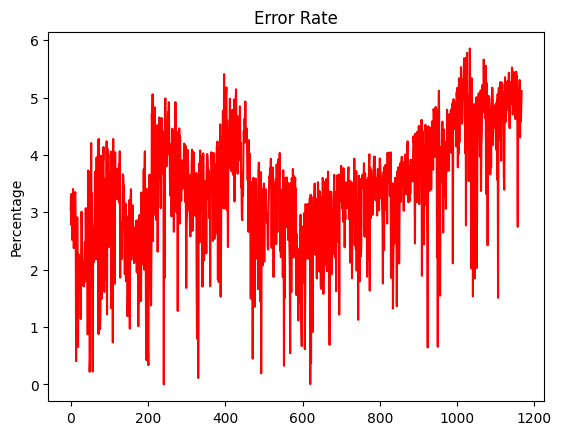

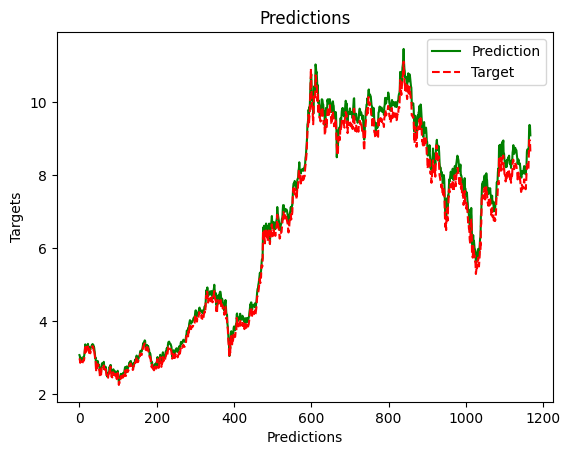

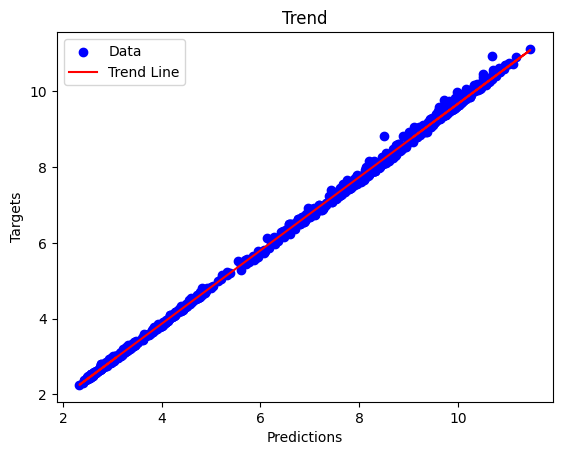

In [954]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    np.savetxt(file, preds, delimiter=',', fmt='%d', header='pred,target', comments='')

model = Stock_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
save_pred(preds, 'pred.csv')
plot_error_rate(preds[:,0], preds[:,1])
plot_pred(preds[:,0], preds[:,1])
plot_trend(preds[:,0], preds[:,1])

In [955]:
model = Stock_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))

single_loader = stock_dataloader(config, [[100,110,90,101]], [103])
predict(single_loader, model, device)

# for pred, target in single_pred:
#     print(f"Prediction: {pred}, Target: {target}")

100%|██████████| 1/1 [00:00<00:00, 461.67it/s]


array([[0.01057281, 0.        ]], dtype=float32)